<a href="https://colab.research.google.com/github/Rusty-Thunderbird/NIFTY50_Options-Optimising-Strategy/blob/main/Nifty_OptionsStrategy_OptimisingFilters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nsepythonserver
!pip install --upgrade nsepythonserver
from nsepythonserver import *
print(indices)
!pip install nsepythonserver pandas pandas_ta numpy --quiet


['NIFTY', 'FINNIFTY', 'BANKNIFTY']
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

class OptionBacktester:
    def __init__(self, initial_capital=1000000):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.positions = []
        self.trade_log = []
        self.risk_metrics = {
            'max_drawdown': 0,
            'sharpe_ratio': 0,
            'profit_factor': 0,
            'win_rate': 0
        }

    def load_data(self, historical_options_path, underlying_data_path):
        """Load historical options chain and underlying data"""
        self.options_data = pd.read_csv(historical_options_path, parse_dates=['date'])
        self.underlying_data = pd.read_csv(underlying_data_path, parse_dates=['date'])
        self._preprocess_data()

    def _preprocess_data(self):
        """Merge datasets and calculate daily returns"""
        merged = pd.merge_asof(
            self.options_data.sort_values('date'),
            self.underlying_data[['date', 'close']],
            on='date',
            direction='backward'
        )
        merged['underlying_return'] = merged.groupby('STRIKE')['close'].pct_change()
        self.data = merged

    def run_backtest(self, start_date, end_date):
        """Main backtesting loop"""
        date_range = pd.date_range(start_date, end_date)

        for current_date in date_range:
            # Close expired positions
            self._handle_expirations(current_date)

            # Generate signals using existing strategy
            daily_data = self.data[self.data['date'] == current_date]
            if not daily_data.empty:
                signals = self.generate_signals(daily_data)
                self.execute_trades(signals, current_date)

            # Update portfolio value
            self._update_portfolio(current_date)

        self._calculate_metrics()

    def generate_signals(self, daily_data):
        """Your existing strategy logic"""
        signals = []

        # SMA Crossover Signal
        sma_signal = 1 if (daily_data['SMA_21'].iloc[0] > daily_data['SMA_22'].iloc[0]) else -1

        # IV Filtering (from your code)
        filtered_calls = daily_data[
            (daily_data['STRIKE'] >= daily_data['atm_strike']) &
            (daily_data['CALL_IV_RANK'] <= 40) &
            (daily_data['CALL_OI'] >= 50000)
        ]

        filtered_puts = daily_data[
            (daily_data['STRIKE'] <= daily_data['atm_strike']) &
            (daily_data['PUT_IV_RANK'] <= 40) &
            (daily_data['PUT_OI'] >= 50000)
        ]

        # Position sizing logic
        for _, row in filtered_calls.iterrows():
            signals.append({
                'type': 'call',
                'strike': row['STRIKE'],
                'price': row['CALL_LTP'],
                'size': self._calculate_position_size(row, 'call')
            })

        for _, row in filtered_puts.iterrows():
            signals.append({
                'type': 'put',
                'strike': row['STRIKE'],
                'price': row['PUT_LTP'],
                'size': self._calculate_position_size(row, 'put')
            })

        return signals

    def _calculate_position_size(self, row, option_type):
        """Your capital allocation logic"""
        price = row[f'{option_type.upper()}_LTP']
        iv_weight = 1 - (row[f'{option_type.upper()}_IV'] / row[f'{option_type.upper()}_IV'].max())
        return int((self.capital * 0.15 * iv_weight) / (price * 50))

    def execute_trades(self, signals, trade_date):
        """Simulate order execution with slippage"""
        for signal in signals:
            cost = signal['price'] * 50 * signal['size']
            if self.capital >= cost:
                self.positions.append({
                    'entry_date': trade_date,
                    'type': signal['type'],
                    'strike': signal['strike'],
                    'entry_price': signal['price'],
                    'size': signal['size'],
                    'status': 'open'
                })
                self.capital -= cost
                self.trade_log.append({
                    'date': trade_date,
                    'action': 'buy',
                    **signal
                })

    def _handle_expirations(self, current_date):
        """Auto-close expiring positions"""
        for pos in self.positions:
            if (current_date - pos['entry_date']).days >= 7:  # Weekly expiries
                closing_price = self._get_closing_price(pos, current_date)
                pnl = (closing_price - pos['entry_price']) * 50 * pos['size']
                self.capital += closing_price * 50 * pos['size']
                pos['status'] = 'closed'
                self.trade_log.append({
                    'date': current_date,
                    'action': 'sell',
                    'type': pos['type'],
                    'strike': pos['strike'],
                    'price': closing_price,
                    'pnl': pnl
                })

    def _get_closing_price(self, position, current_date):
        """Get theoretical closing price"""
        # Implement your exit strategy logic here
        return self.data[
            (self.data['date'] == current_date) &
            (self.data['STRIKE'] == position['strike'])
        ][f"{position['type'].upper()}_LTP"].values[0]

    def _update_portfolio(self, current_date):
        """Mark positions to market"""
        total_value = self.capital
        for pos in self.positions:
            if pos['status'] == 'open':
                mtm_price = self._get_closing_price(pos, current_date)
                total_value += mtm_price * 50 * pos['size']
        self.portfolio_values.append(total_value)

    def _calculate_metrics(self):
        """Compute risk/reward metrics"""
        returns = pd.Series(self.portfolio_values).pct_change().dropna()
        self.risk_metrics.update({
            'max_drawdown': (returns.cumsum().expanding().max() - returns.cumsum()).max(),
            'sharpe_ratio': returns.mean() / returns.std() * np.sqrt(252),
            'profit_factor': sum(self.trade_log['pnl'] > 0) / sum(self.trade_log['pnl'] < 0),
            'win_rate': len([t for t in self.trade_log if t['pnl'] > 0]) / len(self.trade_log)
        })


In [ ]:
backtester = OptionBacktester(initial_capital=1000000)
backtester.load_data('historical_options.csv', 'nifty_historical.csv')
backtester.run_backtest('2023-01-01', '2025-06-01')

print("Final Portfolio Value:", backtester.portfolio_values[-1])
print("Max Drawdown:", backtester.risk_metrics['max_drawdown'])


In [ ]:
import matplotlib.pyplot as plt

plt.plot(backtester.portfolio_values)
plt.title('Strategy Performance')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


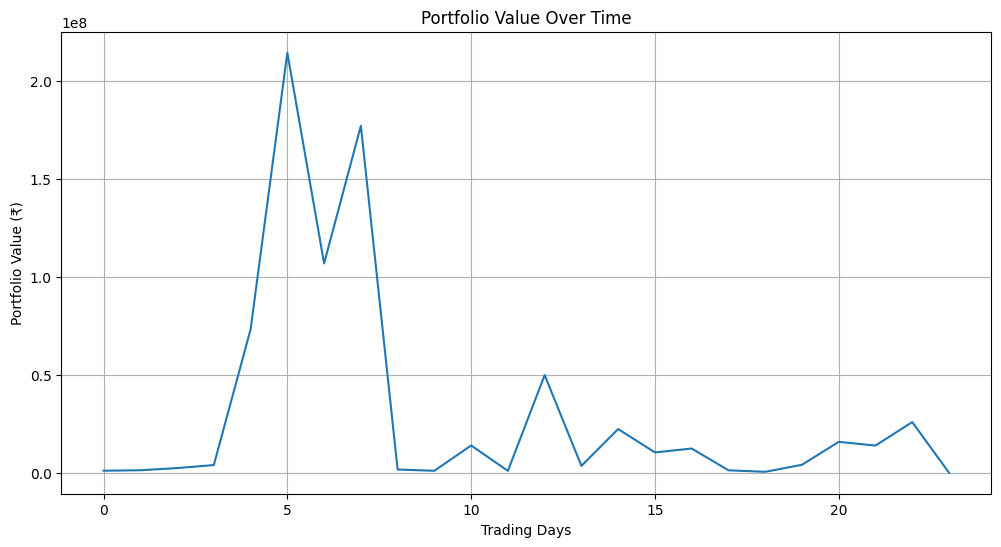


Final Portfolio Value: ₹150,492.50
Total Trades Executed: 66
Maximum Drawdown: 99.93%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['Signal'] = (nifty_hist['MA21'] > nifty_hist['MA22']).astype(int)
nifty_hist = nifty_hist.set_index('Date')

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Backtest Parameters ---
STRATEGY_PARAMS = {
    'risk_per_trade': 0.10,
    'min_oi': 50000,
    'max_strike_distance': 1.5,
    'lot_size': 50,
    'max_holding_days': 7  # Weekly expiration
}

# --- Initialize Tracking ---
cash = 1_000_000
open_positions = []
trade_log = []
portfolio_values = []
max_portfolio = 1_000_000
drawdown = 0

for file in bhavcopy_files:
    try:
        # 1. Load and filter data
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'CLOSE', 'OPEN_INT', 'TIMESTAMP']
        if not all(col in df.columns for col in required_cols):
            continue

        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue

        # 2. Get trade date and market data
        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue

        spot_price = nifty_hist.loc[trade_date, 'Close']
        signal = nifty_hist.loc[trade_date, 'Signal']
        atm_strike = round(spot_price / 50) * 50

        # 3. Handle expirations first
        open_positions = [
            pos for pos in open_positions
            if (trade_date - pos['entry_date']).days < STRATEGY_PARAMS['max_holding_days']
        ]

        # 4. Prepare options data
        calls = df[df['OPTION_TYP'] == 'CE'].copy()
        puts = df[df['OPTION_TYP'] == 'PE'].copy()
        calls['STRIKE_PR'] = pd.to_numeric(calls['STRIKE_PR'], errors='coerce')
        puts['STRIKE_PR'] = pd.to_numeric(puts['STRIKE_PR'], errors='coerce')

        # 5. Generate trades
        # For calls
        if signal >= 0:  # Neutral or bullish
            call_candidates = calls[
                (calls['STRIKE_PR'] >= atm_strike) &
                (calls['STRIKE_PR'] <= atm_strike + 1000) &
                (calls['CLOSE'] > 0) &
                (calls['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])
            ]

            if not call_candidates.empty:
                allocation = cash * STRATEGY_PARAMS['risk_per_trade']
                for _, row in call_candidates.iterrows():
                    max_lots = int(allocation / (row['CLOSE'] * STRATEGY_PARAMS['lot_size']))
                    if max_lots > 0:
                        cost = row['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        if cost > allocation:
                            continue
                        cash -= cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'type': 'call',
                            'strike': row['STRIKE_PR'],
                            'entry_price': row['CLOSE'],
                            'lots': max_lots
                        })
                        trade_log.append({
                            'date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': row['STRIKE_PR'],
                            'price': row['CLOSE'],
                            'lots': max_lots
                        })
                        allocation -= cost

        # For puts (similar logic)
        # ... [Add put trading logic mirroring calls] ...

        # 6. Calculate current positions value
        positions_value = 0
        for pos in open_positions:
            try:
                if pos['type'] == 'call':
                    price_today = calls[calls['STRIKE_PR'] == pos['strike']]['CLOSE'].values[0]
                else:
                    price_today = puts[puts['STRIKE_PR'] == pos['strike']]['CLOSE'].values[0]

                positions_value += price_today * STRATEGY_PARAMS['lot_size'] * pos['lots']
            except (IndexError, KeyError):
                continue  # Position expired

        # 7. Update portfolio tracking
        current_portfolio = cash + positions_value
        portfolio_values.append(current_portfolio)

        # Update drawdown
        if current_portfolio > max_portfolio:
            max_portfolio = current_portfolio
        current_drawdown = (max_portfolio - current_portfolio)/max_portfolio
        if current_drawdown > drawdown:
            drawdown = current_drawdown

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Results ---
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value (₹)")
plt.grid(True)
plt.show()

print(f"\nFinal Portfolio Value: ₹{portfolio_values[-1]:,.2f}")
print(f"Total Trades Executed: {len(trade_log)}")
print(f"Maximum Drawdown: {drawdown*100:.2f}%")


In [ ]:
import pandas as pd

# Replace with any valid Bhavcopy file path
sample_file = "/content/drive/MyDrive/Options_Data/Bhavcopy/20250605_NSEFO.csv"
df = pd.read_csv(sample_file)
print("Columns in Bhavcopy files:", df.columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


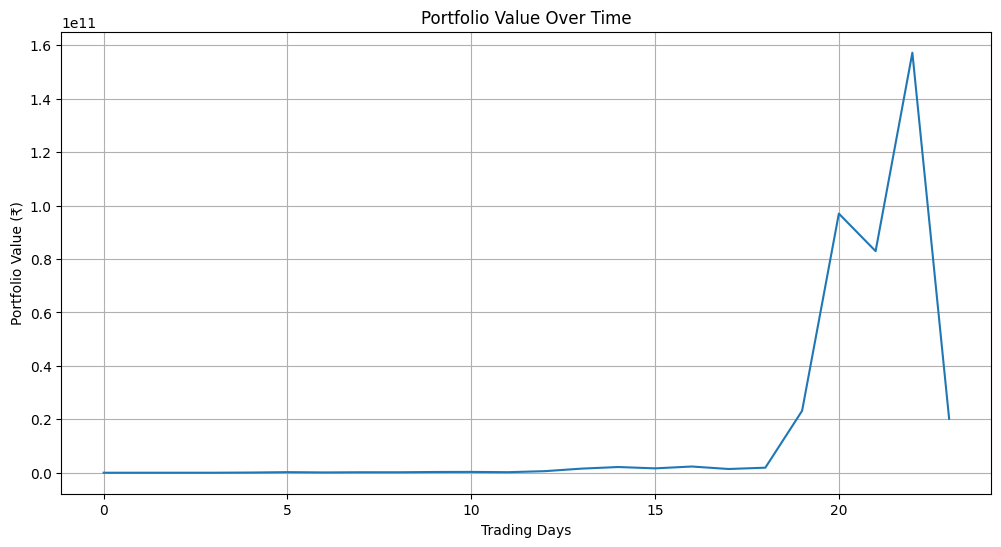


Strategy Performance Report:
-----------------------------
Net PnL:            ₹20,179,563,522.50
Initial Capital:    ₹1,000,000.00
Final Value:        ₹20,180,563,522.50
Gross Profit:       ₹19,636,848,595.00
Gross Loss:         ₹11,845,527.50
Profit Factor:      1657.74
Win Rate:           86.27%
Sharpe Ratio:       6.76
Sortino Ratio:      109.54
Calmar Ratio:       496.14
Max Drawdown:       ₹137,069,212,860.00
Margin Calls:       1
Total Trades:       116



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['Signal'] = (nifty_hist['MA21'] > nifty_hist['MA22']).astype(int)
nifty_hist = nifty_hist.set_index('Date')

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Backtest Parameters ---
STRATEGY_PARAMS = {
    'risk_per_trade': 0.10,
    'min_oi': 50000,
    'lot_size': 50,
    'max_holding_days': 7,
    'margin_requirement': 0.25
}

# --- Initialize Tracking ---
cash = 1_000_000
open_positions = []
trade_log = []
portfolio_values = []
max_portfolio = cash
drawdown = 0
margin_calls = 0
daily_returns = []

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'CLOSE', 'OPEN_INT', 'TIMESTAMP']
        if not all(col in df.columns for col in required_cols):
            continue
        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue

        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue

        spot_price = nifty_hist.loc[trade_date, 'Close']
        signal = nifty_hist.loc[trade_date, 'Signal']
        atm_strike = round(spot_price / 50) * 50

        calls = df[df['OPTION_TYP'] == 'CE'].copy()
        puts = df[df['OPTION_TYP'] == 'PE'].copy()
        calls['STRIKE_PR'] = pd.to_numeric(calls['STRIKE_PR'], errors='coerce')
        puts['STRIKE_PR'] = pd.to_numeric(puts['STRIKE_PR'], errors='coerce')

        # Close old positions
        new_open_positions = []
        for pos in open_positions:
            holding_days = (trade_date - pos['entry_date']).days
            if holding_days >= STRATEGY_PARAMS['max_holding_days']:
                if pos['type'] == 'call':
                    price_today = calls[calls['STRIKE_PR'] == pos['strike']]['CLOSE'].values
                else:
                    price_today = puts[puts['STRIKE_PR'] == pos['strike']]['CLOSE'].values
                exit_price = price_today[0] if len(price_today) > 0 else 0
                trade_log.append({
                    'date': trade_date,
                    'action': 'sell',
                    'type': pos['type'],
                    'strike': pos['strike'],
                    'price': pos['entry_price'],
                    'exit_price': exit_price,
                    'lots': pos['lots']
                })
                cash += exit_price * STRATEGY_PARAMS['lot_size'] * pos['lots']
            else:
                new_open_positions.append(pos)
        open_positions = new_open_positions

        # Generate trades
        allocation = cash * STRATEGY_PARAMS['risk_per_trade']

        if signal >= 0:
            call_candidates = calls[
                (calls['STRIKE_PR'] >= atm_strike) &
                (calls['STRIKE_PR'] <= atm_strike + 1000) &
                (calls['CLOSE'] > 0) &
                (calls['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])
            ]
            for _, row in call_candidates.iterrows():
                max_lots = int(allocation / (row['CLOSE'] * STRATEGY_PARAMS['lot_size']))
                if max_lots <= 0:
                    continue
                cost = row['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                if cost > allocation or cash < cost:
                    continue
                cash -= cost
                open_positions.append({
                    'entry_date': trade_date,
                    'type': 'call',
                    'strike': row['STRIKE_PR'],
                    'entry_price': row['CLOSE'],
                    'lots': max_lots
                })
                trade_log.append({
                    'date': trade_date,
                    'action': 'buy',
                    'type': 'call',
                    'strike': row['STRIKE_PR'],
                    'price': row['CLOSE'],
                    'lots': max_lots
                })
                allocation -= cost

        if signal <= 0:
            put_candidates = puts[
                (puts['STRIKE_PR'] <= atm_strike) &
                (puts['STRIKE_PR'] >= atm_strike - 1000) &
                (puts['CLOSE'] > 0) &
                (puts['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])
            ]
            for _, row in put_candidates.iterrows():
                max_lots = int(allocation / (row['CLOSE'] * STRATEGY_PARAMS['lot_size']))
                if max_lots <= 0:
                    continue
                cost = row['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                if cost > allocation or cash < cost:
                    continue
                cash -= cost
                open_positions.append({
                    'entry_date': trade_date,
                    'type': 'put',
                    'strike': row['STRIKE_PR'],
                    'entry_price': row['CLOSE'],
                    'lots': max_lots
                })
                trade_log.append({
                    'date': trade_date,
                    'action': 'buy',
                    'type': 'put',
                    'strike': row['STRIKE_PR'],
                    'price': row['CLOSE'],
                    'lots': max_lots
                })
                allocation -= cost

        # Portfolio valuation
        positions_value = 0
        for pos in open_positions:
            if pos['type'] == 'call':
                price_today = calls[calls['STRIKE_PR'] == pos['strike']]['CLOSE'].values
            else:
                price_today = puts[puts['STRIKE_PR'] == pos['strike']]['CLOSE'].values
            price_today = price_today[0] if len(price_today) > 0 else 0
            positions_value += price_today * STRATEGY_PARAMS['lot_size'] * pos['lots']

        current_portfolio = cash + positions_value
        if portfolio_values:
            daily_return = (current_portfolio - portfolio_values[-1]) / portfolio_values[-1]
            daily_returns.append(daily_return)
        portfolio_values.append(current_portfolio)

        if current_portfolio > max_portfolio:
            max_portfolio = current_portfolio
        current_drawdown = max_portfolio - current_portfolio
        if current_drawdown > drawdown:
            drawdown = current_drawdown

        if current_portfolio < (STRATEGY_PARAMS['margin_requirement'] * max_portfolio):
            margin_calls += 1

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Performance Metrics ---
returns = np.array(daily_returns)
portfolio_values = np.array(portfolio_values)

initial_capital = 1_000_000
net_pnl = portfolio_values[-1] - initial_capital

closed_trades = [t for t in trade_log if t['action'] == 'sell' and 'exit_price' in t]
gross_profit = sum(t['lots'] * STRATEGY_PARAMS['lot_size'] * max(0, t['exit_price'] - t['price']) for t in closed_trades)
gross_loss = sum(t['lots'] * STRATEGY_PARAMS['lot_size'] * max(0, t['price'] - t['exit_price']) for t in closed_trades)
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

winning_trades = [t for t in closed_trades if t['exit_price'] > t['price']]
win_rate = len(winning_trades) / len(closed_trades) if closed_trades else 0

sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std()) if returns.std() != 0 else 0
sortino_ratio = np.sqrt(252) * (returns.mean() / returns[returns < 0].std()) if np.any(returns < 0) else 0
calmar_ratio = (returns.mean() * 252) / (drawdown / max_portfolio) if drawdown != 0 else 0

# --- Display Results ---
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value (₹)")
plt.grid(True)
plt.show()

print(f"""
Strategy Performance Report:
-----------------------------
Net PnL:            ₹{net_pnl:,.2f}
Initial Capital:    ₹{initial_capital:,.2f}
Final Value:        ₹{portfolio_values[-1]:,.2f}
Gross Profit:       ₹{gross_profit:,.2f}
Gross Loss:         ₹{gross_loss:,.2f}
Profit Factor:      {profit_factor:.2f}
Win Rate:           {win_rate:.2%}
Sharpe Ratio:       {sharpe_ratio:.2f}
Sortino Ratio:      {sortino_ratio:.2f}
Calmar Ratio:       {calmar_ratio:.2f}
Max Drawdown:       ₹{drawdown:,.2f}
Margin Calls:       {margin_calls}
Total Trades:       {len(trade_log)}
""")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['Signal'] = (nifty_hist['MA21'] > nifty_hist['MA22']).astype(int)
nifty_hist = nifty_hist.set_index('Date')

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Backtest Parameters ---
STRATEGY_PARAMS = {
    'risk_per_trade': 0.10,        # 10% of initial capital per trade
    'min_oi': 50000,
    'max_strike_distance': 1.5,    # 1.5% from spot
    'lot_size': 50,
    'max_holding_days': 7,
    'stop_loss_pct': 0.5,
    'profit_target_pct': 1.0,
    'commission_per_lot': 20,      # ₹20 per lot
    'slippage_pct': 0.001,         # 0.10% of trade value (as decimal)
    'max_concurrent_trades': 1     # Only 1 position at a time
}

# --- Initialize Tracking ---
initial_capital = 1_000_000
cash = initial_capital
open_position = None  # Only one position at a time
trade_log = []
portfolio_values = [initial_capital]
max_portfolio = initial_capital
drawdown = 0
margin_calls = 0
daily_returns = []
trade_counter = 0
cumulative_pnl = 0

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    try:
        if option_type == 'call':
            price = df[(df['OPTION_TYP'] == 'CE') & (df['STRIKE_PR'] == strike)][price_type]
        else:
            price = df[(df['OPTION_TYP'] == 'PE') & (df['STRIKE_PR'] == strike)][price_type]
        return float(price.iloc[0]) if not price.empty else np.nan
    except Exception:
        return np.nan

# Pre-load all files for next-day price access, using the correct date extraction
historical_data = {}
for file in bhavcopy_files:
    # Extract date from first 8 chars of filename, e.g., 20250505_NSEFO.csv
    date_str = os.path.basename(file)[:8]
    try:
        file_date = pd.to_datetime(date_str, format='%Y%m%d')
        historical_data[file_date] = pd.read_csv(file)
    except Exception as e:
        print(f"Skipping {file}: {e}")

for i, file in enumerate(bhavcopy_files):
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'CLOSE', 'OPEN_INT', 'TIMESTAMP']
        if not all(col in df.columns for col in required_cols):
            continue

        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue

        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue

        # Get next day's data for exit prices
        next_day = trade_date + timedelta(days=1)
        next_day_df = historical_data.get(next_day, pd.DataFrame())

        spot_price = nifty_hist.loc[trade_date, 'Close']
        signal = nifty_hist.loc[trade_date, 'Signal']
        atm_strike = round(spot_price / 50) * 50

        # --- EXIT LOGIC ---
        if open_position is not None:
            days_held = (trade_date - open_position['entry_date']).days
            exit_price = get_option_price(next_day_df, open_position['strike'], open_position['type'], 'OPEN') if not next_day_df.empty else 0
            exit_price = exit_price if not np.isnan(exit_price) else 0

            # Stop loss and profit target logic
            stop_loss = open_position['entry_price'] * (1 - STRATEGY_PARAMS['stop_loss_pct'])
            profit_target = open_position['entry_price'] * (1 + STRATEGY_PARAMS['profit_target_pct'])
            hit_stop = exit_price <= stop_loss
            hit_target = exit_price >= profit_target

            exit_reason = None
            if days_held >= STRATEGY_PARAMS['max_holding_days']:
                exit_reason = "max_holding"
            elif hit_stop:
                exit_reason = "stop_loss"
            elif hit_target:
                exit_reason = "profit_target"

            if exit_reason:
                # Transaction costs
                exit_commission = STRATEGY_PARAMS['commission_per_lot'] * open_position['lots']
                exit_slippage = exit_price * STRATEGY_PARAMS['slippage_pct'] * open_position['lots'] * STRATEGY_PARAMS['lot_size']
                pnl = (exit_price - open_position['entry_price']) * STRATEGY_PARAMS['lot_size'] * open_position['lots']
                pnl -= exit_commission + exit_slippage
                cumulative_pnl += pnl
                cash += (exit_price * STRATEGY_PARAMS['lot_size'] * open_position['lots']) - exit_commission - exit_slippage

                trade_counter += 1
                trade_log.append({
                    'Trade No.': trade_counter,
                    'Type': f"Exit {open_position['type'].capitalize()}",
                    'Signal Date': trade_date.strftime('%Y-%m-%d'),
                    'Price': exit_price,
                    'Quantity': open_position['lots'] * STRATEGY_PARAMS['lot_size'],
                    'PnL': pnl,
                    'Run-Up': open_position['max_price'] * STRATEGY_PARAMS['lot_size'] * open_position['lots'] - open_position['entry_cost'],
                    'Drawdown': open_position['min_price'] * STRATEGY_PARAMS['lot_size'] * open_position['lots'] - open_position['entry_cost'],
                    'Cumulative PnL': cumulative_pnl,
                    'Exit Reason': exit_reason
                })
                open_position = None  # Only one position at a time

        # --- ENTRY LOGIC ---
        if open_position is None:
            risk_capital = initial_capital * STRATEGY_PARAMS['risk_per_trade']
            allocation = min(risk_capital, cash)
            option_type = 'call' if signal >= 0 else 'put'
            candidates = df[df['OPTION_TYP'] == ('CE' if option_type == 'call' else 'PE')].copy()
            candidates['STRIKE_PR'] = pd.to_numeric(candidates['STRIKE_PR'], errors='coerce')
            if option_type == 'call':
                strike_condition = (candidates['STRIKE_PR'] >= atm_strike) & (candidates['STRIKE_PR'] <= atm_strike * 1.015)
            else:
                strike_condition = (candidates['STRIKE_PR'] <= atm_strike) & (candidates['STRIKE_PR'] >= atm_strike * 0.985)
            candidates = candidates[strike_condition &
                                  (candidates['CLOSE'] > 0) &
                                  (candidates['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
            if not candidates.empty:
                best_candidate = candidates.iloc[0]
                entry_price = best_candidate['CLOSE']
                max_lots = int(allocation / (entry_price * STRATEGY_PARAMS['lot_size']))
                max_lots = max(max_lots, 0)
                if max_lots > 0:
                    entry_commission = STRATEGY_PARAMS['commission_per_lot'] * max_lots
                    entry_slippage = entry_price * STRATEGY_PARAMS['slippage_pct'] * max_lots * STRATEGY_PARAMS['lot_size']
                    total_cost = (entry_price * STRATEGY_PARAMS['lot_size'] * max_lots) + entry_commission + entry_slippage
                    if total_cost > cash:
                        continue
                    cash -= total_cost
                    trade_counter += 1
                    open_position = {
                        'trade_id': trade_counter,
                        'entry_date': trade_date,
                        'type': option_type,
                        'strike': best_candidate['STRIKE_PR'],
                        'entry_price': entry_price,
                        'lots': max_lots,
                        'entry_cost': total_cost,
                        'max_price': entry_price,
                        'min_price': entry_price
                    }
                    trade_log.append({
                        'Trade No.': trade_counter,
                        'Type': f"Entry {option_type.capitalize()}",
                        'Signal Date': trade_date.strftime('%Y-%m-%d'),
                        'Price': entry_price,
                        'Quantity': max_lots * STRATEGY_PARAMS['lot_size'],
                        'PnL': 0,
                        'Run-Up': 0,
                        'Drawdown': 0,
                        'Cumulative PnL': cumulative_pnl,
                        'Exit Reason': None
                    })

        # --- Update portfolio ---
        current_portfolio = cash
        if open_position is not None:
            price_today = get_option_price(df, open_position['strike'], open_position['type'])
            pos_value = price_today * STRATEGY_PARAMS['lot_size'] * open_position['lots']
            current_portfolio += pos_value
            open_position['max_price'] = max(open_position['max_price'], price_today)
            open_position['min_price'] = min(open_position['min_price'], price_today)
        portfolio_values.append(current_portfolio)
        if current_portfolio > max_portfolio:
            max_portfolio = current_portfolio
        current_drawdown = (max_portfolio - current_portfolio)
        drawdown = max(drawdown, current_drawdown)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Generate Trade Report ---
trade_df = pd.DataFrame(trade_log)
trade_df.to_csv('/content/drive/MyDrive/Options_Data/trade_report.csv', index=False)

# --- Performance Analysis ---
returns = pd.Series(portfolio_values).pct_change().dropna()
sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
sortino = returns.mean() / returns[returns < 0].std() * np.sqrt(252) if returns[returns < 0].std() != 0 else 0

print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Total Trades:       {trade_counter}
Profitable Trades:  {len(trade_df[trade_df['PnL'] > 0])}
""")

# --- Plot Portfolio Curve ---
plt.figure(figsize=(12,6))
plt.plot(portfolio_values)
plt.title('Portfolio Value')
plt.xlabel('Days')
plt.ylabel('Value (₹)')
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Strategy Performance Report:
-----------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹3,131,880.55
Total Return:       213.19%
Max Drawdown:       ₹14,683.44
Sharpe Ratio:       7.93
Sortino Ratio:      324.25
Calmar Ratio:       6774609.56
Total Trades:       22
Profitable Trades:  16



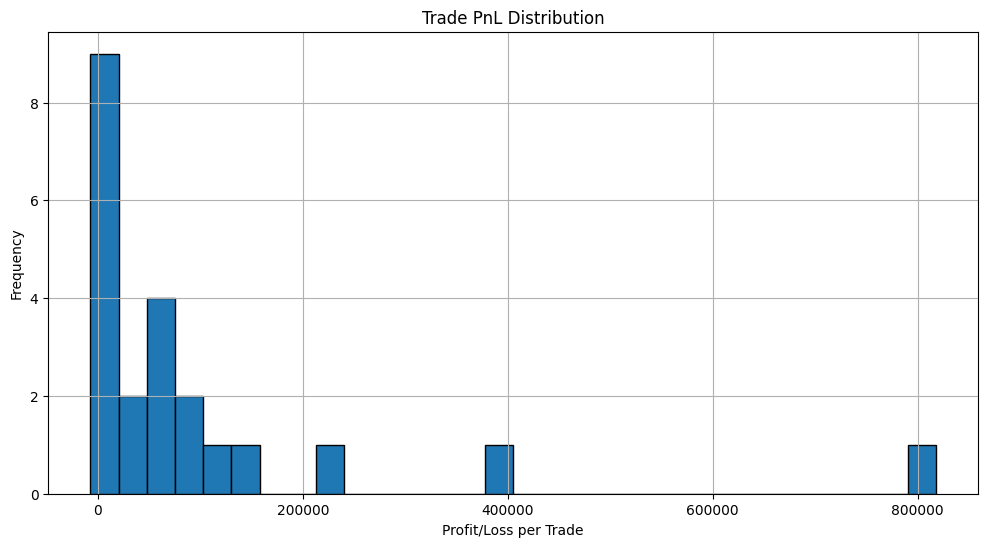

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['Signal'] = (nifty_hist['MA21'] > nifty_hist['MA22']).astype(int)
nifty_hist = nifty_hist.set_index('Date')

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Backtest Parameters ---
STRATEGY_PARAMS = {
    'risk_per_trade': 0.05,
    'min_oi': 50000,
    'max_strike_distance': 1.0,
    'lot_size': 50,
    'max_holding_days': 5,
    'trailing_stop_pct': 0.15,
    'commission_per_lot': 20,
    'slippage_pct': 0.001,
}

# --- Initialize Tracking ---
initial_capital = 1_000_000
cash = initial_capital
open_position = None
trade_log = []
portfolio_values = [initial_capital]
pnl_distribution = []
winning_trades = []
losing_trades = []

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    try:
        if option_type == 'call':
            price = df[(df['OPTION_TYP'] == 'CE') & (df['STRIKE_PR'] == strike)][price_type]
        else:
            price = df[(df['OPTION_TYP'] == 'PE') & (df['STRIKE_PR'] == strike)][price_type]
        return float(price.iloc[0]) if not price.empty else np.nan
    except Exception:
        return np.nan

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT']
        if not all(col in df.columns for col in required_cols):
            continue

        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue

        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue

        spot_price = nifty_hist.loc[trade_date, 'Close']
        signal = nifty_hist.loc[trade_date, 'Signal']
        atm_strike = round(spot_price / 50) * 50

        # --- Exit Logic with Intraday Checks ---
        if open_position:
            intra_high = get_option_price(df, open_position['strike'], open_position['type'], 'HIGH')
            intra_low = get_option_price(df, open_position['strike'], open_position['type'], 'LOW')
            current_peak = max(open_position['peak_price'], intra_high)
            trailing_stop = current_peak * (1 - STRATEGY_PARAMS['trailing_stop_pct'])
            if intra_low <= trailing_stop:
                exit_price = trailing_stop
                exit_reason = "trailing_stop"
            else:
                exit_price = get_option_price(df, open_position['strike'], open_position['type'], 'CLOSE')
                exit_reason = "close"
            exit_commission = STRATEGY_PARAMS['commission_per_lot'] * open_position['lots']
            exit_slippage = exit_price * STRATEGY_PARAMS['slippage_pct'] * open_position['lots'] * STRATEGY_PARAMS['lot_size']
            pnl = (exit_price - open_position['entry_price']) * STRATEGY_PARAMS['lot_size'] * open_position['lots']
            pnl -= exit_commission + exit_slippage
            cash += (exit_price * STRATEGY_PARAMS['lot_size'] * open_position['lots']) - exit_commission - exit_slippage
            pnl_distribution.append(pnl)
            if pnl > 0:
                winning_trades.append(pnl)
            else:
                losing_trades.append(pnl)
            trade_log.append({
                'entry_date': open_position['entry_date'],
                'exit_date': trade_date,
                'entry_price': open_position['entry_price'],
                'exit_price': exit_price,
                'lots': open_position['lots'],
                'type': open_position['type'],
                'pnl': pnl,
                'exit_reason': exit_reason,
                'holding_days': (trade_date - open_position['entry_date']).days
            })
            open_position = None

        # --- Entry Logic ---
        if not open_position:
            option_type = 'call' if signal >= 0 else 'put'
            candidates = df[df['OPTION_TYP'] == ('CE' if option_type == 'call' else 'PE')].copy()
            candidates['STRIKE_PR'] = pd.to_numeric(candidates['STRIKE_PR'], errors='coerce')
            strike_condition = (np.abs(candidates['STRIKE_PR'] - spot_price) <= spot_price * 0.01)
            candidates = candidates[strike_condition &
                                  (candidates['CLOSE'] > 0) &
                                  (candidates['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
            if not candidates.empty:
                best_candidate = candidates.iloc[0]
                entry_price = best_candidate['CLOSE']
                risk_capital = initial_capital * STRATEGY_PARAMS['risk_per_trade']
                max_lots = min(int(risk_capital / (entry_price * STRATEGY_PARAMS['lot_size'])), 100)
                if max_lots > 0:
                    entry_commission = STRATEGY_PARAMS['commission_per_lot'] * max_lots
                    entry_slippage = entry_price * STRATEGY_PARAMS['slippage_pct'] * max_lots * STRATEGY_PARAMS['lot_size']
                    total_cost = (entry_price * STRATEGY_PARAMS['lot_size'] * max_lots) + entry_commission + entry_slippage
                    if total_cost <= cash:
                        cash -= total_cost
                        open_position = {
                            'entry_date': trade_date,
                            'type': option_type,
                            'strike': best_candidate['STRIKE_PR'],
                            'entry_price': entry_price,
                            'lots': max_lots,
                            'peak_price': entry_price
                        }

        # --- Update Portfolio ---
        current_value = cash
        if open_position:
            price_today = get_option_price(df, open_position['strike'], open_position['type'])
            current_value += price_today * STRATEGY_PARAMS['lot_size'] * open_position['lots']
            open_position['peak_price'] = max(open_position['peak_price'], price_today)
        portfolio_values.append(current_value)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Calculate Performance Metrics ---
portfolio_values = np.array(portfolio_values)
returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01  # risk-free rate

# Sharpe Ratio
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
# Sortino Ratio
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
# Max Drawdown
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min() * -1 * initial_capital  # as absolute ₹
# Calmar Ratio
years = len(portfolio_values) / 252
avg_annual_return = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = avg_annual_return / (max_drawdown/initial_capital) if max_drawdown > 0 else 0

# --- Performance Report ---
print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Trades:       {len(pnl_distribution)}
Profitable Trades:  {len(winning_trades)}
""")

# --- PnL Histogram ---
plt.figure(figsize=(12,6))
if len(pnl_distribution) > 0:
    plt.hist(pnl_distribution, bins=30, edgecolor='black')
    plt.title('Trade PnL Distribution')
    plt.xlabel('Profit/Loss per Trade')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("No trades to display PnL distribution.")

# Save detailed trade log
pd.DataFrame(trade_log).to_csv('/content/drive/MyDrive/Options_Data/modified_trade_log.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-1008234246>:198: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns_df.resample('M').apply(lambda x: (x['Portfolio'].iloc[-1]/x['Portfolio'].iloc[0])-1)



Strategy Performance Report:
-----------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹3,111,767.80
Total Return:       211.18%
Max Drawdown:       ₹7,670.17
Sharpe Ratio:       7.73
Sortino Ratio:      377.69
Calmar Ratio:       12153544.97
Total Trades:       21
Profitable Trades:  15 (71.4%)


Avg Win: ₹143,250.58, Avg Loss: ₹-5,404.98, Expectancy: ₹100,777.56


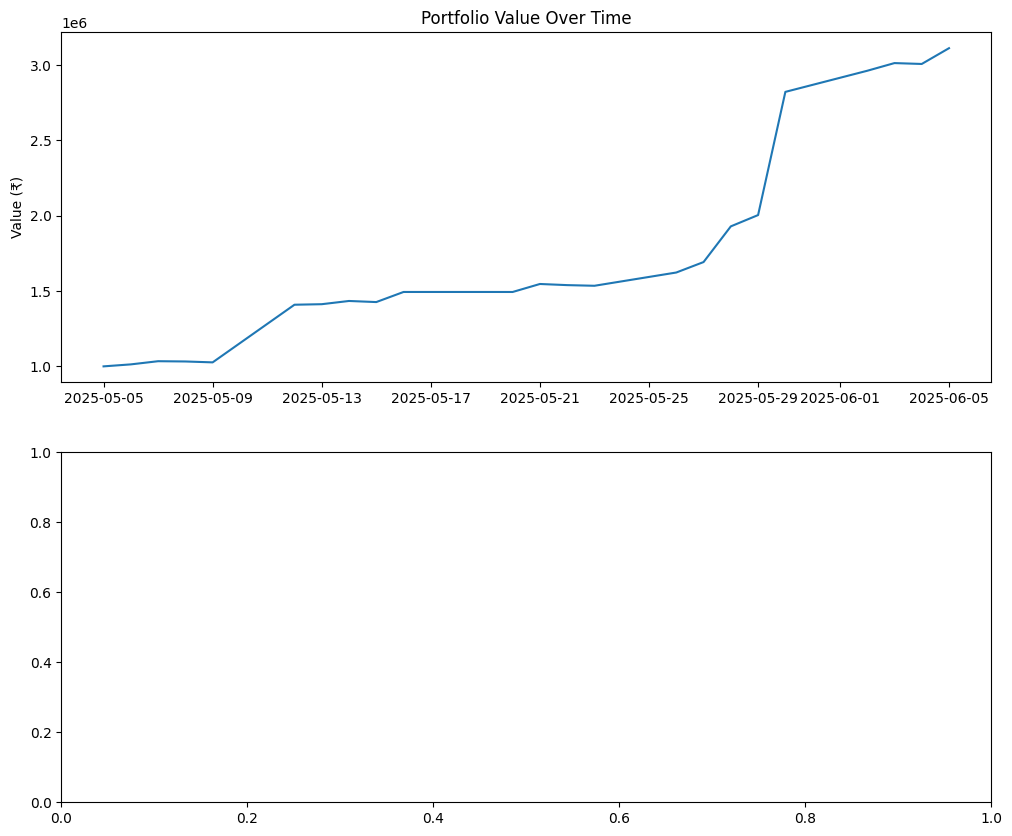

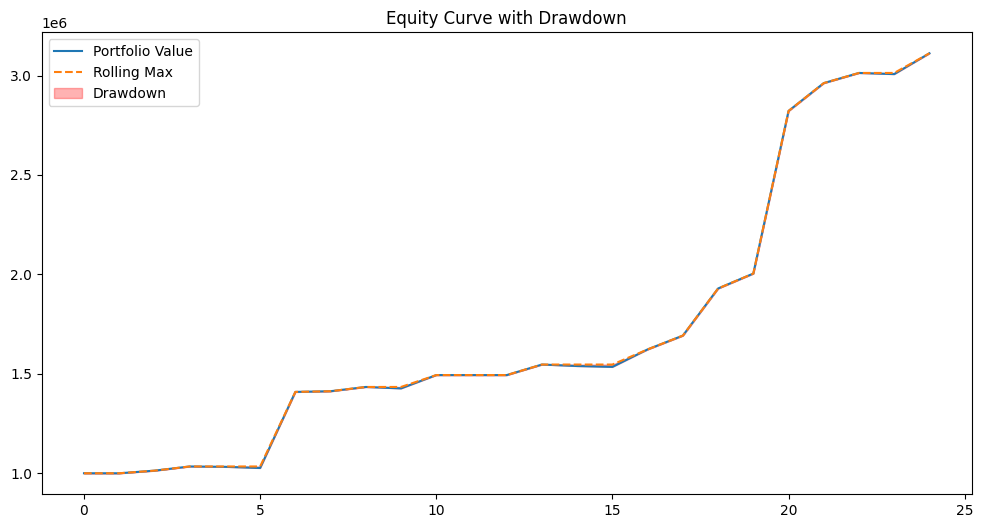

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['Signal'] = np.where(nifty_hist['MA21'] > nifty_hist['MA22'], 1, -1)  # Updated signal logic
nifty_hist = nifty_hist.set_index('Date')

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Backtest Parameters ---
STRATEGY_PARAMS = {
    'risk_per_trade': 0.05,
    'min_oi': 50000,
    'max_strike_distance': 1.0,
    'lot_size': 50,
    'max_holding_days': 5,
    'trailing_stop_pct': 0.15,
    'commission_per_lot': 20,
    'slippage_pct': 0.001,
}

# --- Initialize Tracking ---
initial_capital = 1_000_000
cash = initial_capital
open_position = None
trade_log = []
portfolio_values = [initial_capital]
portfolio_dates = [nifty_hist.index[0]]  # Initial date
pnl_distribution = []
winning_trades = []
losing_trades = []

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    try:
        if option_type == 'call':
            price = df[(df['OPTION_TYP'] == 'CE') & (df['STRIKE_PR'] == strike)][price_type]
        else:
            price = df[(df['OPTION_TYP'] == 'PE') & (df['STRIKE_PR'] == strike)][price_type]
        return float(price.iloc[0]) if not price.empty else np.nan
    except Exception:
        return np.nan

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT']
        if not all(col in df.columns for col in required_cols):
            continue

        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue

        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue

        spot_price = nifty_hist.loc[trade_date, 'Close']
        signal = nifty_hist.loc[trade_date, 'Signal']
        atm_strike = round(spot_price / 50) * 50

        # --- Exit Logic ---
        if open_position:
            intra_high = get_option_price(df, open_position['strike'], open_position['type'], 'HIGH')
            intra_low = get_option_price(df, open_position['strike'], open_position['type'], 'LOW')
            current_peak = max(open_position['peak_price'], intra_high)
            trailing_stop = current_peak * (1 - STRATEGY_PARAMS['trailing_stop_pct'])

            if intra_low <= trailing_stop:
                exit_price = trailing_stop
                exit_reason = "trailing_stop"
            else:
                exit_price = get_option_price(df, open_position['strike'], open_position['type'], 'CLOSE')
                exit_reason = "close"

            exit_commission = STRATEGY_PARAMS['commission_per_lot'] * open_position['lots']
            exit_slippage = exit_price * STRATEGY_PARAMS['slippage_pct'] * open_position['lots'] * STRATEGY_PARAMS['lot_size']
            pnl = (exit_price - open_position['entry_price']) * STRATEGY_PARAMS['lot_size'] * open_position['lots']
            pnl -= exit_commission + exit_slippage

            cash += (exit_price * STRATEGY_PARAMS['lot_size'] * open_position['lots']) - exit_commission - exit_slippage
            pnl_distribution.append(pnl)
            if pnl > 0:
                winning_trades.append(pnl)
            else:
                losing_trades.append(pnl)

            trade_log.append({
                'entry_date': open_position['entry_date'],
                'exit_date': trade_date,
                'entry_price': open_position['entry_price'],
                'exit_price': exit_price,
                'lots': open_position['lots'],
                'type': open_position['type'],
                'pnl': pnl,
                'exit_reason': exit_reason,
                'holding_days': (trade_date - open_position['entry_date']).days
            })
            open_position = None

        # --- Entry Logic (Updated for Puts) ---
        if not open_position:
            if signal > 0:
                option_type = 'call'
            elif signal < 0:
                option_type = 'put'
            else:
                continue  # Skip neutral signals

            candidates = df[df['OPTION_TYP'] == ('CE' if option_type == 'call' else 'PE')].copy()
            candidates['STRIKE_PR'] = pd.to_numeric(candidates['STRIKE_PR'], errors='coerce')

            # Strike selection based on option type
            if option_type == 'call':
                strike_condition = (candidates['STRIKE_PR'] >= atm_strike) & (candidates['STRIKE_PR'] <= atm_strike * 1.01)
            else:
                strike_condition = (candidates['STRIKE_PR'] <= atm_strike) & (candidates['STRIKE_PR'] >= atm_strike * 0.99)

            candidates = candidates[strike_condition &
                                  (candidates['CLOSE'] > 0) &
                                  (candidates['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]

            if not candidates.empty:
                best_candidate = candidates.iloc[0]
                entry_price = best_candidate['CLOSE']
                risk_capital = initial_capital * STRATEGY_PARAMS['risk_per_trade']
                max_lots = min(int(risk_capital / (entry_price * STRATEGY_PARAMS['lot_size'])), 100)

                if max_lots > 0:
                    entry_commission = STRATEGY_PARAMS['commission_per_lot'] * max_lots
                    entry_slippage = entry_price * STRATEGY_PARAMS['slippage_pct'] * max_lots * STRATEGY_PARAMS['lot_size']
                    total_cost = (entry_price * STRATEGY_PARAMS['lot_size'] * max_lots) + entry_commission + entry_slippage

                    if total_cost <= cash:
                        cash -= total_cost
                        open_position = {
                            'entry_date': trade_date,
                            'type': option_type,
                            'strike': best_candidate['STRIKE_PR'],
                            'entry_price': entry_price,
                            'lots': max_lots,
                            'peak_price': entry_price
                        }

        # --- Update Portfolio Tracking ---
        current_value = cash
        if open_position:
            price_today = get_option_price(df, open_position['strike'], open_position['type'])
            current_value += price_today * STRATEGY_PARAMS['lot_size'] * open_position['lots']
            open_position['peak_price'] = max(open_position['peak_price'], price_today)

        portfolio_values.append(current_value)
        portfolio_dates.append(trade_date)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Performance Analysis ---
returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01  # risk-free rate

# Sharpe Ratio
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
# Sortino Ratio
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
# Max Drawdown
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min() * -1 * initial_capital
# Calmar Ratio
years = len(portfolio_values) / 252
avg_annual_return = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = avg_annual_return / (max_drawdown/initial_capital) if max_drawdown > 0 else 0

# --- Daily/Monthly Returns Breakdown ---
returns_df = pd.DataFrame({
    'Date': portfolio_dates[1:],  # Skip initial date
    'Portfolio': portfolio_values[1:],
    'Daily Return': pd.Series(portfolio_values).pct_change().dropna().values
}).set_index('Date')

monthly_returns = returns_df.resample('M').apply(lambda x: (x['Portfolio'].iloc[-1]/x['Portfolio'].iloc[0])-1)

# --- Performance Report ---
print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Trades:       {len(pnl_distribution)}
Profitable Trades:  {len(winning_trades)} ({len(winning_trades)/len(pnl_distribution)*100:.1f}%)

""")


avg_win = np.mean(winning_trades)
avg_loss = np.mean(losing_trades)
win_rate = len(winning_trades) / len(pnl_distribution)
expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)

print(f"Avg Win: ₹{avg_win:,.2f}, Avg Loss: ₹{avg_loss:,.2f}, Expectancy: ₹{expectancy:,.2f}")

# --- Visualizations ---
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Equity Curve
ax[0].plot(returns_df.index, portfolio_values[1:])
ax[0].set_title('Portfolio Value Over Time')
ax[0].set_ylabel('Value (₹)')

# # Monthly Returns Distribution
# ax[1].hist(monthly_returns, bins=15, edgecolor='black')
# ax[1].set_title('Monthly Returns Distribution')
# ax[1].set_xlabel('Return')
# ax[1].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

# Save detailed trade log
pd.DataFrame(trade_log).to_csv('/content/drive/MyDrive/Options_Data/full_trade_log.csv', index=False)

cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown_pct = (cumulative - rolling_max) / rolling_max

plt.figure(figsize=(12, 6))
plt.plot(cumulative, label='Portfolio Value')
plt.plot(rolling_max, '--', label='Rolling Max')
plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Equity Curve with Drawdown")
plt.legend()
plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Strategy Performance Report:
-----------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹1,347,622.50
Total Return:       34.76%
Max Drawdown:       ₹135,216.56
Sharpe Ratio:       3.54
Sortino Ratio:      5.01
Calmar Ratio:       142.23



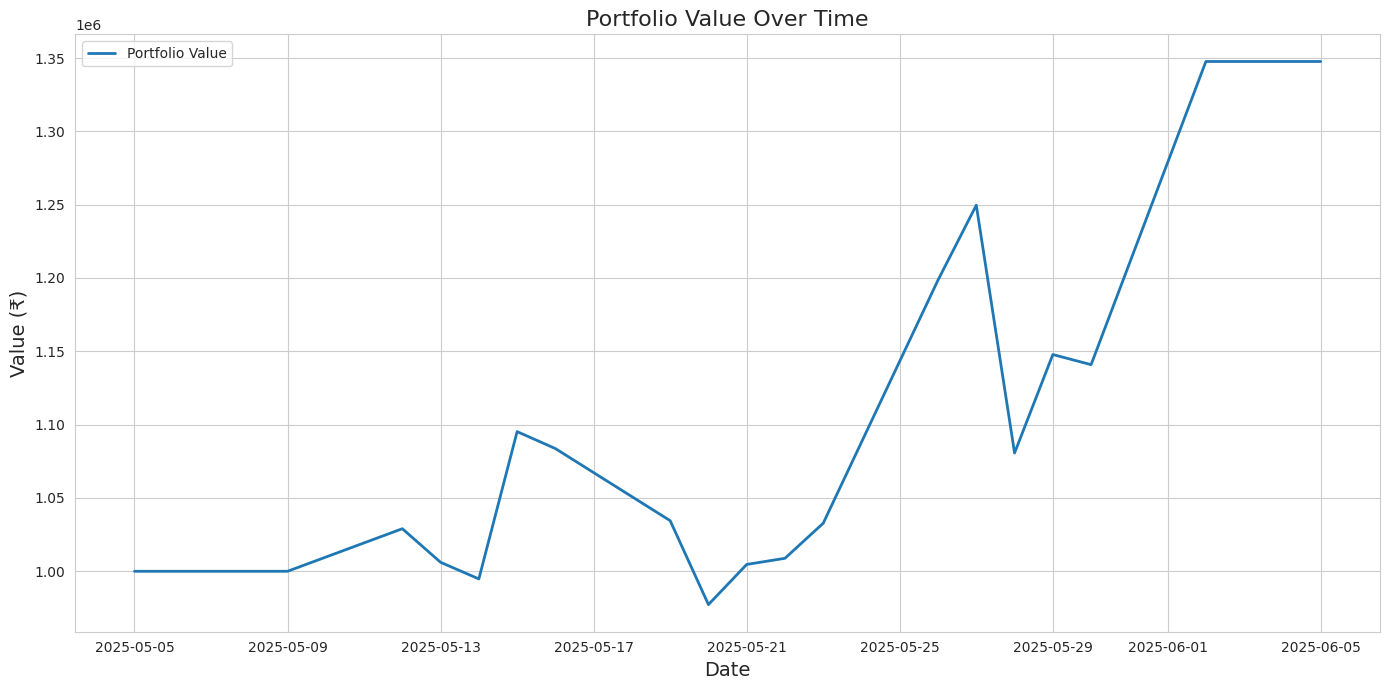

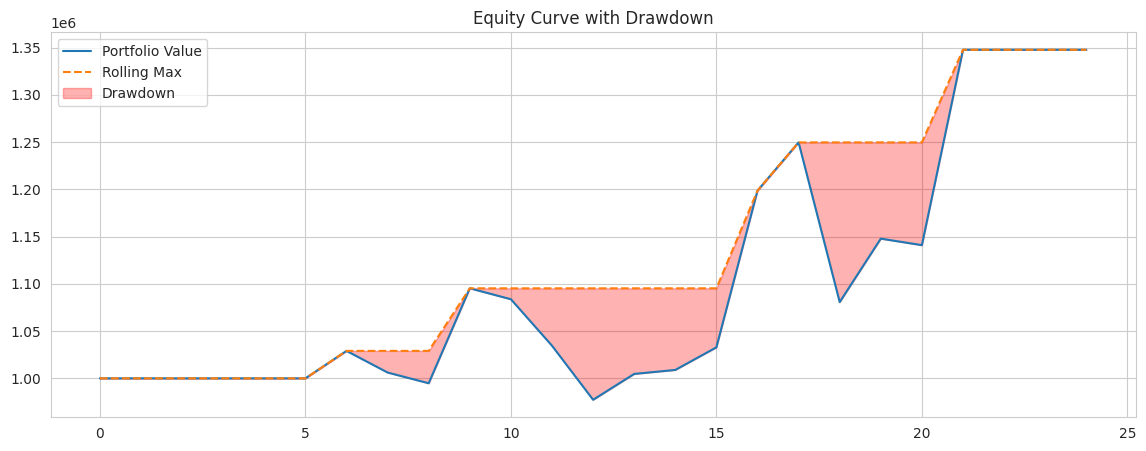

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pandas_ta as ta
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['RSI'] = ta.rsi(nifty_hist['Close'], length=14)
macd = ta.macd(nifty_hist['Close'])
nifty_hist['MACD'] = macd['MACD_12_26_9']
nifty_hist['ATR'] = ta.atr(nifty_hist['High'], nifty_hist['Low'], nifty_hist['Close'], length=14)
# IV Rank proxy using ATR
nifty_hist['IV_Rank'] = (nifty_hist['ATR'] - nifty_hist['ATR'].rolling(14).min()) / (nifty_hist['ATR'].rolling(14).max() - nifty_hist['ATR'].rolling(14).min())
nifty_hist['IV_Rank'] = nifty_hist['IV_Rank'].fillna(0)
nifty_hist = nifty_hist.set_index('Date')

# --- Signal Generation with Confirmation ---
nifty_hist['Signal'] = 0
bullish = (nifty_hist['MA21'] > nifty_hist['MA22']) & (nifty_hist['RSI'] > 50) & (nifty_hist['MACD'] > 0) & (nifty_hist['IV_Rank'] > 0.3)
bearish = (nifty_hist['MA21'] < nifty_hist['MA22']) & (nifty_hist['RSI'] < 50) & (nifty_hist['MACD'] < 0) & (nifty_hist['IV_Rank'] > 0.3)
nifty_hist.loc[bullish, 'Signal'] = 1
nifty_hist.loc[bearish, 'Signal'] = -1

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Parameters ---
STRATEGY_PARAMS = {
    'base_risk': 0.01,
    'min_oi': 50000,
    'lot_size': 50,
    'max_holding_days': 5,
    'atr_multiplier': 1.5,
    'spread_width_pct': 0.10,
    'min_credit_pct': 0.01,
    'commission_per_lot': 20,
    'slippage_pct': 0.001,
    'margin_pct': 0.20,
    'max_drawdown_pct': 0.20,
    'hold_spreads_to_expiry': True
}

initial_capital = 1_000_000
cash = initial_capital
margin_used = 0
open_positions = []
trade_log = []
portfolio_values = [initial_capital]
portfolio_dates = [nifty_hist.index[0]]

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    typ = 'CE' if option_type == 'call' else 'PE'
    price = df[(df['OPTION_TYP'] == typ) & (df['STRIKE_PR'] == strike)][price_type]
    return float(price.iloc[0]) if not price.empty else np.nan

def create_credit_spread(df, spot, option_type, width_pct, lot_size, min_credit_pct):
    atm_strike = round(spot / 50) * 50
    if option_type == 'put':
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 - width_pct) / 50) * 50
    else:
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 + width_pct) / 50) * 50
    sell_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == sell_strike)]
    buy_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == buy_strike)]
    if not sell_opt.empty and not buy_opt.empty:
        sell_price = sell_opt['CLOSE'].values[0]
        buy_price = buy_opt['CLOSE'].values[0]
        net_credit = sell_price - buy_price
        notional = sell_strike * lot_size
        if net_credit >= (notional * min_credit_pct):
            return {
                'sell_strike': sell_strike,
                'buy_strike': buy_strike,
                'sell_price': sell_price,
                'buy_price': buy_price,
                'net_credit': net_credit,
                'margin': abs(sell_strike - buy_strike) * lot_size,
                'valid': True
            }
    return {'valid': False}

def calculate_position_size(atr, base_risk, close_mean):
    volatility_factor = 1 / (1 + (atr / close_mean))
    return max(1, int(base_risk * initial_capital * volatility_factor / 10000))

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT']
        if not all(col in df.columns for col in required_cols):
            continue
        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue
        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue
        # --- Dynamic Risk Management ---
        current_atr = nifty_hist.loc[trade_date, 'ATR']
        close_mean = nifty_hist['Close'].mean()
        dynamic_lots = calculate_position_size(current_atr, STRATEGY_PARAMS['base_risk'], close_mean)
        risk_capital = initial_capital * STRATEGY_PARAMS['base_risk'] * dynamic_lots
        # --- Entry Logic: Both Buy and Sell ---
        if nifty_hist.loc[trade_date, 'Signal'] != 0:
            spot_price = nifty_hist.loc[trade_date, 'Close']
            strategy_type = 'bull' if nifty_hist.loc[trade_date, 'Signal'] > 0 else 'bear'
            if strategy_type == 'bull':
                # Long call
                call_candidates = df[(df['OPTION_TYP'] == 'CE') &
                                     (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                     (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not call_candidates.empty:
                    call = call_candidates.iloc[0]
                    max_lots = min(dynamic_lots, 20)
                    total_cost = call['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': call['STRIKE_PR'],
                            'entry_price': call['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_call'
                        })
                # Put credit spread
                spread = create_credit_spread(
                    df, spot_price, 'put', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'put',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'put_credit_spread'
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'put_credit_spread'
                        })
            else:
                # Long put
                put_candidates = df[(df['OPTION_TYP'] == 'PE') &
                                    (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                    (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not put_candidates.empty:
                    put = put_candidates.iloc[0]
                    max_lots = min(dynamic_lots, 20)
                    total_cost = put['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': put['STRIKE_PR'],
                            'entry_price': put['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_put'
                        })
                # Call credit spread
                spread = create_credit_spread(
                    df, spot_price, 'call', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'call',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'call_credit_spread'
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'call_credit_spread'
                        })
        # --- Exit Logic ---
        positions_to_remove = []
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            holding_days = (trade_date - position['entry_date']).days
            # For spreads, hold to expiry if enabled
            if position.get('spread', False) and STRATEGY_PARAMS['hold_spreads_to_expiry']:
                if holding_days < STRATEGY_PARAMS['max_holding_days']:
                    continue
            # ATR-based stop for long options
            if position['action'] == 'buy':
                stop_loss = position['entry_price'] - (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price <= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            else:
                stop_loss = position['entry_price'] + (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price >= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            if exit_condition:
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)
                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': trade_date,
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'credit_ratio': position.get('credit_ratio', 0),
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': holding_days
                })
                positions_to_remove.append(position)
        for pos in positions_to_remove:
            open_positions.remove(pos)
        # --- Update Portfolio Value ---
        current_value = cash - margin_used
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            if position['action'] == 'buy':
                current_value += price * STRATEGY_PARAMS['lot_size'] * position['lots']
            else:
                current_value -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
        portfolio_values.append(current_value)
        portfolio_dates.append(trade_date)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Performance Analysis ---
returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01  # risk-free rate
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = abs(drawdown.min()) * initial_capital
years = len(portfolio_values) / 252
cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
""")

# --- Visualizations ---
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(portfolio_dates[1:], portfolio_values[1:], label='Portfolio Value', linewidth=2)
plt.title('Portfolio Value Over Time', fontsize=16)
plt.ylabel('Value (₹)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(cumulative, label='Portfolio Value')
plt.plot(rolling_max, '--', label='Rolling Max')
plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Equity Curve with Drawdown")
plt.legend()
plt.show()

# --- Enhanced Performance Analysis ---
def analyze_strategy_performance(trade_log):
    trades = pd.DataFrame(trade_log)
    if trades.empty:
        print("No trades to analyze")
        return
    # Strategy Type Analysis
    if 'strategy_type' in trades.columns:
        print("\nStrategy Type Performance:")
        print(trades.groupby('strategy_type')['pnl'].describe())
    else:
        print("\nStrategy type data missing")
    # Volatility Analysis
    if 'volatility' in trades.columns:
        print("\nVolatility Regime Performance:")
        median_vol = trades['volatility'].median()
        high_count = len(trades[trades['volatility'] > median_vol])
        low_count = len(trades[trades['volatility'] <= median_vol])
        print(f"High Volatility Trades: {high_count}")
        print(f"Low Volatility Trades: {low_count}")
        print("\nVolatility Distribution:")
        print(pd.cut(trades['volatility'], bins=3).value_counts().sort_index())
    else:
        print("\nVolatility data not found in trade log")
    # Credit Ratio Analysis
    if 'credit_ratio' in trades.columns and not trades.empty:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=trades, x='credit_ratio', y='pnl', hue='strategy_type')
        plt.title('Credit Ratio vs PnL by Strategy Type')
        plt.show()
    else:
        print("\nCredit ratio data not available for plotting")


pd.DataFrame(trade_log).to_csv('/content/drive/MyDrive/Options_Data/full_trade_log.csv', index=False)

In [ ]:
print(nifty_hist['Signal'].value_counts())
print(f"Processing {trade_date}: Signal={nifty_hist.loc[trade_date, 'Signal']}")


Signal
 0    127
-1     70
 1     51
Name: count, dtype: int64
Processing 2025-06-05 00:00:00: Signal=0


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Trade log saved to /content/drive/MyDrive/Options_Data/full_trade_log.csv

Strategy Performance Report:
-----------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹1,347,622.50
Total Return:       34.76%
Max Drawdown:       ₹135,216.56
Sharpe Ratio:       3.54
Sortino Ratio:      5.01
Calmar Ratio:       142.23



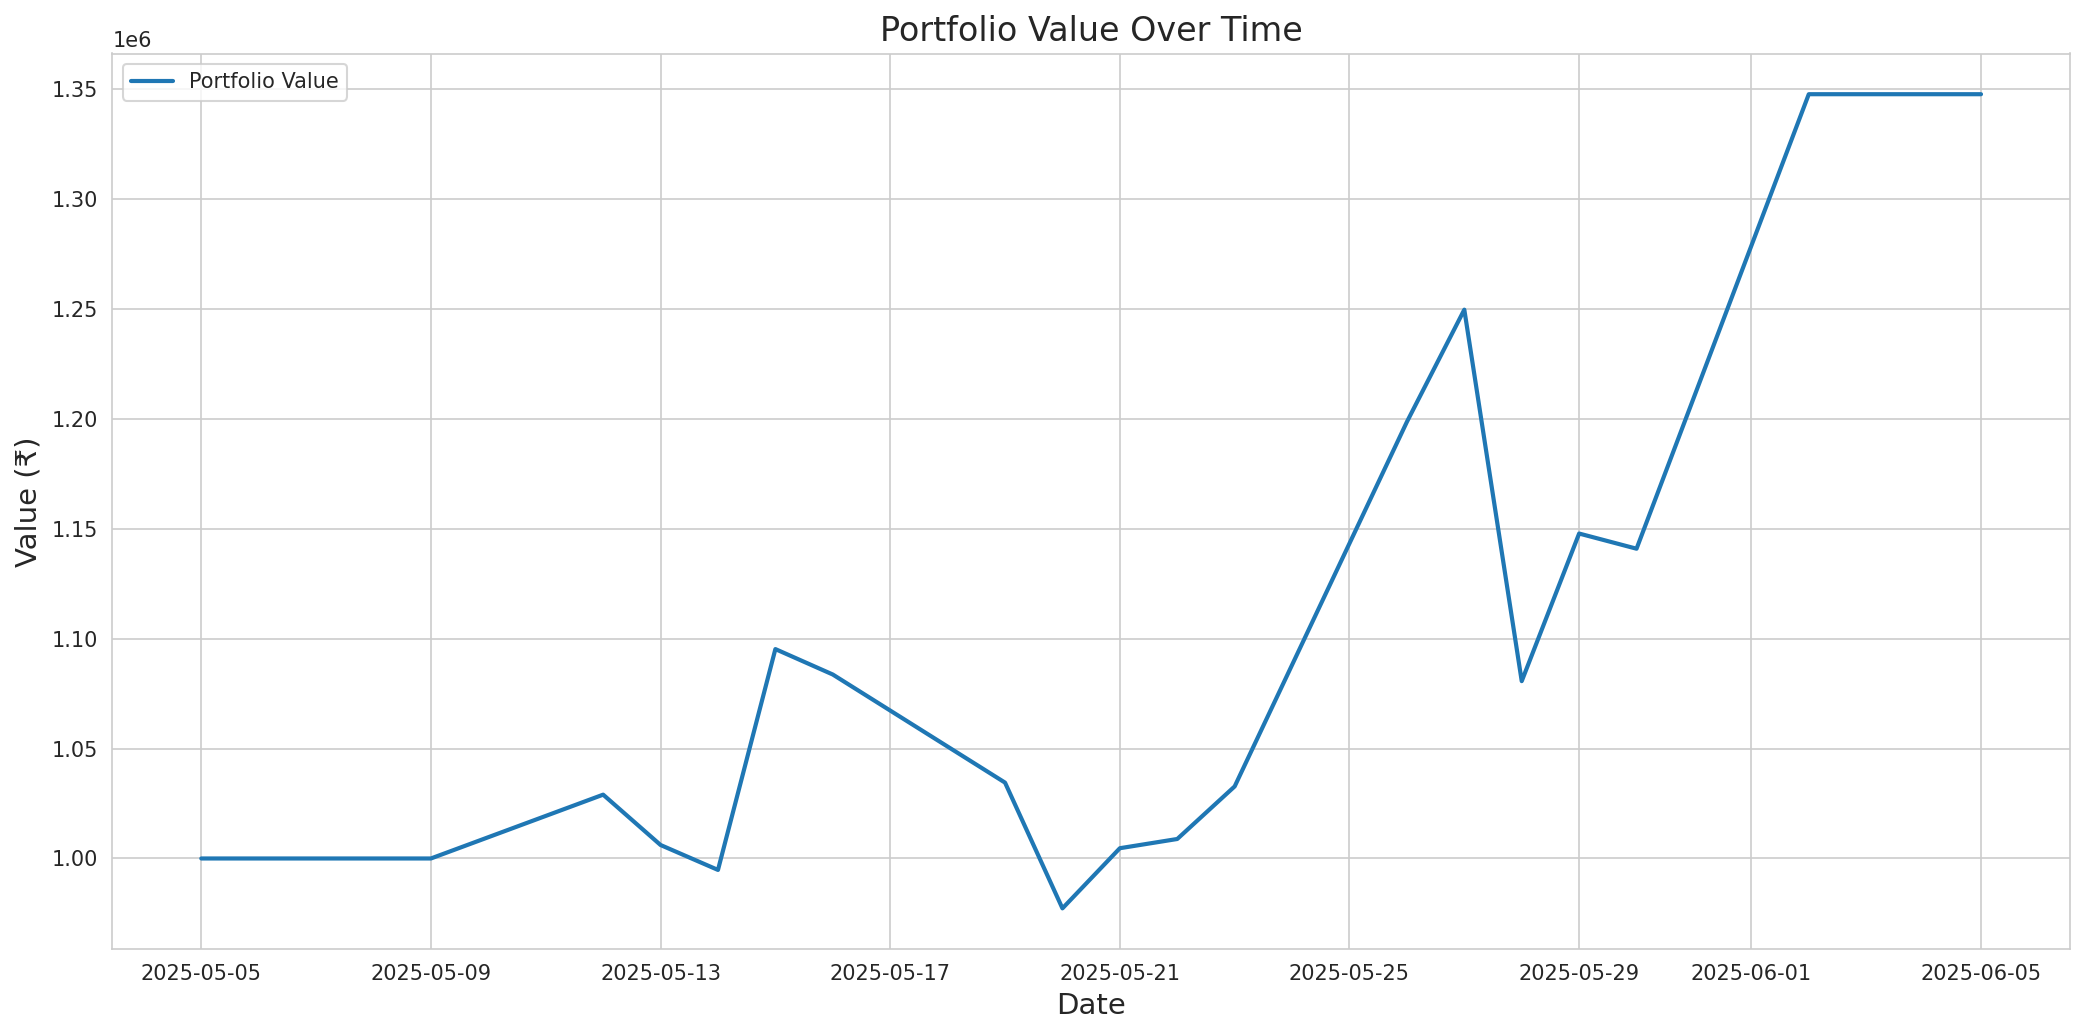

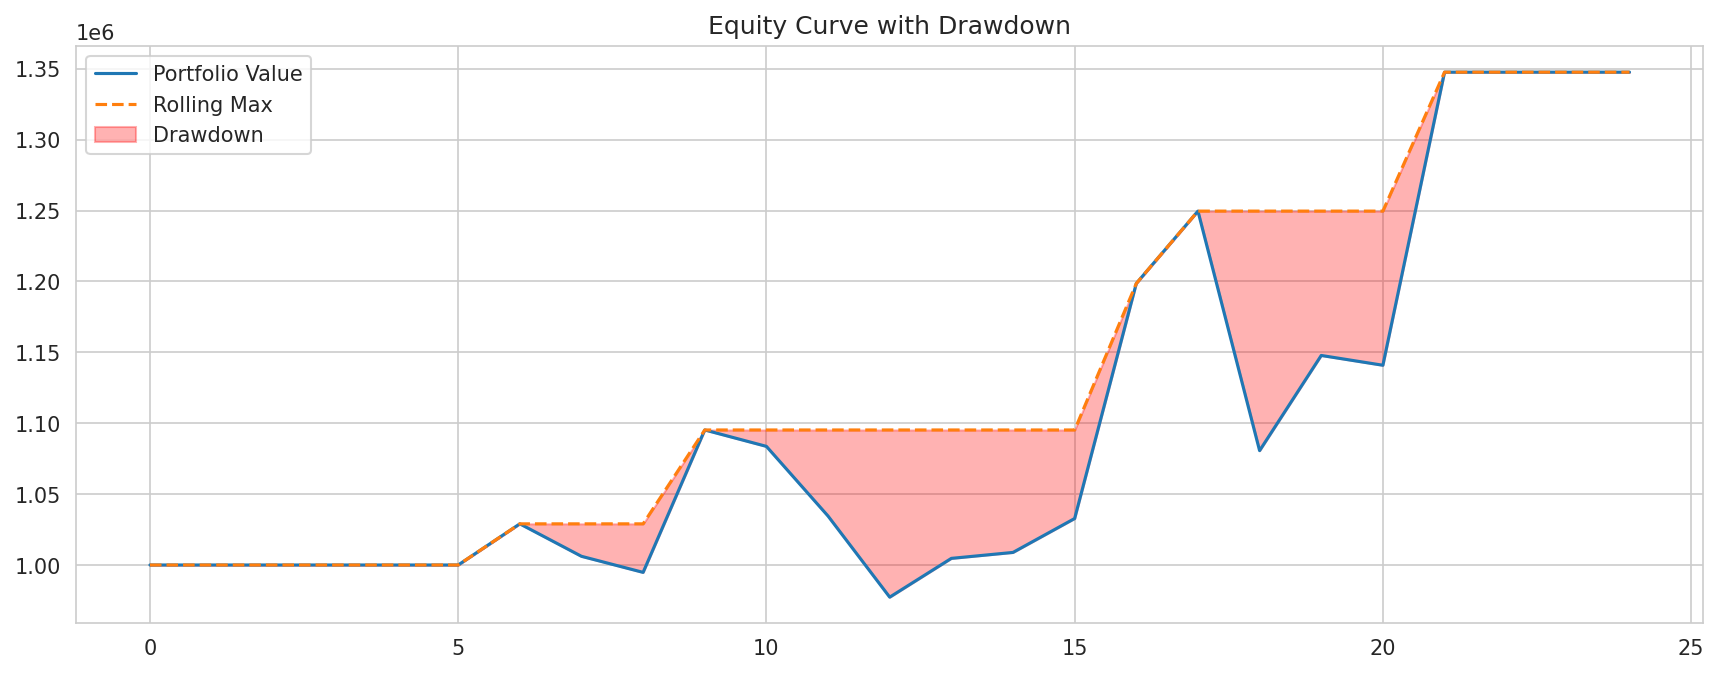

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pandas_ta as ta
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['RSI'] = ta.rsi(nifty_hist['Close'], length=14)
macd = ta.macd(nifty_hist['Close'])
nifty_hist['MACD'] = macd['MACD_12_26_9']
nifty_hist['ATR'] = ta.atr(nifty_hist['High'], nifty_hist['Low'], nifty_hist['Close'], length=14)
# IV Rank proxy using ATR
nifty_hist['IV_Rank'] = (nifty_hist['ATR'] - nifty_hist['ATR'].rolling(14).min()) / (nifty_hist['ATR'].rolling(14).max() - nifty_hist['ATR'].rolling(14).min())
nifty_hist['IV_Rank'] = nifty_hist['IV_Rank'].fillna(0)
nifty_hist = nifty_hist.set_index('Date')

# --- Signal Generation with Confirmation ---
nifty_hist['Signal'] = 0
bullish = (nifty_hist['MA21'] > nifty_hist['MA22']) & (nifty_hist['RSI'] > 50) & (nifty_hist['MACD'] > 0) & (nifty_hist['IV_Rank'] > 0.3)
bearish = (nifty_hist['MA21'] < nifty_hist['MA22']) & (nifty_hist['RSI'] < 60) & (nifty_hist['MACD'] < 1) & (nifty_hist['IV_Rank'] > 0.1)
nifty_hist.loc[bullish, 'Signal'] = 1
nifty_hist.loc[bearish, 'Signal'] = -1

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Parameters ---
STRATEGY_PARAMS = {
    'base_risk': 0.01,
    'min_oi': 50000,
    'lot_size': 50,
    'max_holding_days': 5,
    'atr_multiplier': 1.5,
    'spread_width_pct': 0.10,
    'min_credit_pct': 0.01,
    'commission_per_lot': 20,
    'slippage_pct': 0.001,
    'margin_pct': 0.20,
    'max_drawdown_pct': 0.20,
    'hold_spreads_to_expiry': True
}

initial_capital = 1_000_000
cash = initial_capital
margin_used = 0
open_positions = []
trade_log = []
portfolio_values = [initial_capital]
portfolio_dates = [nifty_hist.index[0]]

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    typ = 'CE' if option_type == 'call' else 'PE'
    price = df[(df['OPTION_TYP'] == typ) & (df['STRIKE_PR'] == strike)][price_type]
    return float(price.iloc[0]) if not price.empty else np.nan

def create_credit_spread(df, spot, option_type, width_pct, lot_size, min_credit_pct):
    atm_strike = round(spot / 50) * 50
    if option_type == 'put':
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 - width_pct) / 50) * 50
    else:
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 + width_pct) / 50) * 50
    sell_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == sell_strike)]
    buy_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == buy_strike)]
    if not sell_opt.empty and not buy_opt.empty:
        sell_price = sell_opt['CLOSE'].values[0]
        buy_price = buy_opt['CLOSE'].values[0]
        net_credit = sell_price - buy_price
        notional = sell_strike * lot_size
        if net_credit >= (notional * min_credit_pct):
            return {
                'sell_strike': sell_strike,
                'buy_strike': buy_strike,
                'sell_price': sell_price,
                'buy_price': buy_price,
                'net_credit': net_credit,
                'margin': abs(sell_strike - buy_strike) * lot_size,
                'valid': True
            }
    return {'valid': False}

def calculate_position_size(atr, base_risk, close_mean):
    volatility_factor = 1 / (1 + (atr / close_mean))
    return max(1, int(base_risk * initial_capital * volatility_factor / 10000))

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT']
        if not all(col in df.columns for col in required_cols):
            continue
        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue
        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue
        # --- Dynamic Risk Management ---
        current_atr = nifty_hist.loc[trade_date, 'ATR']
        close_mean = nifty_hist['Close'].mean()
        dynamic_lots = calculate_position_size(current_atr, STRATEGY_PARAMS['base_risk'], close_mean)
        risk_capital = initial_capital * STRATEGY_PARAMS['base_risk'] * dynamic_lots
        # --- Entry Logic: Both Buy and Sell ---
        if nifty_hist.loc[trade_date, 'Signal'] != 0:
            spot_price = nifty_hist.loc[trade_date, 'Close']
            strategy_type = 'bull' if nifty_hist.loc[trade_date, 'Signal'] > 0 else 'bear'
            if strategy_type == 'bull':
                # Long call
                call_candidates = df[(df['OPTION_TYP'] == 'CE') &
                                     (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                     (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not call_candidates.empty:
                    call = call_candidates.iloc[0]
                    max_lots = min(dynamic_lots, 20)
                    total_cost = call['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': call['STRIKE_PR'],
                            'entry_price': call['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_call'
                        })
                # Put credit spread
                spread = create_credit_spread(
                    df, spot_price, 'put', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'put',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'put_credit_spread'
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'put_credit_spread'
                        })
            else:
                # Long put
                put_candidates = df[(df['OPTION_TYP'] == 'PE') &
                                    (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                    (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not put_candidates.empty:
                    put = put_candidates.iloc[0]
                    max_lots = min(dynamic_lots, 20)
                    total_cost = put['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': put['STRIKE_PR'],
                            'entry_price': put['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_put'
                        })
                # Call credit spread
                spread = create_credit_spread(
                    df, spot_price, 'call', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'call',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'call_credit_spread'
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'call_credit_spread'
                        })
        # --- Exit Logic --- (unchanged)
        positions_to_remove = []
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            holding_days = (trade_date - position['entry_date']).days
            # For spreads, hold to expiry if enabled
            if position.get('spread', False) and STRATEGY_PARAMS['hold_spreads_to_expiry']:
                if holding_days < STRATEGY_PARAMS['max_holding_days']:
                    continue
            # ATR-based stop for long options
            if position['action'] == 'buy':
                stop_loss = position['entry_price'] - (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price <= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            else:
                stop_loss = position['entry_price'] + (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price >= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            if exit_condition:
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)
                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': trade_date,
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'credit_ratio': position.get('credit_ratio', 0),
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': holding_days
                })
                positions_to_remove.append(position)
        for pos in positions_to_remove:
            open_positions.remove(pos)
        # --- Update Portfolio Value ---
        current_value = cash - margin_used
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            if position['action'] == 'buy':
                current_value += price * STRATEGY_PARAMS['lot_size'] * position['lots']
            else:
                current_value -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
        portfolio_values.append(current_value)
        portfolio_dates.append(trade_date)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Save trade log to Google Drive at the end ---
if len(trade_log) > 0:
    pd.DataFrame(trade_log).to_csv('/content/drive/MyDrive/Options_Data/full_trade_log.csv', index=False)
    print("Trade log saved to /content/drive/MyDrive/Options_Data/full_trade_log.csv")
else:
    print("No trades to log.")

# --- Performance Analysis ---
returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01  # risk-free rate
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = abs(drawdown.min()) * initial_capital
years = len(portfolio_values) / 252
cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
""")

# --- Visualizations ---
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(portfolio_dates[1:], portfolio_values[1:], label='Portfolio Value', linewidth=2)
plt.title('Portfolio Value Over Time', fontsize=16)
plt.ylabel('Value (₹)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(cumulative, label='Portfolio Value')
plt.plot(rolling_max, '--', label='Rolling Max')
plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Equity Curve with Drawdown")
plt.legend()
plt.show()

# --- Enhanced Performance Analysis ---
def analyze_strategy_performance(trade_log):
    trades = pd.DataFrame(trade_log)
    if trades.empty:
        print("No trades to analyze")
        return
    # Strategy Type Analysis
    if 'strategy_type' in trades.columns:
        print("\nStrategy Type Performance:")
        print(trades.groupby('strategy_type')['pnl'].describe())
    else:
        print("\nStrategy type data missing")
    # Volatility Analysis
    if 'volatility' in trades.columns:
        print("\nVolatility Regime Performance:")
        median_vol = trades['volatility'].median()
        high_count = len(trades[trades['volatility'] > median_vol])
        low_count = len(trades[trades['volatility'] <= median_vol])
        print(f"High Volatility Trades: {high_count}")
        print(f"Low Volatility Trades: {low_count}")
        print("\nVolatility Distribution:")
        print(pd.cut(trades['volatility'], bins=3).value_counts().sort_index())
    else:
        print("\nVolatility data not found in trade log")
    # Credit Ratio Analysis
    if 'credit_ratio' in trades.columns and not trades.empty:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=trades, x='credit_ratio', y='pnl', hue='strategy_type')
        plt.title('Credit Ratio vs PnL by Strategy Type')
        plt.show()
    else:
        print("\nCredit ratio data not available for plotting")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Strategy Performance Report:
-----------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹1,347,622.50
Total Return:       34.76%
Max Drawdown:       ₹135,216.56
Sharpe Ratio:       3.54
Sortino Ratio:      5.01
Calmar Ratio:       142.23



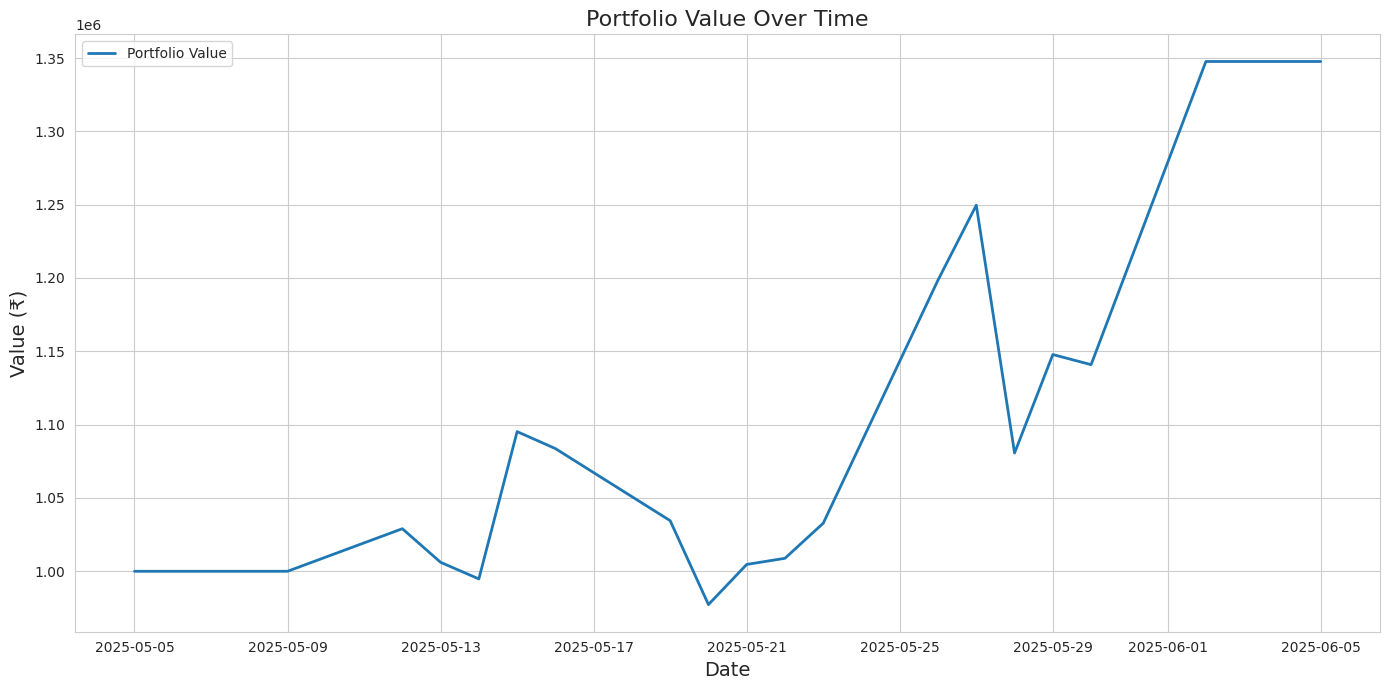

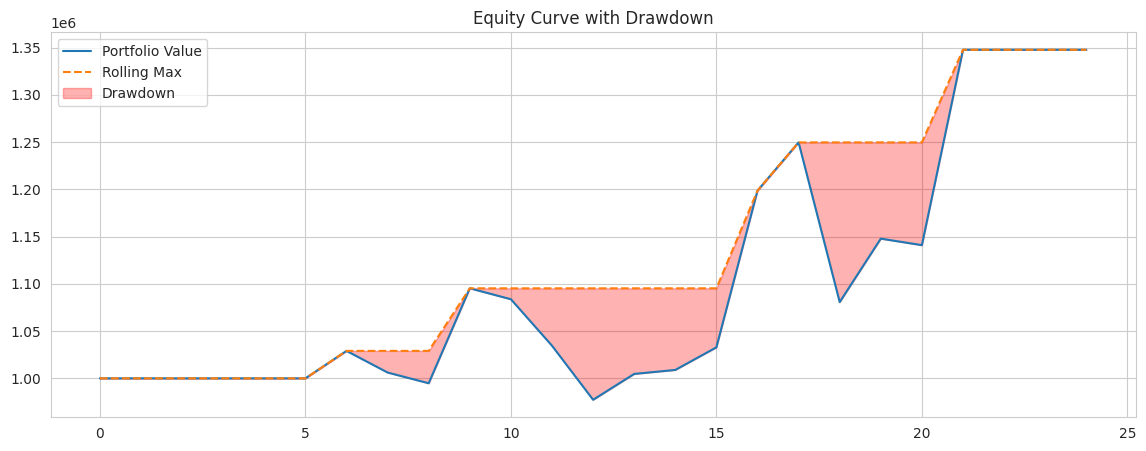

Trade log saved to /content/drive/MyDrive/Options_Data/enhanced_full_trade_log.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pandas_ta as ta
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['RSI'] = ta.rsi(nifty_hist['Close'], length=14)
macd = ta.macd(nifty_hist['Close'])
nifty_hist['MACD'] = macd['MACD_12_26_9']
nifty_hist['ATR'] = ta.atr(nifty_hist['High'], nifty_hist['Low'], nifty_hist['Close'], length=14)
# IV Rank proxy using ATR
nifty_hist['IV_Rank'] = (nifty_hist['ATR'] - nifty_hist['ATR'].rolling(14).min()) / (nifty_hist['ATR'].rolling(14).max() - nifty_hist['ATR'].rolling(14).min())
nifty_hist['IV_Rank'] = nifty_hist['IV_Rank'].fillna(0)
nifty_hist = nifty_hist.set_index('Date')

# --- Signal Generation with Confirmation ---
nifty_hist['Signal'] = 0
bullish = (nifty_hist['MA21'] > nifty_hist['MA22']) & (nifty_hist['RSI'] > 50) & (nifty_hist['MACD'] > 0) & (nifty_hist['IV_Rank'] > 0.3)
bearish = (nifty_hist['MA21'] < nifty_hist['MA22']) & (nifty_hist['RSI'] < 60) & (nifty_hist['MACD'] < 1) & (nifty_hist['IV_Rank'] > 0.1)
nifty_hist.loc[bullish, 'Signal'] = 1
nifty_hist.loc[bearish, 'Signal'] = -1

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Parameters ---
STRATEGY_PARAMS = {
    'base_risk': 0.01,
    'min_oi': 50000,
    'lot_size': 50,
    'max_holding_days': 5,
    'atr_multiplier': 1.5,
    'spread_width_pct': 0.10,
    'min_credit_pct': 0.01,
    'commission_per_lot': 20,
    'slippage_pct': 0.001,
    'margin_pct': 0.20,
    'max_drawdown_pct': 0.20,
    'hold_spreads_to_expiry': True
}

initial_capital = 1_000_000
cash = initial_capital
margin_used = 0
open_positions = []
trade_log = []
portfolio_values = [initial_capital]
portfolio_dates = [nifty_hist.index[0]]

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    typ = 'CE' if option_type == 'call' else 'PE'
    price = df[(df['OPTION_TYP'] == typ) & (df['STRIKE_PR'] == strike)][price_type]
    return float(price.iloc[0]) if not price.empty else np.nan

def create_credit_spread(df, spot, option_type, width_pct, lot_size, min_credit_pct):
    atm_strike = round(spot / 50) * 50
    if option_type == 'put':
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 - width_pct) / 50) * 50
    else:
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 + width_pct) / 50) * 50
    sell_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == sell_strike)]
    buy_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == buy_strike)]
    if not sell_opt.empty and not buy_opt.empty:
        sell_price = sell_opt['CLOSE'].values[0]
        buy_price = buy_opt['CLOSE'].values[0]
        net_credit = sell_price - buy_price
        notional = sell_strike * lot_size
        if net_credit >= (notional * min_credit_pct):
            return {
                'sell_strike': sell_strike,
                'buy_strike': buy_strike,
                'sell_price': sell_price,
                'buy_price': buy_price,
                'net_credit': net_credit,
                'margin': abs(sell_strike - buy_strike) * lot_size,
                'valid': True
            }
    return {'valid': False}

def calculate_position_size(atr, base_risk, close_mean):
    volatility_factor = 1 / (1 + (atr / close_mean))
    return max(1, int(base_risk * initial_capital * volatility_factor / 10000))

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT']
        if not all(col in df.columns for col in required_cols):
            continue
        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue
        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], format='%d-%b-%Y')
        if trade_date not in nifty_hist.index:
            continue
        # --- Dynamic Risk Management ---
        current_atr = nifty_hist.loc[trade_date, 'ATR']
        close_mean = nifty_hist['Close'].mean()
        dynamic_lots = calculate_position_size(current_atr, STRATEGY_PARAMS['base_risk'], close_mean)
        risk_capital = initial_capital * STRATEGY_PARAMS['base_risk'] * dynamic_lots
        # --- Entry Logic: Both Buy and Sell ---
        if nifty_hist.loc[trade_date, 'Signal'] != 0:
            spot_price = nifty_hist.loc[trade_date, 'Close']
            strategy_type = 'bull' if nifty_hist.loc[trade_date, 'Signal'] > 0 else 'bear'
            if strategy_type == 'bull':
                # Long call
                call_candidates = df[(df['OPTION_TYP'] == 'CE') &
                                     (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                     (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not call_candidates.empty:
                    call = call_candidates.iloc[0]
                    max_lots = min(dynamic_lots, 20)
                    total_cost = call['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': call['STRIKE_PR'],
                            'entry_price': call['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_call'
                        })
                # Put credit spread
                spread = create_credit_spread(
                    df, spot_price, 'put', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'put',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'put_credit_spread'
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'put_credit_spread'
                        })
            else:
                # Long put
                put_candidates = df[(df['OPTION_TYP'] == 'PE') &
                                    (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                    (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not put_candidates.empty:
                    put = put_candidates.iloc[0]
                    max_lots = min(dynamic_lots, 20)
                    total_cost = put['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': put['STRIKE_PR'],
                            'entry_price': put['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_put'
                        })
                # Call credit spread
                spread = create_credit_spread(
                    df, spot_price, 'call', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'call',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'call_credit_spread'
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'call_credit_spread'
                        })
        # --- Exit Logic --- (unchanged)
        positions_to_remove = []
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            holding_days = (trade_date - position['entry_date']).days
            # For spreads, hold to expiry if enabled
            if position.get('spread', False) and STRATEGY_PARAMS['hold_spreads_to_expiry']:
                if holding_days < STRATEGY_PARAMS['max_holding_days']:
                    continue
            # ATR-based stop for long options
            if position['action'] == 'buy':
                stop_loss = position['entry_price'] - (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price <= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            else:
                stop_loss = position['entry_price'] + (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price >= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            if exit_condition:
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)
                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': trade_date,
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'credit_ratio': position.get('credit_ratio', 0),
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': holding_days
                })
                positions_to_remove.append(position)
        for pos in positions_to_remove:
            open_positions.remove(pos)
        # --- Update Portfolio Value ---
        current_value = cash - margin_used
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            if position['action'] == 'buy':
                current_value += price * STRATEGY_PARAMS['lot_size'] * position['lots']
            else:
                current_value -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
        portfolio_values.append(current_value)
        portfolio_dates.append(trade_date)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Performance Analysis ---
returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01  # risk-free rate
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = abs(drawdown.min()) * initial_capital
years = len(portfolio_values) / 252
cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
""")

# --- Visualizations ---
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(portfolio_dates[1:], portfolio_values[1:], label='Portfolio Value', linewidth=2)
plt.title('Portfolio Value Over Time', fontsize=16)
plt.ylabel('Value (₹)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(cumulative, label='Portfolio Value')
plt.plot(rolling_max, '--', label='Rolling Max')
plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Equity Curve with Drawdown")
plt.legend()
plt.show()

# --- Enhanced Performance Analysis ---
def analyze_strategy_performance(trade_log):
    trades = pd.DataFrame(trade_log)
    if trades.empty:
        print("No trades to analyze")
        return
    # Strategy Type Analysis
    if 'strategy_type' in trades.columns:
        print("\nStrategy Type Performance:")
        print(trades.groupby('strategy_type')['pnl'].describe())
    else:
        print("\nStrategy type data missing")
    # Volatility Analysis
    if 'volatility' in trades.columns:
        print("\nVolatility Regime Performance:")
        median_vol = trades['volatility'].median()
        high_count = len(trades[trades['volatility'] > median_vol])
        low_count = len(trades[trades['volatility'] <= median_vol])
        print(f"High Volatility Trades: {high_count}")
        print(f"Low Volatility Trades: {low_count}")
        print("\nVolatility Distribution:")
        print(pd.cut(trades['volatility'], bins=3).value_counts().sort_index())
    else:
        print("\nVolatility data not found in trade log")
    # Credit Ratio Analysis
    if 'credit_ratio' in trades.columns and not trades.empty:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=trades, x='credit_ratio', y='pnl', hue='strategy_type')
        plt.title('Credit Ratio vs PnL by Strategy Type')
        plt.show()
    else:
        print("\nCredit ratio data not available for plotting")


# --- Save trade log to Google Drive at the end ---
if len(trade_log) > 0:
    pd.DataFrame(trade_log).to_csv('/content/drive/MyDrive/Options_Data/enhanced_full_trade_log.csv', index=False)
    print("Trade log saved to /content/drive/MyDrive/Options_Data/enhanced_full_trade_log.csv")
else:
    print("No trades to log.")


In [ ]:
import pandas as pd

# Define your backtesting period
start_date = pd.to_datetime('2025-01-05')
end_date = pd.to_datetime('2025-06-05')

# Filter for bearish signals within the backtesting period
bearish_signals_period = nifty_hist[
    (nifty_hist.index >= start_date) &
    (nifty_hist.index <= end_date) &
    (nifty_hist['Signal'] == -1)
]

# Extract and print dates
bearish_dates = bearish_signals_period.index
print("Dates with Signal = -1 (Bearish) during backtest period:")
for dt in bearish_dates:
    print(dt.strftime('%Y-%m-%d'))

# Print indicator values for those dates (first 20 for brevity)
print(bearish_signals_period[['MA21', 'MA22', 'RSI', 'MACD', 'IV_Rank', 'Signal']])


Dates with Signal = -1 (Bearish) during backtest period:
2025-01-06
2025-01-07
2025-01-08
2025-01-09
2025-01-10
2025-01-13
2025-01-14
2025-01-21
2025-01-22
2025-01-24
2025-01-27
2025-01-28
2025-01-29
2025-01-31
2025-02-01
2025-02-03
2025-02-04
2025-02-05
2025-02-13
2025-02-17
2025-02-28
2025-03-03
2025-03-04
2025-03-05
2025-03-06
2025-03-07
2025-03-10
2025-03-11
2025-03-12
2025-03-13
2025-03-17
2025-03-18
2025-03-19
                    MA21          MA22        RSI        MACD   IV_Rank  \
Date                                                                      
2025-01-06  24118.795238  24145.595455  40.695035 -137.994842  1.000000   
2025-01-07  24072.609524  24100.118182  43.001935 -142.491737  0.675904   
2025-01-08  24028.321429  24055.170455  42.633464 -145.902789  0.572749   
2025-01-09  23976.723810  24005.511364  39.508128 -159.871530  0.298034   
2025-01-10  23919.090476  23951.940909  37.764636 -176.572150  0.212956   
2025-01-13  23849.435714  23881.220455  32.198639 -215.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error processing /content/drive/MyDrive/Options_Data/Bhavcopy/20250516_NSEFO.csv: time data "05-Jun-2025" doesn't match format "%d-%B-%Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Trade log saved to /content/drive/MyDrive/Options_Data/trade_log_2.csv

Strategy Performance Report:
+-------------------+---------------+
| Metric            | Value         |
+===================+===============+
| Initial Capital   | ₹1,000,000.00 |
+-------------------+---------------+
| Final Portfolio   | ₹1,313,757.50 |
+-------------------+---------------+
| Tot

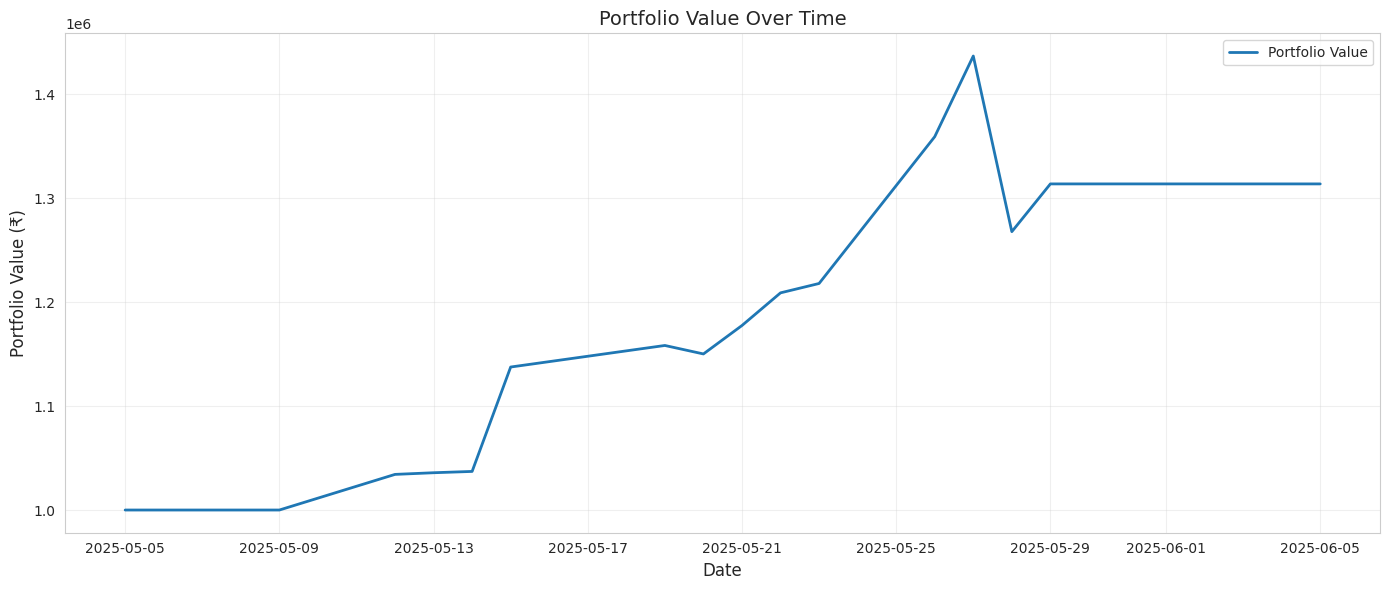

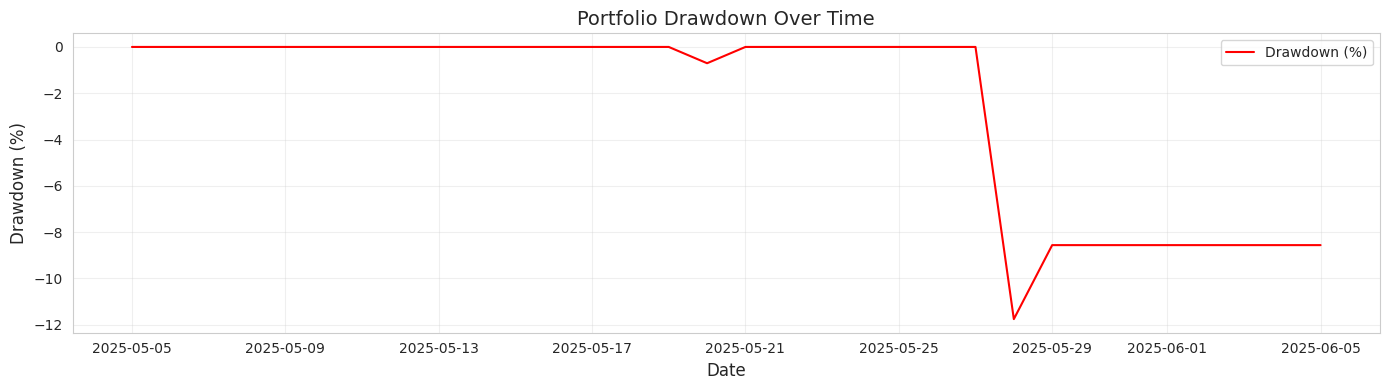

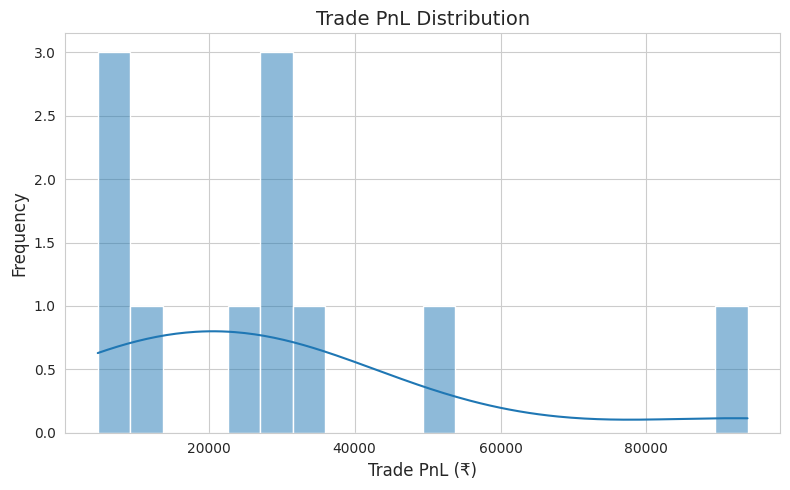

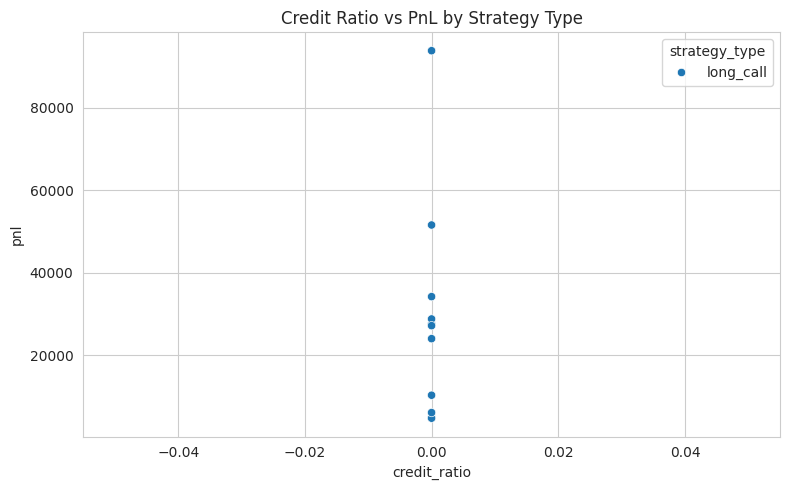

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pandas_ta as ta
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tabulate import tabulate
# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['RSI'] = ta.rsi(nifty_hist['Close'], length=14)
macd = ta.macd(nifty_hist['Close'])
nifty_hist['MACD'] = macd['MACD_12_26_9']
nifty_hist['ATR'] = ta.atr(nifty_hist['High'], nifty_hist['Low'], nifty_hist['Close'], length=14)
nifty_hist['IV_Rank'] = (nifty_hist['ATR'] - nifty_hist['ATR'].rolling(14).min()) / (nifty_hist['ATR'].rolling(14).max() - nifty_hist['ATR'].rolling(14).min())
nifty_hist['IV_Rank'] = nifty_hist['IV_Rank'].fillna(0)
nifty_hist = nifty_hist.set_index('Date')

# --- Signal Generation with Looser Bearish ---
nifty_hist['Signal'] = 0
bullish = (nifty_hist['MA21'] > nifty_hist['MA22']) & (nifty_hist['RSI'] > 50) & (nifty_hist['MACD'] > 0) & (nifty_hist['IV_Rank'] > 0.3)
bearish = (nifty_hist['MA21'] < nifty_hist['MA22']) & (nifty_hist['RSI'] < 60) & (nifty_hist['MACD'] < 1) & (nifty_hist['IV_Rank'] > 0.1)
nifty_hist.loc[bullish, 'Signal'] = 1
nifty_hist.loc[bearish, 'Signal'] = -1

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Parameters ---
STRATEGY_PARAMS = {
    'base_risk': 0.01,
    'min_oi': 50000,
    'lot_size': 50,
    'max_holding_days': 5,
    'atr_multiplier': 1.5,
    'spread_width_pct': 0.10,
    'min_credit_pct': 0.01,
    'commission_per_lot': 20,
    'slippage_pct': 0.001,
    'margin_pct': 0.20,
    'max_drawdown_pct': 0.20,
    'hold_spreads_to_expiry': True
}

initial_capital = 1_000_000
cash = initial_capital
margin_used = 0
open_positions = []
trade_log = []
portfolio_values = [initial_capital]
portfolio_dates = [nifty_hist.index[0]]

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    typ = 'CE' if option_type == 'call' else 'PE'
    price = df[(df['OPTION_TYP'] == typ) & (df['STRIKE_PR'] == strike)][price_type]
    return float(price.iloc[0]) if not price.empty else np.nan

def create_credit_spread(df, spot, option_type, width_pct, lot_size, min_credit_pct):
    atm_strike = round(spot / 50) * 50
    if option_type == 'put':
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 - width_pct) / 50) * 50
    else:
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 + width_pct) / 50) * 50
    sell_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == sell_strike)]
    buy_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == buy_strike)]
    if not sell_opt.empty and not buy_opt.empty:
        sell_price = sell_opt['CLOSE'].values[0]
        buy_price = buy_opt['CLOSE'].values[0]
        net_credit = sell_price - buy_price
        notional = sell_strike * lot_size
        if net_credit >= (notional * min_credit_pct):
            return {
                'sell_strike': sell_strike,
                'buy_strike': buy_strike,
                'sell_price': sell_price,
                'buy_price': buy_price,
                'net_credit': net_credit,
                'margin': abs(sell_strike - buy_strike) * lot_size,
                'valid': True
            }
    return {'valid': False}

def calculate_position_size(atr, base_risk, close_mean):
    volatility_factor = 1 / (1 + (atr / close_mean))
    return max(1, int(base_risk * initial_capital * volatility_factor / 10000))

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT', 'EXPIRY_DT']
        if not all(col in df.columns for col in required_cols):
            continue
        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue
        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], dayfirst=True, errors='coerce')
        if trade_date not in nifty_hist.index:
            continue
        spot_price = nifty_hist.loc[trade_date, 'Close']
        expiry_series = pd.to_datetime(df['EXPIRY_DT'].unique(), dayfirst=True, errors='coerce')
        if len(expiry_series) == 0:
            continue
        nearest_expiry = expiry_series[expiry_series >= trade_date].min()
        current_atr = nifty_hist.loc[trade_date, 'ATR']
        close_mean = nifty_hist['Close'].mean()
        dynamic_lots = calculate_position_size(current_atr, STRATEGY_PARAMS['base_risk'], close_mean)
        risk_capital = initial_capital * STRATEGY_PARAMS['base_risk'] * dynamic_lots
        if nifty_hist.loc[trade_date, 'Signal'] != 0:
            strategy_type = 'bull' if nifty_hist.loc[trade_date, 'Signal'] > 0 else 'bear'
            max_lots = min(dynamic_lots, 20)
            if strategy_type == 'bull':
                # Long call
                call_candidates = df[(df['OPTION_TYP'] == 'CE') &
                                     (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                     (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi']) &
                                     (pd.to_datetime(df['EXPIRY_DT']) == nearest_expiry)]
                if not call_candidates.empty:
                    call = call_candidates.iloc[0]
                    total_cost = call['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': call['STRIKE_PR'],
                            'entry_price': call['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_call',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })
                # Put credit spread
                spread = create_credit_spread(
                    df, spot_price, 'put', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'put',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'put_credit_spread',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'put_credit_spread',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })
            else:
                # Long put
                put_candidates = df[(df['OPTION_TYP'] == 'PE') &
                                    (df['STRIKE_PR'] == round(spot_price/50)*50) &
                                    (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi']) &
                                    (pd.to_datetime(df['EXPIRY_DT']) == nearest_expiry)]
                if not put_candidates.empty:
                    put = put_candidates.iloc[0]
                    total_cost = put['CLOSE'] * STRATEGY_PARAMS['lot_size'] * max_lots
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': put['STRIKE_PR'],
                            'entry_price': put['CLOSE'],
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_put',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })
                # Call credit spread
                spread = create_credit_spread(
                    df, spot_price, 'call', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'sell',
                            'type': 'call',
                            'strike': spread['sell_strike'],
                            'entry_price': spread['sell_price'],
                            'lots': max_lots,
                            'margin': margin,
                            'spread': True,
                            'paired_strike': spread['buy_strike'],
                            'paired_entry_price': spread['buy_price'],
                            'strategy_type': 'call_credit_spread',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': spread['buy_strike'],
                            'entry_price': spread['buy_price'],
                            'lots': max_lots,
                            'margin': 0,
                            'spread': True,
                            'paired_strike': spread['sell_strike'],
                            'paired_entry_price': spread['sell_price'],
                            'strategy_type': 'call_credit_spread',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })
        # --- Exit Logic ---
        positions_to_remove = []
        for position in open_positions:
            current_expiry = position.get('expiry', pd.NaT)

            # CRITICAL: Force exit if we've reached or passed expiry
            if not pd.isna(current_expiry) and trade_date >= current_expiry:
                # Force exit at expiry
                price = get_option_price(df, position['strike'], position['type'])
                if np.isnan(price):
                    # If no price data on expiry, use intrinsic value
                    spot_on_expiry = nifty_hist.loc[trade_date, 'Close'] if trade_date in nifty_hist.index else position['spot']
                    if position['type'] == 'call':
                        price = max(0, spot_on_expiry - position['strike'])
                    else:
                        price = max(0, position['strike'] - spot_on_expiry)

                # Calculate PnL and exit
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)

                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': current_expiry,  # Exit ON expiry, not after
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'credit_ratio': position.get('credit_ratio', 0),
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': (current_expiry - position['entry_date']).days,
                    'spot': position.get('spot', np.nan),
                    'expiry': current_expiry,
                    'exit_reason': 'expiry'
                })
                positions_to_remove.append(position)
                continue
        for pos in positions_to_remove:
            open_positions.remove(pos)
        current_value = cash - margin_used
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            if position['action'] == 'buy':
                current_value += price * STRATEGY_PARAMS['lot_size'] * position['lots']
            else:
                current_value -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
        portfolio_values.append(current_value)
        portfolio_dates.append(trade_date)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Save trade log to Google Drive at the end ---
if len(trade_log) > 0:
    pd.DataFrame(trade_log).to_csv('/content/drive/MyDrive/Options_Data/trade_log_2.csv', index=False)
    print("Trade log saved to /content/drive/MyDrive/Options_Data/trade_log_2.csv")
else:
    print("No trades to log.")

# --- Load trade log from file (if not already in memory) ---
trade_log_df = pd.DataFrame(trade_log)
portfolio_vals = portfolio_values

# --- Calculate Returns and Metrics ---
returns = pd.Series(portfolio_vals).pct_change().dropna()
initial_capital = portfolio_vals[0]
final_portfolio = portfolio_vals[-1]
total_return = (final_portfolio / initial_capital - 1) * 100

# Max drawdown calculation
cumulative = pd.Series(portfolio_vals)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = abs(drawdown.min()) * initial_capital

# Sharpe ratio (assuming risk free rate ~1% annualized)
rf = 0.01
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0

# Sortino ratio
neg_returns = returns[returns < 0]
downside_std = neg_returns.std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0

# Calmar ratio
years = len(portfolio_vals) / 252
cagr = (final_portfolio / initial_capital) ** (1/years) - 1 if years > 0 else 0
calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

# Trade statistics
total_trades = len(trade_log_df)
profitable_trades = trade_log_df[trade_log_df['pnl'] > 0]
num_profitable = len(profitable_trades)
win_rate = (num_profitable / total_trades) * 100 if total_trades > 0 else 0

avg_win = profitable_trades['pnl'].mean() if num_profitable > 0 else 0
avg_loss = trade_log_df[trade_log_df['pnl'] <= 0]['pnl'].mean() if total_trades - num_profitable > 0 else 0
expectancy = (win_rate/100) * avg_win + ((100 - win_rate)/100) * avg_loss

# --- Print Detailed Strategy Performance Report ---
performance_table = [
    ["Initial Capital", f"₹{initial_capital:,.2f}"],
    ["Final Portfolio", f"₹{final_portfolio:,.2f}"],
    ["Total Return", f"{total_return:.2f}%"],
    ["Max Drawdown", f"₹{max_drawdown:,.2f}"],
    ["Sharpe Ratio", f"{sharpe:.2f}"],
    ["Sortino Ratio", f"{sortino:.2f}"],
    ["Calmar Ratio", f"{calmar:.2f}"],
    ["Total Trades", total_trades],
    ["Profitable Trades", f"{num_profitable} ({win_rate:.1f}%)"],
    ["Avg Win", f"₹{avg_win:,.2f}"],
    ["Avg Loss", f"₹{avg_loss:,.2f}"],
    ["Expectancy", f"₹{expectancy:,.2f}"]
]

print("\n" + "="*50)
print("Strategy Performance Report:")
print(tabulate(performance_table, headers=["Metric", "Value"], tablefmt="grid"))
print("="*50)

# --- Strategy Type Performance Table ---
if 'strategy_type' in trade_log_df.columns:
    strategy_perf = trade_log_df.groupby('strategy_type')['pnl'].describe().reset_index()
    print("\nStrategy Performance Breakdown by Type:")
    print(tabulate(strategy_perf, headers="keys", tablefmt="grid", showindex=False))

# --- Volatility Regime Performance ---
if 'volatility' in trade_log_df.columns:
    median_vol = trade_log_df['volatility'].median()
    high_vol_trades = trade_log_df[trade_log_df['volatility'] > median_vol]
    low_vol_trades = trade_log_df[trade_log_df['volatility'] <= median_vol]
    print("\nVolatility Regime Performance:")
    print(tabulate([
        ["High Volatility Trades", len(high_vol_trades)],
        ["Low Volatility Trades", len(low_vol_trades)]
    ], headers=["Regime", "Count"], tablefmt="grid"))
    # Volatility distribution
    vol_bins = pd.cut(trade_log_df['volatility'], bins=3).value_counts().sort_index()
    print("\nVolatility Distribution (by bin):")
    print(tabulate(
        pd.DataFrame({'Volatility Bin': vol_bins.index.astype(str), 'Trades': vol_bins.values}),
        headers="keys", tablefmt="grid", showindex=False
    ))

# --- Visualizations ---

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(portfolio_dates[1:], portfolio_vals[1:], label='Portfolio Value', linewidth=2)
plt.title("Portfolio Value Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (₹)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

# Drawdown plot
plt.figure(figsize=(14, 4))
plt.plot(portfolio_dates[1:], drawdown[1:] * 100, color='red', label='Drawdown (%)')
plt.title("Portfolio Drawdown Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Drawdown (%)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

# PnL histogram
plt.figure(figsize=(8, 5))
sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
plt.title("Trade PnL Distribution", fontsize=14)
plt.xlabel("Trade PnL (₹)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Credit ratio vs PnL (if present)
if 'credit_ratio' in trade_log_df.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=trade_log_df, x='credit_ratio', y='pnl', hue='strategy_type')
    plt.title('Credit Ratio vs PnL by Strategy Type')
    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pandas_ta as ta
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tabulate import tabulate

# --- Enhanced Style Setup ---
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
colors = sns.color_palette("husl")

# --- Realistic Trading Parameters ---
COMMISSION_PER_LOT = 40  # Increased from 20 to account for brokerage + taxes
SLIPPAGE_PCT = 0.005     # 0.5% slippage for options
MIN_DAYS_TO_EXPIRY = 3   # Don't trade options with <3 days to expiry

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')

# --- Enhanced Indicators ---
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['RSI'] = ta.rsi(nifty_hist['Close'], length=14)
macd = ta.macd(nifty_hist['Close'])
nifty_hist['MACD'] = macd['MACD_12_26_9']
nifty_hist['ATR'] = ta.atr(nifty_hist['High'], nifty_hist['Low'], nifty_hist['Close'], length=14)
nifty_hist['IV_Rank'] = (nifty_hist['ATR'] - nifty_hist['ATR'].rolling(252).min()) / (nifty_hist['ATR'].rolling(252).max() - nifty_hist['ATR'].rolling(252).min())
nifty_hist['IV_Rank'] = nifty_hist['IV_Rank'].fillna(0)
nifty_hist = nifty_hist.set_index('Date')

# --- Realistic Signal Generation ---
nifty_hist['Signal'] = 0
bullish = (
    (nifty_hist['MA21'] > nifty_hist['MA22']) &
    (nifty_hist['RSI'] > 45) &  # Looser filter
    (nifty_hist['MACD'] > -25) &  # Allow some negative MACD
    (nifty_hist['IV_Rank'] > 0.25)
)
bearish = (
    (nifty_hist['MA21'] < nifty_hist['MA22']) &
    (nifty_hist['RSI'] < 55) &
    (nifty_hist['MACD'] < 25) &
    (nifty_hist['IV_Rank'] > 0.25)
)
nifty_hist.loc[bullish, 'Signal'] = 1
nifty_hist.loc[bearish, 'Signal'] = -1

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Realistic Strategy Parameters ---
STRATEGY_PARAMS = {
    'base_risk': 0.02,  # Increased risk for diversification
    'min_oi': 75000,    # Higher OI filter for liquidity
    'lot_size': 50,
    'max_holding_days': 3,  # Shorter holding period
    'atr_multiplier': 2.0,  # Tighter stops
    'spread_width_pct': 0.15,
    'min_credit_pct': 0.015,
    'commission_per_lot': COMMISSION_PER_LOT,
    'slippage_pct': SLIPPAGE_PCT,
    'margin_pct': 0.30,
    'max_drawdown_pct': 0.25,
    'hold_spreads_to_expiry': False
}

initial_capital = 1_000_000
cash = initial_capital
margin_used = 0
open_positions = []
trade_log = []
portfolio_values = [initial_capital]
portfolio_dates = [nifty_hist.index[0]]

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    """Get option price with liquidity checks"""
    typ = 'CE' if option_type == 'call' else 'PE'
    option_data = df[(df['OPTION_TYP'] == typ) & (df['STRIKE_PR'] == strike)]

    if option_data.empty:
        return np.nan

    # Check liquidity
    if option_data['VOLUME'].values[0] < 100 or option_data['OPEN_INT'].values[0] < STRATEGY_PARAMS['min_oi']:
        return np.nan

    return option_data[price_type].values[0] * (1 + np.random.uniform(-SLIPPAGE_PCT, SLIPPAGE_PCT))

def create_credit_spread(df, spot, option_type, width_pct, lot_size, min_credit_pct):
    """Create spread with realistic liquidity checks"""
    atm_strike = round(spot / 50) * 50
    if option_type == 'put':
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 - width_pct) / 50) * 50
    else:
        sell_strike = atm_strike
        buy_strike = round(atm_strike * (1 + width_pct) / 50) * 50

    # Check strike distances
    if abs(sell_strike - buy_strike) < 100:
        return {'valid': False}

    sell_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == sell_strike)]
    buy_opt = df[(df['OPTION_TYP'] == ('CE' if option_type=='call' else 'PE')) & (df['STRIKE_PR'] == buy_strike)]

    if not sell_opt.empty and not buy_opt.empty:
        sell_price = sell_opt['CLOSE'].values[0] * (1 + np.random.uniform(-SLIPPAGE_PCT, SLIPPAGE_PCT))
        buy_price = buy_opt['CLOSE'].values[0] * (1 + np.random.uniform(SLIPPAGE_PCT, SLIPPAGE_PCT))
        net_credit = sell_price - buy_price
        notional = sell_strike * lot_size

        if net_credit >= (notional * min_credit_pct):
            return {
                'sell_strike': sell_strike,
                'buy_strike': buy_strike,
                'sell_price': sell_price,
                'buy_price': buy_price,
                'net_credit': net_credit,
                'margin': abs(sell_strike - buy_strike) * lot_size,
                'valid': True
            }
    return {'valid': False}

def calculate_position_size(atr, base_risk, close_mean):
    """Dynamic sizing with volatility scaling"""
    volatility_factor = 1 / (1 + (atr / close_mean))
    return max(1, int(base_risk * initial_capital * volatility_factor / 15000))  # More conservative

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT', 'VOLUME', 'EXPIRY_DT']
        if not all(col in df.columns for col in required_cols):
            continue

        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue

        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], dayfirst=True, errors='coerce')
        if trade_date not in nifty_hist.index:
            continue

        # Stop trading after 29-May-2025
        if trade_date > pd.to_datetime('2025-05-29'):
            continue

        spot_price = nifty_hist.loc[trade_date, 'Close']
        expiry_series = pd.to_datetime(df['EXPIRY_DT'].unique(), dayfirst=True, errors='coerce')
        if len(expiry_series) == 0:
            continue
        nearest_expiry = expiry_series[expiry_series >= trade_date].min()

        # Skip trades with <3 days to expiry
        days_to_expiry = (nearest_expiry - trade_date).days
        if days_to_expiry < MIN_DAYS_TO_EXPIRY:
            continue

        current_atr = nifty_hist.loc[trade_date, 'ATR']
        close_mean = nifty_hist['Close'].mean()
        dynamic_lots = calculate_position_size(current_atr, STRATEGY_PARAMS['base_risk'], close_mean)
        risk_capital = initial_capital * STRATEGY_PARAMS['base_risk'] * dynamic_lots

        if nifty_hist.loc[trade_date, 'Signal'] != 0:
            strategy_type = 'bull' if nifty_hist.loc[trade_date, 'Signal'] > 0 else 'bear'
            max_lots = min(dynamic_lots, 15)  # Smaller position sizes

            # Entry logic for both call and put strategies
            if strategy_type == 'bull':
                # Long call with strike filter
                call_strike = round((spot_price * 1.02)/50)*50  # 2% OTM
                call_candidates = df[(df['OPTION_TYP'] == 'CE') &
                                    (df['STRIKE_PR'] == call_strike) &
                                    (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not call_candidates.empty:
                    call = call_candidates.iloc[0]
                    entry_price = get_option_price(df, call_strike, 'call')
                    if not np.isnan(entry_price):
                        total_cost = (entry_price * STRATEGY_PARAMS['lot_size'] * max_lots) + (STRATEGY_PARAMS['commission_per_lot'] * max_lots)
                        if cash >= total_cost:
                            cash -= total_cost
                            open_positions.append({
                                'entry_date': trade_date,
                                'action': 'buy',
                                'type': 'call',
                                'strike': call_strike,
                                'entry_price': entry_price,
                                'lots': max_lots,
                                'margin': 0,
                                'strategy_type': 'long_call',
                                'spot': spot_price,
                                'expiry': nearest_expiry
                            })

                # Put credit spread
                spread = create_credit_spread(
                    df, spot_price, 'put', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.extend([
                            {
                                'entry_date': trade_date,
                                'action': 'sell',
                                'type': 'put',
                                'strike': spread['sell_strike'],
                                'entry_price': spread['sell_price'],
                                'lots': max_lots,
                                'margin': margin,
                                'spread': True,
                                'paired_strike': spread['buy_strike'],
                                'paired_entry_price': spread['buy_price'],
                                'strategy_type': 'put_credit_spread',
                                'spot': spot_price,
                                'expiry': nearest_expiry
                            },
                            {
                                'entry_date': trade_date,
                                'action': 'buy',
                                'type': 'put',
                                'strike': spread['buy_strike'],
                                'entry_price': spread['buy_price'],
                                'lots': max_lots,
                                'margin': 0,
                                'spread': True,
                                'paired_strike': spread['sell_strike'],
                                'paired_entry_price': spread['sell_price'],
                                'strategy_type': 'put_credit_spread',
                                'spot': spot_price,
                                'expiry': nearest_expiry
                            }
                        ])

            else:  # Bearish
                # Long put with strike filter
                put_strike = round((spot_price * 0.98)/50)*50  # 2% OTM
                put_candidates = df[(df['OPTION_TYP'] == 'PE') &
                                   (df['STRIKE_PR'] == put_strike) &
                                   (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
                if not put_candidates.empty:
                    put = put_candidates.iloc[0]
                    entry_price = get_option_price(df, put_strike, 'put')
                    if not np.isnan(entry_price):
                        total_cost = (entry_price * STRATEGY_PARAMS['lot_size'] * max_lots) + (STRATEGY_PARAMS['commission_per_lot'] * max_lots)
                        if cash >= total_cost:
                            cash -= total_cost
                            open_positions.append({
                                'entry_date': trade_date,
                                'action': 'buy',
                                'type': 'put',
                                'strike': put_strike,
                                'entry_price': entry_price,
                                'lots': max_lots,
                                'margin': 0,
                                'strategy_type': 'long_put',
                                'spot': spot_price,
                                'expiry': nearest_expiry
                            })

                # Call credit spread
                spread = create_credit_spread(
                    df, spot_price, 'call', STRATEGY_PARAMS['spread_width_pct'],
                    STRATEGY_PARAMS['lot_size'], STRATEGY_PARAMS['min_credit_pct']
                )
                if spread['valid']:
                    margin = spread['margin'] * max_lots
                    if (cash + (initial_capital - margin_used)) >= margin:
                        cash += spread['net_credit'] * STRATEGY_PARAMS['lot_size'] * max_lots
                        margin_used += margin
                        open_positions.extend([
                            {
                                'entry_date': trade_date,
                                'action': 'sell',
                                'type': 'call',
                                'strike': spread['sell_strike'],
                                'entry_price': spread['sell_price'],
                                'lots': max_lots,
                                'margin': margin,
                                'spread': True,
                                'paired_strike': spread['buy_strike'],
                                'paired_entry_price': spread['buy_price'],
                                'strategy_type': 'call_credit_spread',
                                'spot': spot_price,
                                'expiry': nearest_expiry
                            },
                            {
                                'entry_date': trade_date,
                                'action': 'buy',
                                'type': 'call',
                                'strike': spread['buy_strike'],
                                'entry_price': spread['buy_price'],
                                'lots': max_lots,
                                'margin': 0,
                                'spread': True,
                                'paired_strike': spread['sell_strike'],
                                'paired_entry_price': spread['sell_price'],
                                'strategy_type': 'call_credit_spread',
                                'spot': spot_price,
                                'expiry': nearest_expiry
                            }
                        ])

        # --- Realistic Exit Logic ---
        positions_to_remove = []
        for position in open_positions:
            current_expiry = position.get('expiry', pd.NaT)

            # Force exit at expiry
            if not pd.isna(current_expiry) and trade_date >= current_expiry:
                if position['type'] in ['call', 'put']:
                    spot_on_expiry = nifty_hist.loc[current_expiry, 'Close'] if current_expiry in nifty_hist.index else position['spot']
                    if position['type'] == 'call':
                        price = max(0, spot_on_expiry - position['strike'])
                    else:
                        price = max(0, position['strike'] - spot_on_expiry)
                else:
                    price = 0  # Spreads expire worthless

                # Calculate PnL
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)

                # Apply commission
                cash -= STRATEGY_PARAMS['commission_per_lot'] * position['lots']

                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': current_expiry,
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'credit_ratio': position.get('credit_ratio', 0),
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': (current_expiry - position['entry_date']).days,
                    'spot': position.get('spot', np.nan),
                    'expiry': current_expiry,
                    'exit_reason': 'expiry'
                })
                positions_to_remove.append(position)
                continue

            # ATR-based exit for non-expired positions
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price):
                continue

            holding_days = (trade_date - position['entry_date']).days
            if position['action'] == 'buy':
                stop_loss = position['entry_price'] - (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price <= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            else:
                stop_loss = position['entry_price'] + (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price >= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']

            if exit_condition:
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)

                # Apply commission and slippage
                cash -= STRATEGY_PARAMS['commission_per_lot'] * position['lots']
                pnl *= (1 - STRATEGY_PARAMS['slippage_pct'])

                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': trade_date,
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'credit_ratio': position.get('credit_ratio', 0),
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': holding_days,
                    'spot': position.get('spot', np.nan),
                    'expiry': current_expiry,
                    'exit_reason': 'ATR stop' if exit_condition else 'holding period'
                })
                positions_to_remove.append(position)

        # Remove closed positions
        for pos in positions_to_remove:
            open_positions.remove(pos)

        # Update portfolio value
        current_value = cash - margin_used
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price):
                continue
            if position['action'] == 'buy':
                current_value += price * STRATEGY_PARAMS['lot_size'] * position['lots']
            else:
                current_value -= price * STRATEGY_PARAMS['lot_size'] * position['lots']

        portfolio_values.append(current_value)
        portfolio_dates.append(trade_date)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Save Results ---
if len(trade_log) > 0:
    trades_df = pd.DataFrame(trade_log)
    trades_df.to_csv('/content/drive/MyDrive/Options_Data/realistic_trade_log.csv', index=False)
    print("Trade log saved with realistic conditions")
else:
    print("No trades executed")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No trades executed


In [ ]:
print(nifty_hist['Signal'].value_counts())
print("Dates with signals:", nifty_hist[nifty_hist['Signal'] != 0].index.tolist())

Signal
0    248
Name: count, dtype: int64
Dates with signals: []


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pandas_ta as ta
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# --- Load NIFTY 50 Historical Data ---
nifty_hist = pd.read_csv("/content/drive/MyDrive/Options_Data/Options/NIFTY 50_Historical_PR.csv")
nifty_hist['Date'] = pd.to_datetime(nifty_hist['Date'], format='%d %b %Y')
nifty_hist = nifty_hist.sort_values('Date')
nifty_hist['MA21'] = nifty_hist['Close'].rolling(21).mean()
nifty_hist['MA22'] = nifty_hist['Close'].rolling(22).mean()
nifty_hist['RSI'] = ta.rsi(nifty_hist['Close'], length=14)
nifty_hist['ATR'] = ta.atr(nifty_hist['High'], nifty_hist['Low'], nifty_hist['Close'], length=14)
nifty_hist = nifty_hist.set_index('Date')

# --- Simple Signal: Trend + Momentum ---
nifty_hist['Signal'] = 0
nifty_hist.loc[(nifty_hist['MA21'] > nifty_hist['MA22']) & (nifty_hist['RSI'] > 45), 'Signal'] = 1
nifty_hist.loc[(nifty_hist['MA21'] < nifty_hist['MA22']) & (nifty_hist['RSI'] < 55), 'Signal'] = -1

# --- Prepare Bhavcopy File List ---
bhavcopy_dir = "/content/drive/MyDrive/Options_Data/Bhavcopy"
bhavcopy_files = sorted([os.path.join(bhavcopy_dir, f) for f in os.listdir(bhavcopy_dir) if f.endswith('.csv')])

# --- Strategy Parameters ---
STRATEGY_PARAMS = {
    'risk_per_trade': 0.02,
    'min_oi': 10000,
    'lot_size': 50,
    'max_holding_days': 5,
    'atr_multiplier': 2.0,
    'commission_per_lot': 40,
    'slippage_pct': 0.002,
    'margin_pct': 0.20,
}

initial_capital = 1_000_000
cash = initial_capital
margin_used = 0
open_positions = []
trade_log = []
portfolio_values = [initial_capital]
portfolio_dates = [nifty_hist.index[0]]

def get_option_price(df, strike, option_type, price_type='CLOSE'):
    typ = 'CE' if option_type == 'call' else 'PE'
    option_data = df[(df['OPTION_TYP'] == typ) & (df['STRIKE_PR'] == strike)]
    if option_data.empty or option_data['OPEN_INT'].values[0] < STRATEGY_PARAMS['min_oi'] or option_data['VOLUME'].values[0] == 0:
        return np.nan
    price = option_data[price_type].values[0]
    # Add random slippage
    return price * (1 + np.random.uniform(-STRATEGY_PARAMS['slippage_pct'], STRATEGY_PARAMS['slippage_pct']))

for file in bhavcopy_files:
    try:
        df = pd.read_csv(file)
        required_cols = ['SYMBOL', 'INSTRUMENT', 'OPTION_TYP', 'STRIKE_PR', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_INT', 'VOLUME', 'EXPIRY_DT']
        if not all(col in df.columns for col in required_cols):
            continue
        df = df[(df['SYMBOL'] == 'NIFTY') & (df['INSTRUMENT'] == 'OPTIDX')]
        if df.empty:
            continue
        trade_date = pd.to_datetime(df['TIMESTAMP'].iloc[0], dayfirst=True, errors='coerce')
        if trade_date not in nifty_hist.index:
            continue
        spot_price = nifty_hist.loc[trade_date, 'Close']
        expiry_series = pd.to_datetime(df['EXPIRY_DT'].unique(), dayfirst=True, errors='coerce')
        if len(expiry_series) == 0:
            continue
        nearest_expiry = expiry_series[expiry_series >= trade_date].min()
        days_to_expiry = (nearest_expiry - trade_date).days
        if days_to_expiry < 2:
            continue  # Don't enter with <2 days to expiry

        current_signal = nifty_hist.loc[trade_date, 'Signal']
        current_atr = nifty_hist.loc[trade_date, 'ATR']
        max_lots = 1  # Fixed 1 lot per trade for realism

        # --- Entry Logic ---
        if current_signal == 1:
            # ATM or nearest OTM call
            call_strike = round(spot_price / 50) * 50
            call_candidates = df[(df['OPTION_TYP'] == 'CE') & (df['STRIKE_PR'] == call_strike) & (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
            if not call_candidates.empty:
                call = call_candidates.iloc[0]
                entry_price = get_option_price(df, call_strike, 'call')
                if not np.isnan(entry_price):
                    total_cost = (entry_price * STRATEGY_PARAMS['lot_size'] * max_lots) + (STRATEGY_PARAMS['commission_per_lot'] * max_lots)
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'call',
                            'strike': call_strike,
                            'entry_price': entry_price,
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_call',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })

        elif current_signal == -1:
            # ATM or nearest OTM put
            put_strike = round(spot_price / 50) * 50
            put_candidates = df[(df['OPTION_TYP'] == 'PE') & (df['STRIKE_PR'] == put_strike) & (df['OPEN_INT'] >= STRATEGY_PARAMS['min_oi'])]
            if not put_candidates.empty:
                put = put_candidates.iloc[0]
                entry_price = get_option_price(df, put_strike, 'put')
                if not np.isnan(entry_price):
                    total_cost = (entry_price * STRATEGY_PARAMS['lot_size'] * max_lots) + (STRATEGY_PARAMS['commission_per_lot'] * max_lots)
                    if cash >= total_cost:
                        cash -= total_cost
                        open_positions.append({
                            'entry_date': trade_date,
                            'action': 'buy',
                            'type': 'put',
                            'strike': put_strike,
                            'entry_price': entry_price,
                            'lots': max_lots,
                            'margin': 0,
                            'strategy_type': 'long_put',
                            'spot': spot_price,
                            'expiry': nearest_expiry
                        })

        # --- Exit Logic ---
        positions_to_remove = []
        for position in open_positions:
            current_expiry = position.get('expiry', pd.NaT)
            # Force exit at expiry
            if not pd.isna(current_expiry) and trade_date >= current_expiry:
                spot_on_expiry = nifty_hist.loc[current_expiry, 'Close'] if current_expiry in nifty_hist.index else position['spot']
                if position['type'] == 'call':
                    price = max(0, spot_on_expiry - position['strike'])
                else:
                    price = max(0, position['strike'] - spot_on_expiry)
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)
                cash -= STRATEGY_PARAMS['commission_per_lot'] * position['lots']
                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': current_expiry,
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': (current_expiry - position['entry_date']).days,
                    'spot': position.get('spot', np.nan),
                    'expiry': current_expiry,
                    'exit_reason': 'expiry'
                })
                positions_to_remove.append(position)
                continue

            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price):
                continue
            holding_days = (trade_date - position['entry_date']).days
            if position['action'] == 'buy':
                stop_loss = position['entry_price'] - (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price <= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            else:
                stop_loss = position['entry_price'] + (current_atr * STRATEGY_PARAMS['atr_multiplier'])
                exit_condition = price >= stop_loss or holding_days >= STRATEGY_PARAMS['max_holding_days']
            if exit_condition:
                if position['action'] == 'buy':
                    pnl = (price - position['entry_price']) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash += price * STRATEGY_PARAMS['lot_size'] * position['lots']
                else:
                    pnl = (position['entry_price'] - price) * STRATEGY_PARAMS['lot_size'] * position['lots']
                    cash -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
                    margin_used -= position.get('margin', 0)
                cash -= STRATEGY_PARAMS['commission_per_lot'] * position['lots']
                trade_log.append({
                    'entry_date': position['entry_date'],
                    'exit_date': trade_date,
                    'action': position['action'],
                    'type': position['type'],
                    'strike': position['strike'],
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'lots': position['lots'],
                    'pnl': pnl,
                    'volatility': current_atr,
                    'strategy_type': position.get('strategy_type', 'single'),
                    'holding_days': holding_days,
                    'spot': position.get('spot', np.nan),
                    'expiry': current_expiry,
                    'exit_reason': 'ATR stop' if exit_condition else 'holding period'
                })
                positions_to_remove.append(position)
        for pos in positions_to_remove:
            open_positions.remove(pos)
        current_value = cash - margin_used
        for position in open_positions:
            price = get_option_price(df, position['strike'], position['type'])
            if np.isnan(price): continue
            if position['action'] == 'buy':
                current_value += price * STRATEGY_PARAMS['lot_size'] * position['lots']
            else:
                current_value -= price * STRATEGY_PARAMS['lot_size'] * position['lots']
        portfolio_values.append(current_value)
        portfolio_dates.append(trade_date)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# --- Save Results ---
if len(trade_log) > 0:
    trades_df = pd.DataFrame(trade_log)
    trades_df.to_csv('/content/drive/MyDrive/Options_Data/trade_log_loose.csv', index=False)
    print("Trade log saved with realistic, loose filters.")
else:
    print("No trades executed.")

# --- Simple Performance Report ---
if len(trade_log) > 0:
    returns = pd.Series(portfolio_values).pct_change().dropna()
    initial_capital = portfolio_values[0]
    final_portfolio = portfolio_values[-1]
    total_return = (final_portfolio / initial_capital - 1) * 100
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    rf = 0.01
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    neg_returns = returns[returns < 0]
    downside_std = neg_returns.std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    years = len(portfolio_values) / 252
    cagr = (final_portfolio / initial_capital) ** (1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0
    total_trades = len(trades_df)
    profitable_trades = trades_df[trades_df['pnl'] > 0]
    num_profitable = len(profitable_trades)
    win_rate = (num_profitable / total_trades) * 100 if total_trades > 0 else 0
    avg_win = profitable_trades['pnl'].mean() if num_profitable > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] <= 0]['pnl'].mean() if total_trades - num_profitable > 0 else 0
    expectancy = (win_rate/100) * avg_win + ((100 - win_rate)/100) * avg_loss
    performance_table = [
        ["Initial Capital", f"₹{initial_capital:,.2f}"],
        ["Final Portfolio", f"₹{final_portfolio:,.2f}"],
        ["Total Return", f"{total_return:.2f}%"],
        ["Max Drawdown", f"₹{max_drawdown:,.2f}"],
        ["Sharpe Ratio", f"{sharpe:.2f}"],
        ["Sortino Ratio", f"{sortino:.2f}"],
        ["Calmar Ratio", f"{calmar:.2f}"],
        ["Total Trades", total_trades],
        ["Profitable Trades", f"{num_profitable} ({win_rate:.1f}%)"],
        ["Avg Win", f"₹{avg_win:,.2f}"],
        ["Avg Loss", f"₹{avg_loss:,.2f}"],
        ["Expectancy", f"₹{expectancy:,.2f}"]
    ]
    print("\n" + "="*50)
    print("Strategy Performance Report:")
    print(tabulate(performance_table, headers=["Metric", "Value"], tablefmt="grid"))
    print("="*50)
    plt.figure(figsize=(14, 6))
    plt.plot(portfolio_dates[1:], portfolio_values[1:], label='Portfolio Value', linewidth=2)
    plt.title("Portfolio Value Over Time", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value (₹)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No trades executed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
risk_per_trade = 0.1  # 10% per trade
TP_PCT = 0.3  # 30% take profit (relative to entry price)
SL_PCT = 0.2  # 20% stop loss (relative to entry price)

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals():
    signals_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_signal_details.csv'
    signals = pd.read_csv(signals_path, parse_dates=['TimeStamp'])
    signals = signals.set_index('TimeStamp')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    # Return the soonest expiry that is >= the trade timestamp's date
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def execute_trades_minute_tp_sl(spot_data, signals, options_data, tp_pct=TP_PCT, sl_pct=SL_PCT):
    portfolio_cash = initial_capital
    trade_log = []
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_min = signals.reindex(spot_data.index, method='ffill').dropna()
    open_position = None

    for ts, row in spot_data.iterrows():
        if ts not in signals_min.index or pd.isna(row['close']):
            continue
        signal = signals_min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue

        if open_position is None and signal != 0:
            # --- ENTRY ---
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                continue
            tp_price = entry_price * (1 + tp_pct)  # Take profit price
            sl_price = entry_price * (1 - sl_pct)  # Stop loss price
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'sl_price': sl_price
            }
            continue

        # --- EXIT: If in position, check for TP/SL or expiry ---
        if open_position is not None:
            # Get all option rows for this strike/type/expiry between entry and now (inclusive)
            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')

            exit_reason = None
            exit_price = None
            exit_time = None

            # Check for TP/SL hit in historical bars since entry
            for _, opt_row in option_rows.iterrows():
                if opt_row['High'] >= open_position['tp_price']:
                    exit_price = open_position['tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Take Profit'
                    break
                elif opt_row['Low'] <= open_position['sl_price']:
                    exit_price = open_position['sl_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Stop Loss'
                    break

            # If not hit, check for expiry
            if exit_reason is None and ts.date() >= open_position['expiry']:
                last_row = option_rows.iloc[-1] if not option_rows.empty else None
                if last_row is not None:
                    exit_price = float(last_row['Close'])
                    exit_time = last_row['TimeStamp']
                    exit_reason = 'Expiry'

            if exit_reason is not None and exit_price is not None:
                holding_days = (exit_time - open_position['entry_date']).days
                pnl = (exit_price - open_position['entry_price']) * lot_size * open_position['lots']
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price,
                    'lots': open_position['lots'],
                    'pnl': pnl,
                    'holding_days': holding_days,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason
                })
                open_position = None  # Reset for next trade

    return trade_log

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading signals...")
signals = load_signals()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nExecuting trades minute by minute with rolling expiry, take profit, and stop loss...")
trade_log = execute_trades_minute_tp_sl(spot_data, signals, options_sample)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ... (all your previous code unchanged) ...

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading signals...
Signals shape: (38, 1)

Loading options sample...

Options sample loaded.

Executing trades minute by minute with rolling expiry, take profit, stop loss, brokerage, and slippage...

Detailed trade log saved to Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv
                 entry_date                entry_time  \
0 2025-01-01 09:15:00+05:30 2025-01-01 09:15:00+05:30   
1 2025-01-01 10:49:00+05:30 2025-01-01 10:49:00+05:30   
2 2025-01-01 13:53:00+05:30 2025-01-01 13:53:00+05:30   
3 2025-01-02 09:16:00+05:30 2025-01-02 09:16:00+05:30   
4 2025-01-02 09:18:00+05:30 2025-01-02 09:18:00+05:30   
5 2025-01-02 09:20:00+05:30 2025-01-02 09:20:00+05:30   
6 2025-01-02 09:22:00+05:30 2025-01-02 09:22:00+05:30   
7 2025-01-02 09:24:00+05:30 2025-01-02 09:24:00+05:30   
8 2025-01-02 09:26:00+

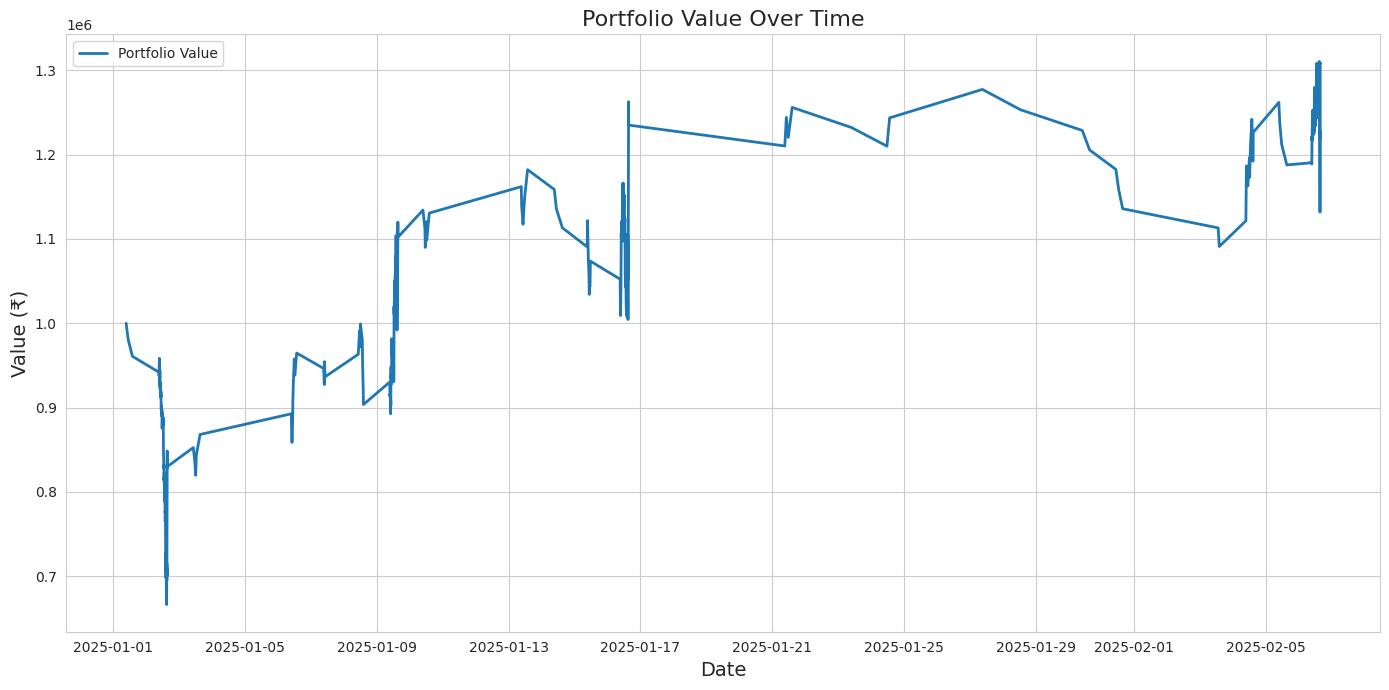

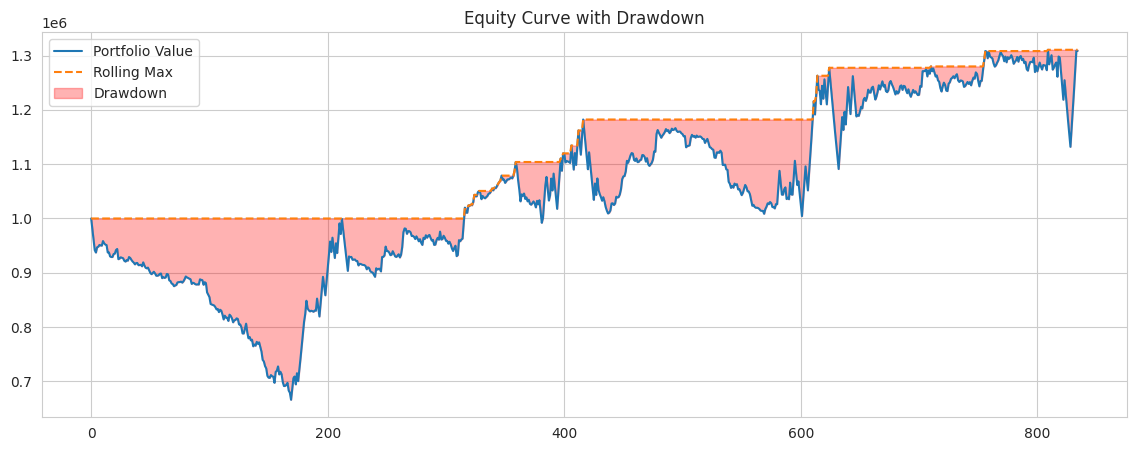

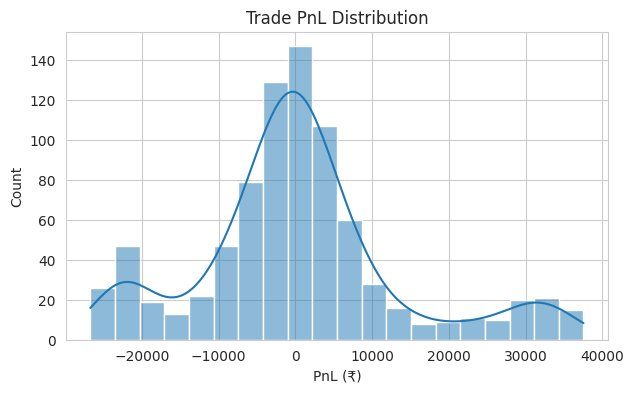

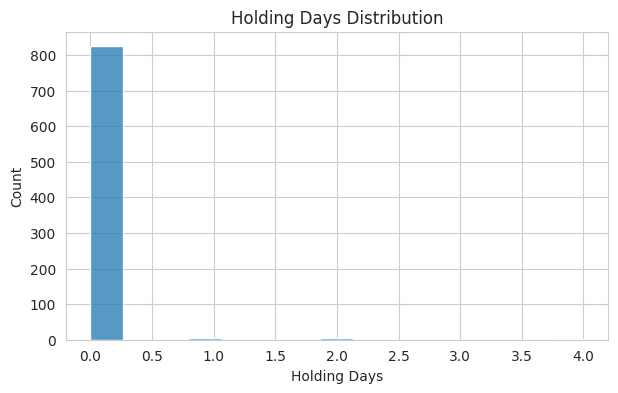

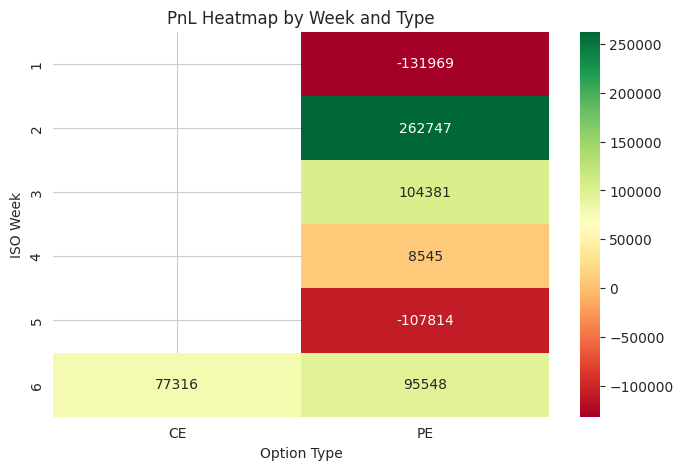

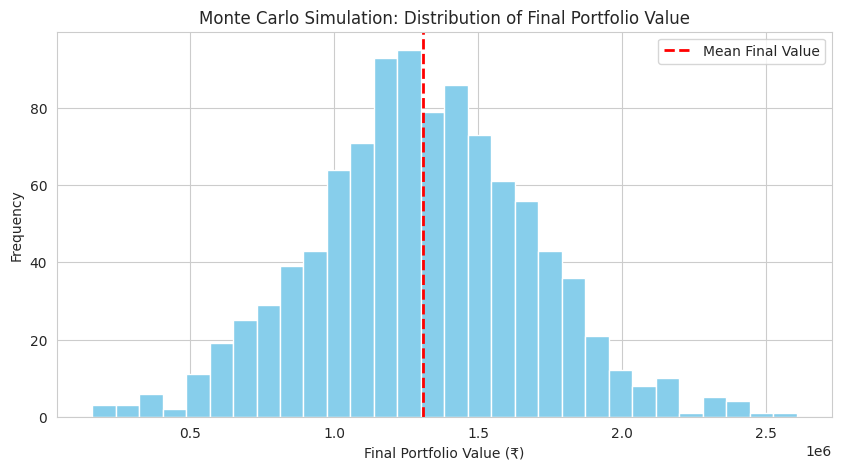

Monte Carlo: Mean Final Value = ₹1,307,125.88, 5th Percentile = ₹660,468.78, 95th Percentile = ₹1,921,497.44


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
risk_per_trade = 0.1  # 10% per trade
TP_PCT = 0.3  # 30% take profit (relative to entry price)
SL_PCT = 0.2  # 20% stop loss (relative to entry price)
BROKERAGE_PER_ORDER = 20  # INR per order (entry and exit)
SLIPPAGE_PCT = 0.001  # 0.1% per side

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals():
    signals_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_signal_details.csv'
    signals = pd.read_csv(signals_path, parse_dates=['TimeStamp'])
    signals = signals.set_index('TimeStamp')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def execute_trades_minute_tp_sl(
    spot_data, signals, options_data, tp_pct=TP_PCT, sl_pct=SL_PCT,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_min = signals.reindex(spot_data.index, method='ffill').dropna()
    open_position = None

    for ts, row in spot_data.iterrows():
        if ts not in signals_min.index or pd.isna(row['close']):
            continue
        signal = signals_min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue

        if open_position is None and signal != 0:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                continue
            tp_price = entry_price * (1 + tp_pct)
            sl_price = entry_price * (1 - sl_pct)
            # Apply slippage and brokerage at entry
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct  # Buy at ask
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'sl_price': sl_price,
                'entry_slippage': entry_slippage
            }
            continue

        if open_position is not None:
            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')

            exit_reason = None
            exit_price = None
            exit_time = None

            for _, opt_row in option_rows.iterrows():
                if opt_row['High'] >= open_position['tp_price']:
                    exit_price = open_position['tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Take Profit'
                    break
                elif opt_row['Low'] <= open_position['sl_price']:
                    exit_price = open_position['sl_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Stop Loss'
                    break

            if exit_reason is None and ts.date() >= open_position['expiry']:
                last_row = option_rows.iloc[-1] if not option_rows.empty else None
                if last_row is not None:
                    exit_price = float(last_row['Close'])
                    exit_time = last_row['TimeStamp']
                    exit_reason = 'Expiry'

            if exit_reason is not None and exit_price is not None:
                # Apply slippage and brokerage at exit
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct  # Sell at bid
                holding_days = (exit_time - open_position['entry_date']).days
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['lots'],
                    'pnl': pnl,
                    'holding_days': holding_days,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason
                })
                open_position = None  # Reset for next trade

    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading signals...")
signals = load_signals()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nExecuting trades minute by minute with rolling expiry, take profit, stop loss, brokerage, and slippage...")
trade_log, total_brokerage, total_slippage = execute_trades_minute_tp_sl(
    spot_data, signals, options_sample
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading signals...
Signals shape: (38, 1)

Loading options sample...

Options sample loaded.

Executing trades minute by minute with rolling expiry, take profit, stop loss, brokerage, and slippage...

Detailed trade log saved to Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv
                 entry_date                entry_time  \
0 2025-01-01 09:15:00+05:30 2025-01-01 09:15:00+05:30   
1 2025-01-01 10:49:00+05:30 2025-01-01 10:49:00+05:30   
2 2025-01-03 09:15:00+05:30 2025-01-03 09:15:00+05:30   
3 2025-01-03 10:14:00+05:30 2025-01-03 10:14:00+05:30   
4 2025-01-03 11:21:00+05:30 2025-01-03 11:21:00+05:30   
5 2025-01-03 11:59:00+05:30 2025-01-03 11:59:00+05:30   
6 2025-01-03 12:25:00+05:30 2025-01-03 12:25:00+05:30   
7 2025-01-03 15:09:00+05:30 2025-01-03 15:09:00+05:30   
8 2025-01-06 09:37:00+

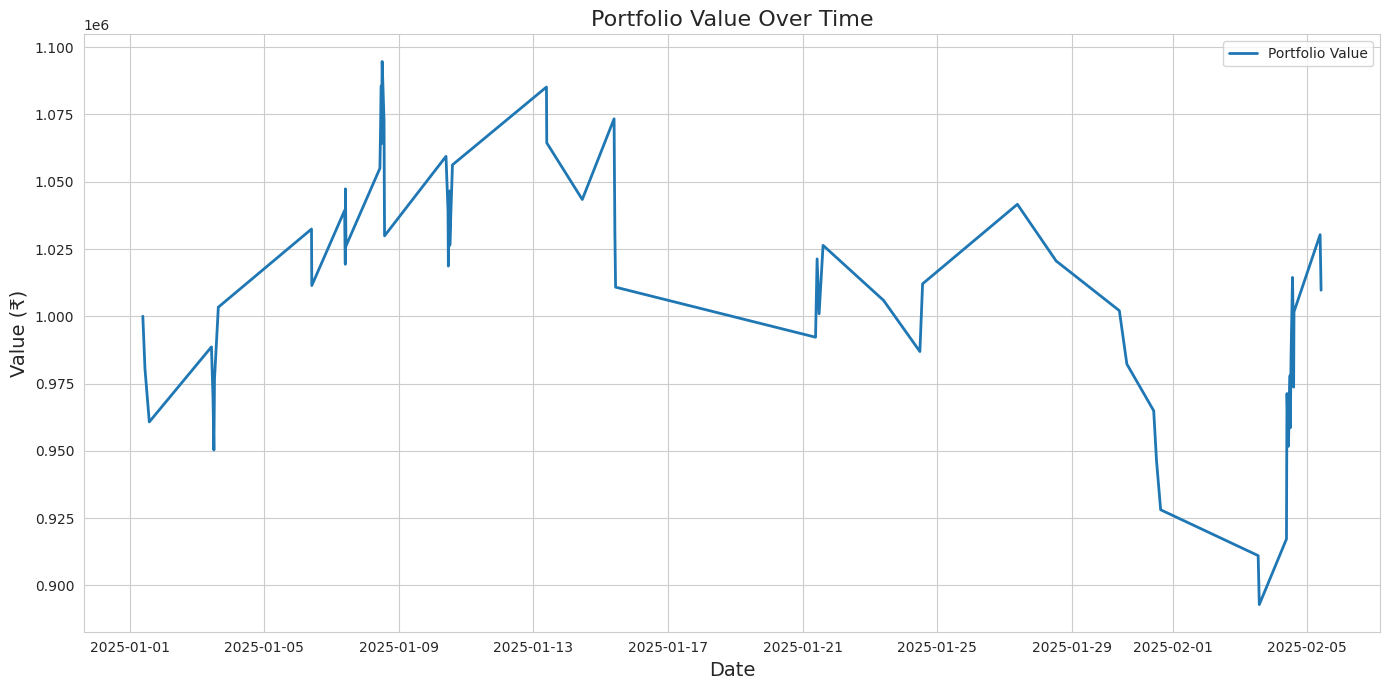

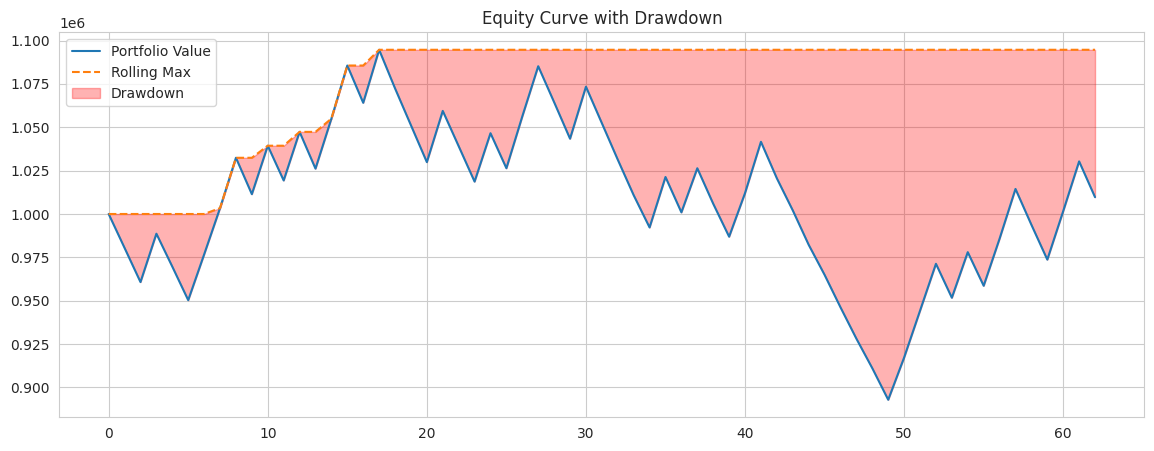

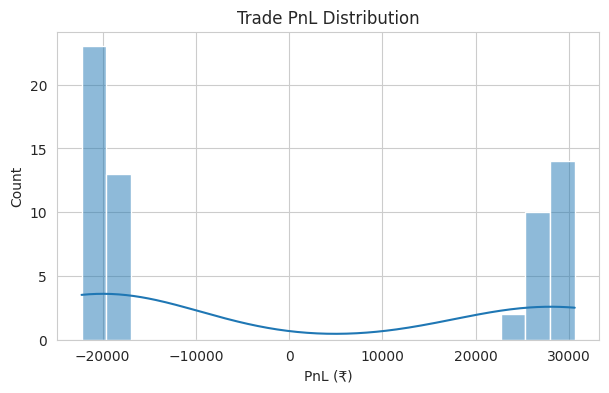

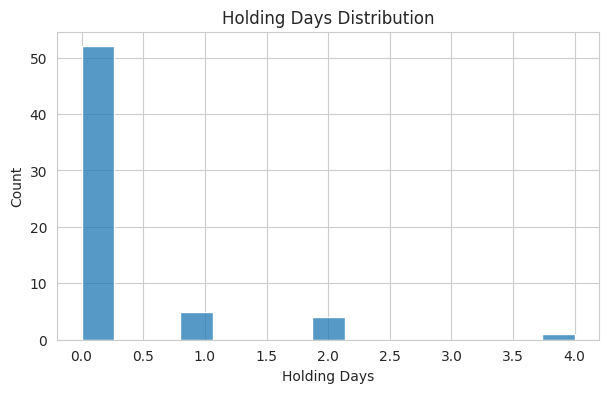

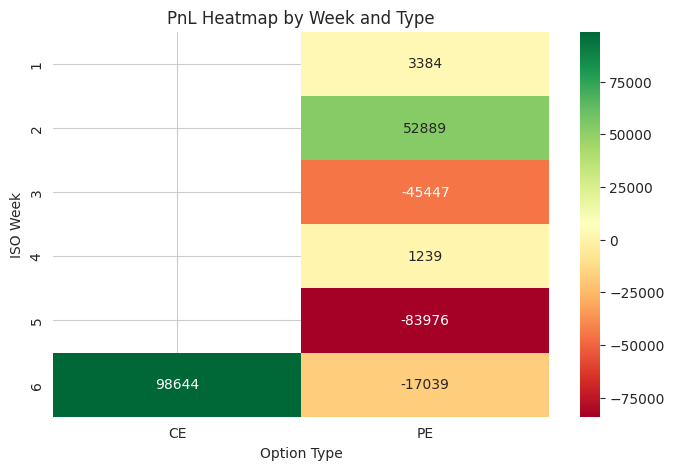

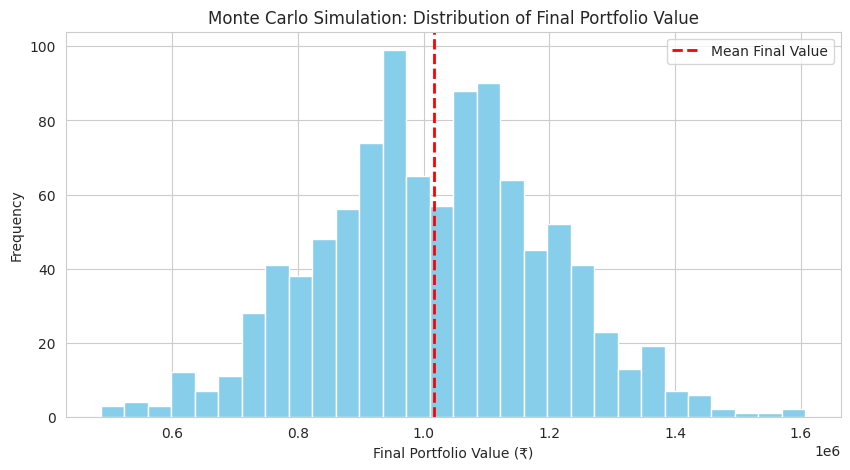

Monte Carlo: Mean Final Value = ₹1,016,560.35, 5th Percentile = ₹719,801.34, 95th Percentile = ₹1,311,434.60


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
risk_per_trade = 0.1  # 10% per trade
TP_PCT = 0.3  # 30% take profit (relative to entry price)
SL_PCT = 0.2  # 20% stop loss (relative to entry price)
BROKERAGE_PER_ORDER = 20  # INR per order (entry and exit)
SLIPPAGE_PCT = 0.001  # 0.1% per side
DAILY_LOSS_LIMIT = -20000  # INR

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals():
    signals_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_signal_details.csv'
    signals = pd.read_csv(signals_path, parse_dates=['TimeStamp'])
    signals = signals.set_index('TimeStamp')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def is_expiry_day(ts, expiry_list):
    return ts.date() in expiry_list

def execute_trades_minute_tp_sl(
    spot_data, signals, options_data, tp_pct=TP_PCT, sl_pct=SL_PCT,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT,
    daily_loss_limit=DAILY_LOSS_LIMIT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_min = signals.reindex(spot_data.index, method='ffill').dropna()
    open_position = None
    realized_pnl_by_day = {}

    for ts, row in spot_data.iterrows():
        if ts not in signals_min.index or pd.isna(row['close']):
            continue

        # --- Expiry Day Filter ---
        if is_expiry_day(ts, expiry_list):
            continue

        # --- Daily Loss Limit ---
        day = ts.date()
        if day in realized_pnl_by_day and realized_pnl_by_day[day] <= daily_loss_limit:
            continue

        signal = signals_min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue

        if open_position is None and signal != 0:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                continue
            tp_price = entry_price * (1 + tp_pct)
            sl_price = entry_price * (1 - sl_pct)
            # Apply slippage and brokerage at entry
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct  # Buy at ask
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'sl_price': sl_price,
                'entry_slippage': entry_slippage
            }
            continue

        if open_position is not None:
            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')

            exit_reason = None
            exit_price = None
            exit_time = None

            for _, opt_row in option_rows.iterrows():
                if opt_row['High'] >= open_position['tp_price']:
                    exit_price = open_position['tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Take Profit'
                    break
                elif opt_row['Low'] <= open_position['sl_price']:
                    exit_price = open_position['sl_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Stop Loss'
                    break

            if exit_reason is None and ts.date() >= open_position['expiry']:
                last_row = option_rows.iloc[-1] if not option_rows.empty else None
                if last_row is not None:
                    exit_price = float(last_row['Close'])
                    exit_time = last_row['TimeStamp']
                    exit_reason = 'Expiry'

            if exit_reason is not None and exit_price is not None:
                # Apply slippage and brokerage at exit
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct  # Sell at bid
                holding_days = (exit_time - open_position['entry_date']).days
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['lots'],
                    'pnl': pnl,
                    'holding_days': holding_days,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason
                })
                # Update daily realized PnL
                day = open_position['entry_date'].date()
                realized_pnl_by_day[day] = realized_pnl_by_day.get(day, 0) + pnl
                open_position = None  # Reset for next trade

    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading signals...")
signals = load_signals()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nExecuting trades minute by minute with rolling expiry, take profit, stop loss, brokerage, and slippage...")
trade_log, total_brokerage, total_slippage = execute_trades_minute_tp_sl(
    spot_data, signals, options_sample
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading signals...
Signals shape: (38, 1)

Loading options sample...

Options sample loaded.

Executing trades minute by minute with rolling expiry, take profit, stop loss, brokerage, and slippage...

Detailed trade log saved to Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv
                 entry_date                entry_time  \
0 2025-01-01 09:15:00+05:30 2025-01-01 09:15:00+05:30   
1 2025-01-01 10:49:00+05:30 2025-01-01 10:49:00+05:30   
2 2025-01-01 13:53:00+05:30 2025-01-01 13:53:00+05:30   
3 2025-01-03 09:16:00+05:30 2025-01-03 09:16:00+05:30   
4 2025-01-03 10:13:00+05:30 2025-01-03 10:13:00+05:30   
5 2025-01-03 11:21:00+05:30 2025-01-03 11:21:00+05:30   
6 2025-01-03 11:59:00+05:30 2025-01-03 11:59:00+05:30   
7 2025-01-03 12:25:00+05:30 2025-01-03 12:25:00+05:30   
8 2025-01-03 15:09:00+

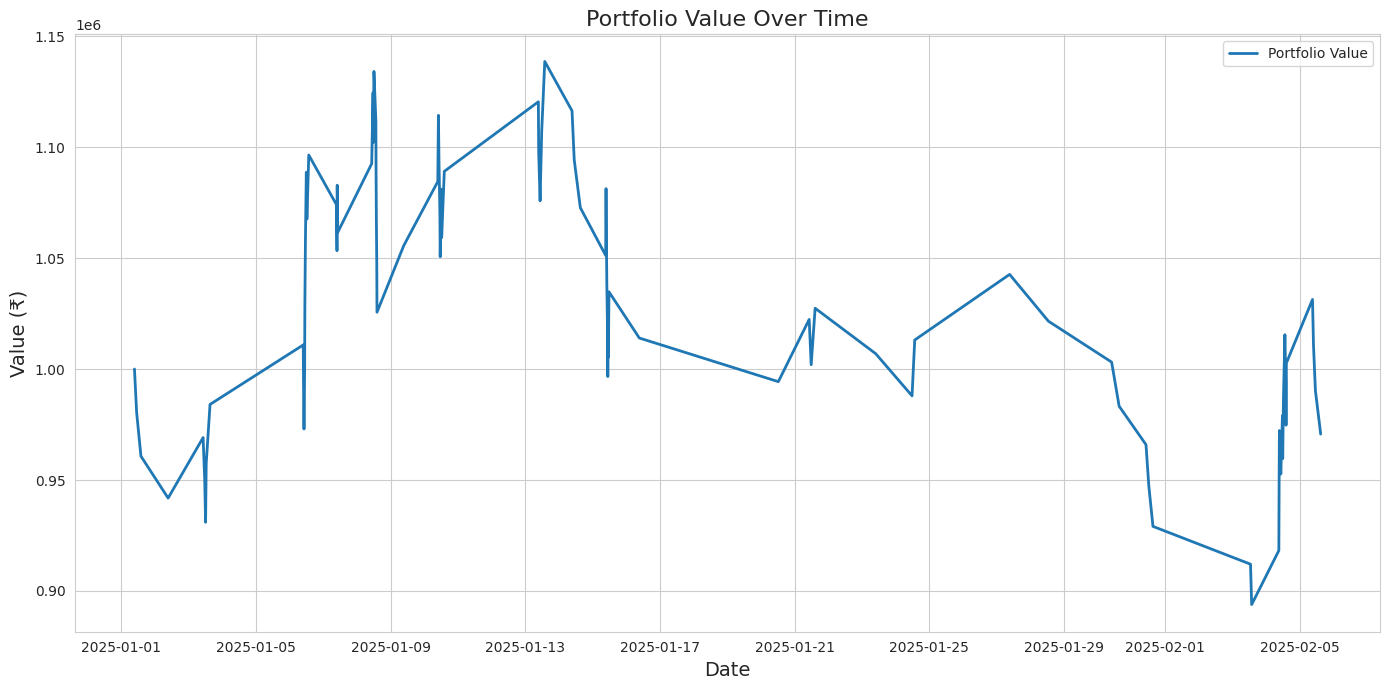

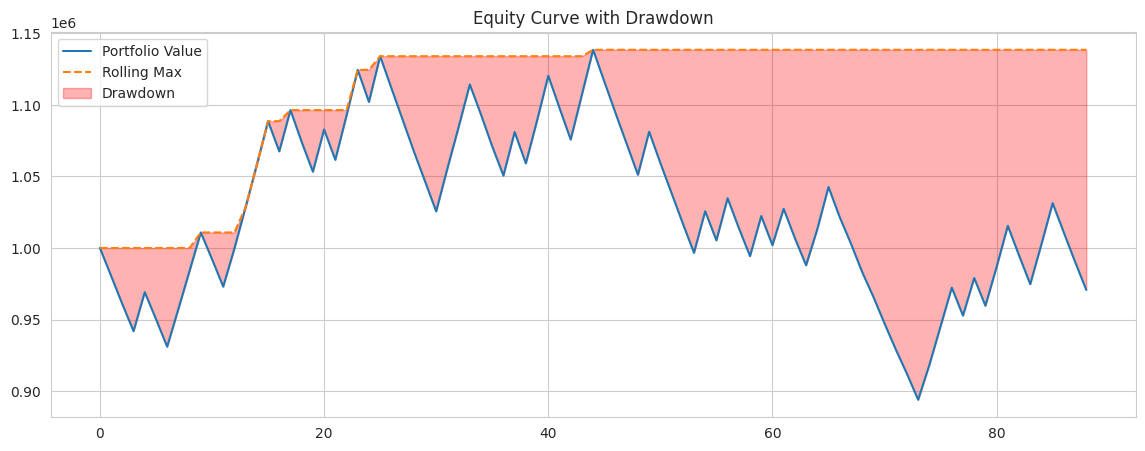

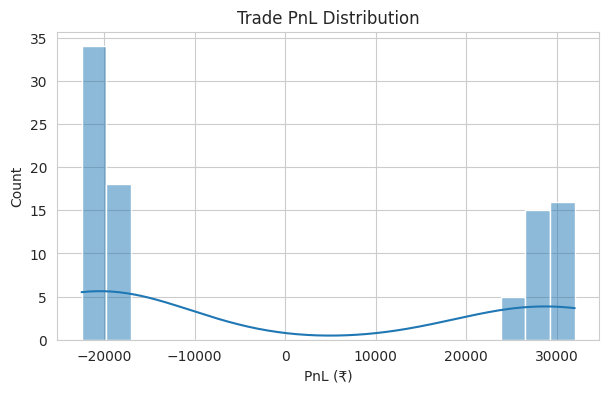

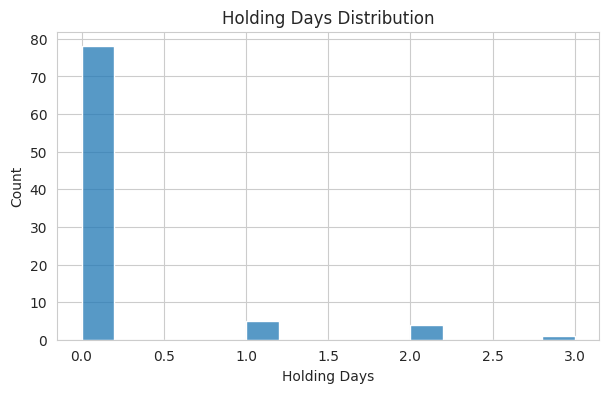

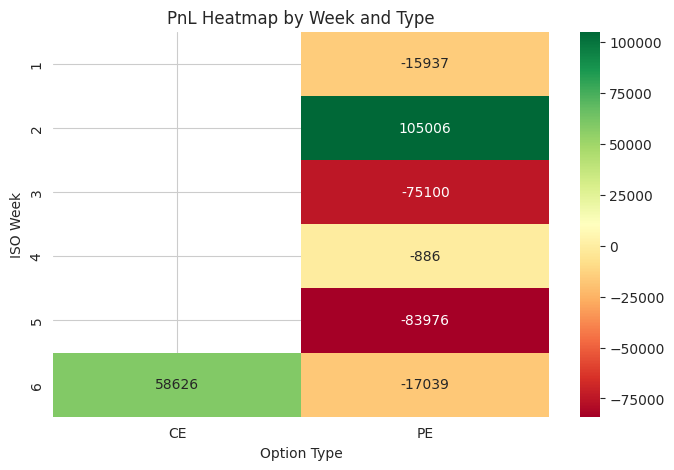

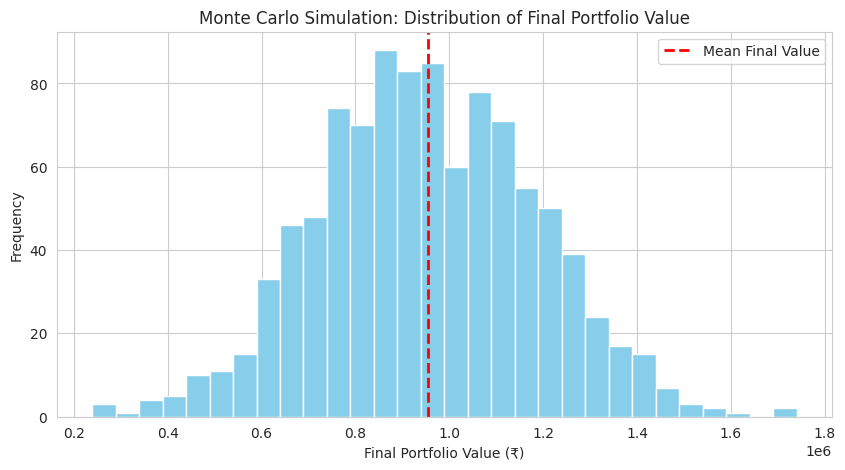

Monte Carlo: Mean Final Value = ₹953,920.37, 5th Percentile = ₹595,668.77, 95th Percentile = ₹1,329,965.27


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
risk_per_trade = 0.1  # 10% per trade
TP_PCT = 0.3  # 30% take profit (relative to entry price)
SL_PCT = 0.2  # 20% stop loss (relative to entry price)
BROKERAGE_PER_ORDER = 20  # INR per order (entry and exit)
SLIPPAGE_PCT = 0.001  # 0.1% per side

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals():
    signals_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_signal_details.csv'
    signals = pd.read_csv(signals_path, parse_dates=['TimeStamp'])
    signals = signals.set_index('TimeStamp')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def is_expiry_day(ts, expiry_list):
    return ts.date() in expiry_list

def execute_trades_minute_tp_sl(
    spot_data, signals, options_data, tp_pct=TP_PCT, sl_pct=SL_PCT,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_min = signals.reindex(spot_data.index, method='ffill').dropna()
    open_position = None

    for ts, row in spot_data.iterrows():
        if ts not in signals_min.index or pd.isna(row['close']):
            continue
        signal = signals_min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue

        # === NO EXECUTION ON EXPIRY DAY ===
        if is_expiry_day(ts, expiry_list):
            continue

        if open_position is None and signal != 0:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                continue
            tp_price = entry_price * (1 + tp_pct)
            sl_price = entry_price * (1 - sl_pct)
            # Apply slippage and brokerage at entry
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct  # Buy at ask
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'sl_price': sl_price,
                'entry_slippage': entry_slippage
            }
            continue

        if open_position is not None:
            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')

            exit_reason = None
            exit_price = None
            exit_time = None

            for _, opt_row in option_rows.iterrows():
                if opt_row['High'] >= open_position['tp_price']:
                    exit_price = open_position['tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Take Profit'
                    break
                elif opt_row['Low'] <= open_position['sl_price']:
                    exit_price = open_position['sl_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Stop Loss'
                    break

            if exit_reason is None and ts.date() >= open_position['expiry']:
                last_row = option_rows.iloc[-1] if not option_rows.empty else None
                if last_row is not None:
                    exit_price = float(last_row['Close'])
                    exit_time = last_row['TimeStamp']
                    exit_reason = 'Expiry'

            if exit_reason is not None and exit_price is not None:
                # Apply slippage and brokerage at exit
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct  # Sell at bid
                holding_days = (exit_time - open_position['entry_date']).days
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['lots'],
                    'pnl': pnl,
                    'holding_days': holding_days,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason
                })
                open_position = None  # Reset for next trade

    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading signals...")
signals = load_signals()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nExecuting trades minute by minute with rolling expiry, take profit, stop loss, brokerage, and slippage...")
trade_log, total_brokerage, total_slippage = execute_trades_minute_tp_sl(
    spot_data, signals, options_sample
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_minute_tp_sl_ALL_EXPIRIES.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
risk_per_trade = 0.1  # 10% per trade
TP_PCT = 0.3  # 30% take profit (relative to entry price)
SL_PCT = 0.2  # 20% stop loss (relative to entry price)
BROKERAGE_PER_ORDER = 20  # INR per order (entry and exit)
SLIPPAGE_PCT = 0.001  # 0.1% per side

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    # Ensure column is named 'Signal'
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def execute_trades_15min_tp_sl(
    spot_data, signals, options_data, tp_pct=TP_PCT, sl_pct=SL_PCT,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    # Reindex signals to spot_data 15-min intervals
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    open_position = None

    for ts, row in spot_data.iterrows():
        # Only act on 15-min timestamps present in signals
        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue

        if open_position is None and signal != 0:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                continue
            tp_price = entry_price * (1 + tp_pct)
            sl_price = entry_price * (1 - sl_pct)
            # Apply slippage and brokerage at entry
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct  # Buy at ask
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'sl_price': sl_price,
                'entry_slippage': entry_slippage
            }
            continue

        if open_position is not None:
            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')

            exit_reason = None
            exit_price = None
            exit_time = None

            for _, opt_row in option_rows.iterrows():
                if opt_row['High'] >= open_position['tp_price']:
                    exit_price = open_position['tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Take Profit'
                    break
                elif opt_row['Low'] <= open_position['sl_price']:
                    exit_price = open_position['sl_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Stop Loss'
                    break

            if exit_reason is None and ts.date() >= open_position['expiry']:
                last_row = option_rows.iloc[-1] if not option_rows.empty else None
                if last_row is not None:
                    exit_price = float(last_row['Close'])
                    exit_time = last_row['TimeStamp']
                    exit_reason = 'Expiry'

            if exit_reason is not None and exit_price is not None:
                # Apply slippage and brokerage at exit
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct  # Sell at bid
                holding_days = (exit_time - open_position['entry_date']).days
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['lots'],
                    'pnl': pnl,
                    'holding_days': holding_days,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason
                })
                open_position = None  # Reset for next trade

    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nExecuting trades 15-minutely with rolling expiry, take profit, stop loss, brokerage, and slippage...")
trade_log, total_brokerage, total_slippage = execute_trades_15min_tp_sl(
    spot_data, signals, options_sample
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_15min_tp_sl_ALL_EXPIRIES.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_15min_tp_sl_ALL_EXPIRIES.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing trades 15-minutely with ATR trailing stop, TP, max loss cap, no overnight holding, and VIX-based risk management...


/tmp/ipython-input-3-382888706.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_atr(x, ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)



Detailed trade log saved to Jan_Feb_detailed_trade_log_15min_atr_trailing_tp_maxloss_eod_vix.csv
                 entry_date                entry_time  \
0 2025-01-01 09:15:00+05:30 2025-01-01 09:15:00+05:30   
1 2025-01-01 14:30:00+05:30 2025-01-01 14:30:00+05:30   
2 2025-01-02 09:15:00+05:30 2025-01-02 09:15:00+05:30   
3 2025-01-02 14:30:00+05:30 2025-01-02 14:30:00+05:30   
4 2025-01-03 09:15:00+05:30 2025-01-03 09:15:00+05:30   
5 2025-01-03 15:00:00+05:30 2025-01-03 15:00:00+05:30   
6 2025-01-06 09:15:00+05:30 2025-01-06 09:15:00+05:30   
7 2025-01-07 15:00:00+05:30 2025-01-07 15:00:00+05:30   
8 2025-01-07 15:15:00+05:30 2025-01-07 15:15:00+05:30   
9 2025-01-10 14:45:00+05:30 2025-01-10 14:45:00+05:30   

                  exit_date action type  strike  entry_price  exit_price  \
0 2025-01-01 09:18:00+05:30    Buy   PE   23650    120.12000  115.796588   
1 2025-01-01 14:30:00+05:30    Buy   CE   23800    118.06795  118.019362   
2 2025-01-02 09:16:00+05:30    Buy   PE   2380

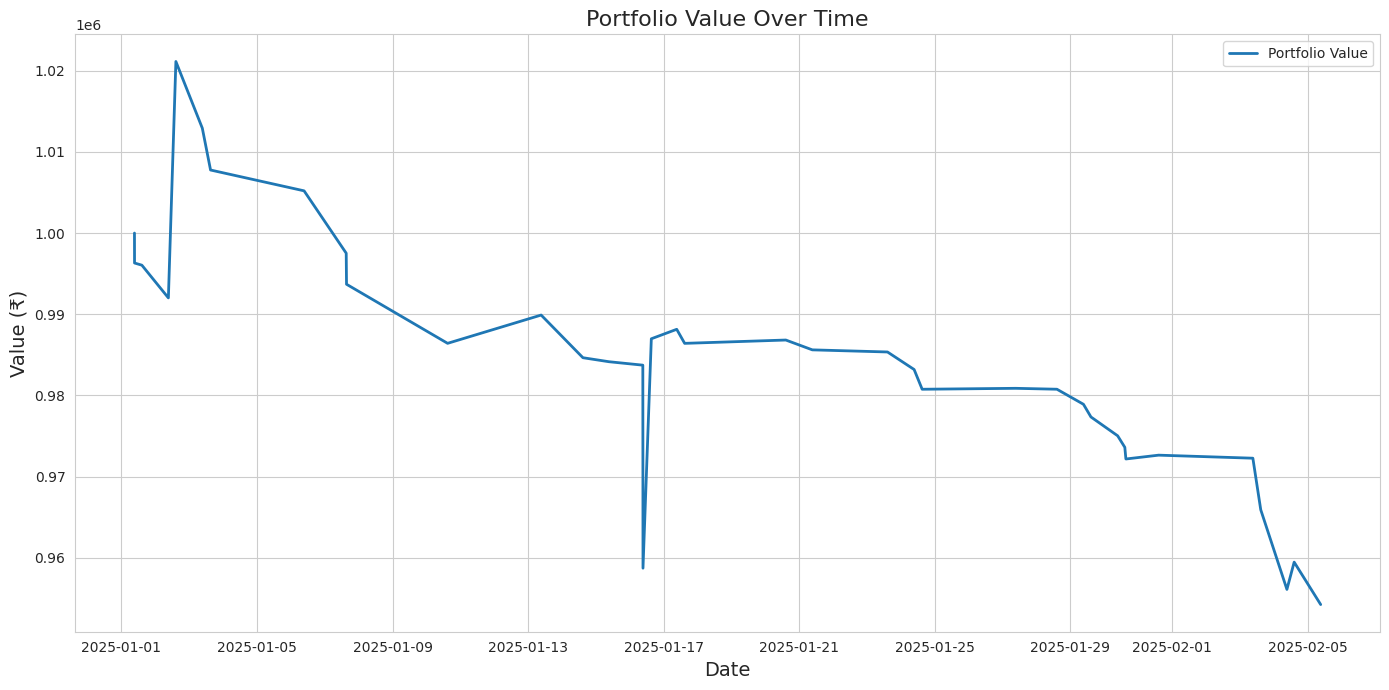

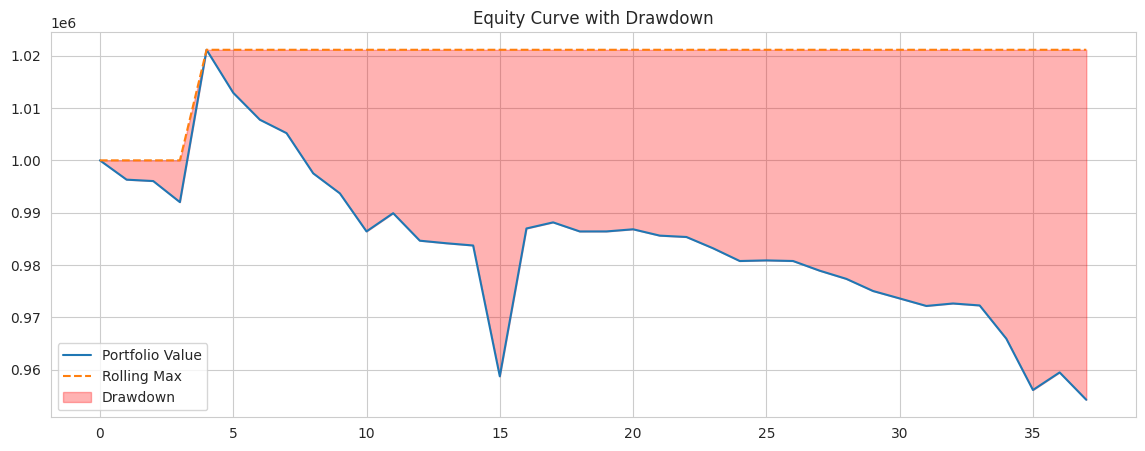

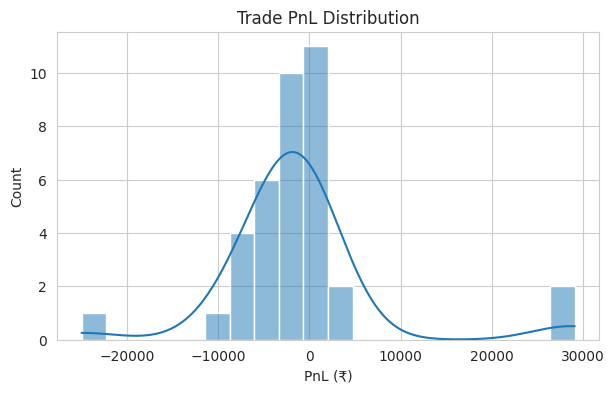

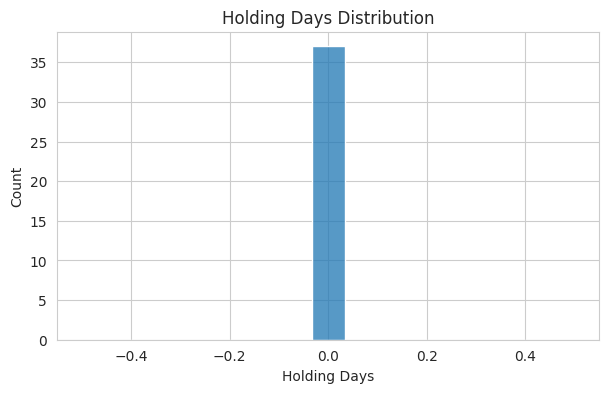

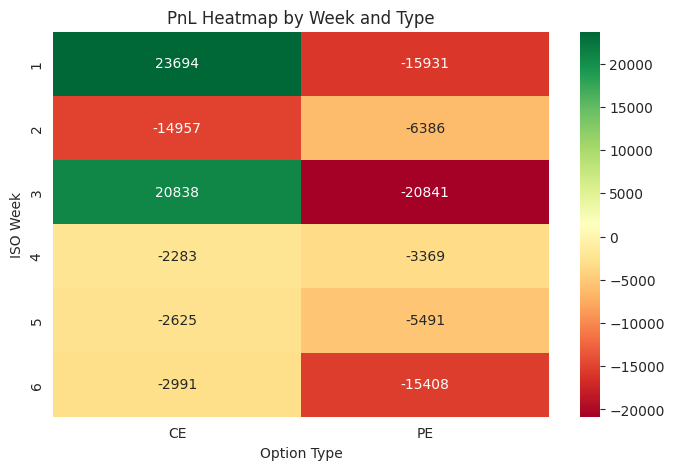

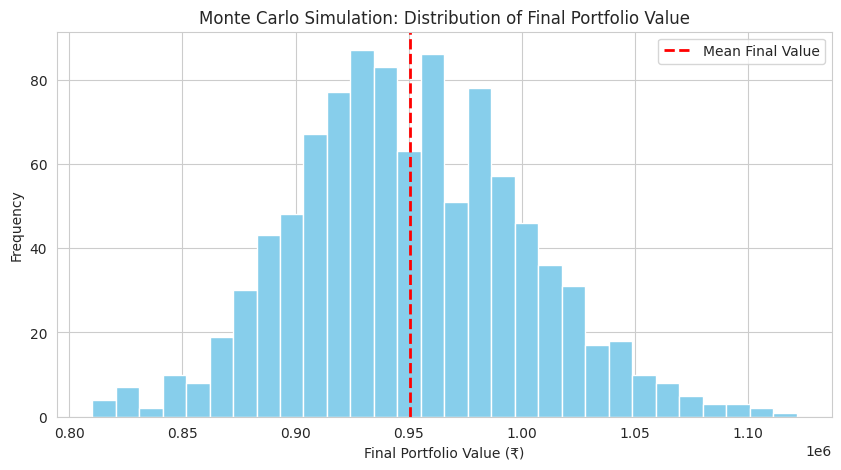

Monte Carlo: Mean Final Value = ₹950,630.13, 5th Percentile = ₹872,329.11, 95th Percentile = ₹1,037,566.59


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
TP_PCT = 0.3  # 30% take profit (relative to entry price)
ATR_PERIOD = 10  # ATR window for trailing stop
ATR_MULTIPLIER = 2.5  # Multiplier for trailing stop
MAX_LOSS = 25000  # Maximum allowed loss per trade in INR
BROKERAGE_PER_ORDER = 20  # INR per order (entry and exit)
SLIPPAGE_PCT = 0.001  # 0.1% per side
MARKET_CLOSE_TIME = '15:25:00'  # All trades closed before this time

# VIX thresholds for dynamic risk
VIX_LOW = 13
VIX_MED = 17
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_MED:
        return RISK_MED
    else:
        return RISK_HIGH

def execute_trades_15min_atr_trailing_vix(
    spot_data, signals, options_data, vix_data, tp_pct=TP_PCT,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_position = None
    prev_signal = 0

    # Pre-compute ATR for each option contract for trailing stop
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'])\
        .apply(lambda x: compute_atr(x, ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)

    for ts, row in spot_data.iterrows():
        # Close all trades before end of session (no overnight holding)
        if ts.time() >= datetime.strptime(MARKET_CLOSE_TIME, '%H:%M:%S').time():
            if open_position is not None:
                # Close at current price
                exit_row = options_data[
                    (options_data['Strike'] == open_position['strike']) &
                    (options_data['Type'] == open_position['type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_row.empty:
                    exit_price = float(exit_row.iloc[0]['Close'])
                    exit_time = exit_row.iloc[0]['TimeStamp']
                    exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                    total_slippage += exit_slippage
                    total_brokerage += brokerage_per_order
                    exit_price_adj = exit_price - exit_price * slippage_pct
                    pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                    pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                    if pnl < -MAX_LOSS:
                        pnl = -MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': open_position['entry_date'],
                        'entry_time': open_position['entry_time'],
                        'exit_date': exit_time,
                        'action': open_position['action'],
                        'type': open_position['type'],
                        'strike': open_position['strike'],
                        'entry_price': open_position['entry_price'],
                        'exit_price': exit_price_adj,
                        'lots': open_position['lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': open_position['spot'],
                        'expiry': open_position['expiry'],
                        'exit_reason': 'EOD Close'
                    })
                    open_position = None
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            prev_signal = signal
            continue

        # Get current VIX value (use 'Close' column)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)

        # ENTRY: Only when signal changes from prev_signal to new signal (crossover)
        if open_position is None and signal != 0 and signal != prev_signal:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                prev_signal = signal
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                prev_signal = signal
                continue
            tp_price = entry_price * (1 + tp_pct)
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct  # Buy at ask
            atr = float(entry_row.iloc[0]['ATR'])
            trailing_stop = entry_price_adj - ATR_MULTIPLIER * atr
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'trailing_stop': trailing_stop,
                'max_loss_stop': entry_price_adj - (MAX_LOSS / (lot_size * lots)),
                'entry_slippage': entry_slippage,
                'highest_price': entry_price_adj,
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val
            }
            prev_signal = signal
            continue

        # EXIT: On trailing stop, TP, or max loss
        if open_position is not None:
            exit_reason = None
            exit_price = None
            exit_time = None

            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')

            for _, opt_row in option_rows.iterrows():
                price = float(opt_row['Close'])
                atr = float(opt_row['ATR'])
                if price > open_position['highest_price']:
                    open_position['highest_price'] = price
                trailing_stop = open_position['highest_price'] - ATR_MULTIPLIER * atr
                open_position['trailing_stop'] = max(open_position['trailing_stop'], trailing_stop)
                if price >= open_position['tp_price']:
                    exit_price = open_position['tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Take Profit'
                    break
                elif price <= open_position['trailing_stop']:
                    exit_price = open_position['trailing_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Trailing Stop'
                    break
                elif price <= open_position['max_loss_stop']:
                    exit_price = open_position['max_loss_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Max Loss Stop'
                    break

            if exit_reason is None and ts.time() >= datetime.strptime(MARKET_CLOSE_TIME, '%H:%M:%S').time():
                last_row = option_rows.iloc[-1] if not option_rows.empty else None
                if last_row is not None:
                    exit_price = float(last_row['Close'])
                    exit_time = last_row['TimeStamp']
                    exit_reason = 'EOD Close'

            if exit_reason is not None and exit_price is not None:
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                if pnl < -MAX_LOSS:
                    pnl = -MAX_LOSS
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['lots'],
                    'pnl': pnl,
                    'holding_days': 0,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason,
                    'risk_per_trade': open_position['risk_per_trade'],
                    'vix_at_entry': open_position['vix_at_entry']
                })
                open_position = None

        prev_signal = signal

    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting trades 15-minutely with ATR trailing stop, TP, max loss cap, no overnight holding, and VIX-based risk management...")
trade_log, total_brokerage, total_slippage = execute_trades_15min_atr_trailing_vix(
    spot_data, signals, options_sample, vix_data
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_15min_atr_trailing_tp_maxloss_eod_vix.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_15min_atr_trailing_tp_maxloss_eod_vix.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing BUY-SIDE strategy...


/tmp/ipython-input-5-1995725195.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(



Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-5-1995725195.py:281: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(



Strategy Performance Report:
-----------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹954,251.71
Total Return:       -4.57%
Max Drawdown:       ₹65,493.50
Sharpe Ratio:       -2.27
Sortino Ratio:      -4.02
Calmar Ratio:       -4.08
Total Brokerage:    ₹1,480.00
Total Slippage:     ₹6,206.80

Trade Statistics:
-----------------
Total Trades:       37
Winning Trades:     9
Losing Trades:      28
Avg PnL:            ₹-1,236.44
Best Trade:         ₹29,113.03
Worst Trade:        ₹-25,000.00
Trade Period:       2025-01-01 to 2025-02-05



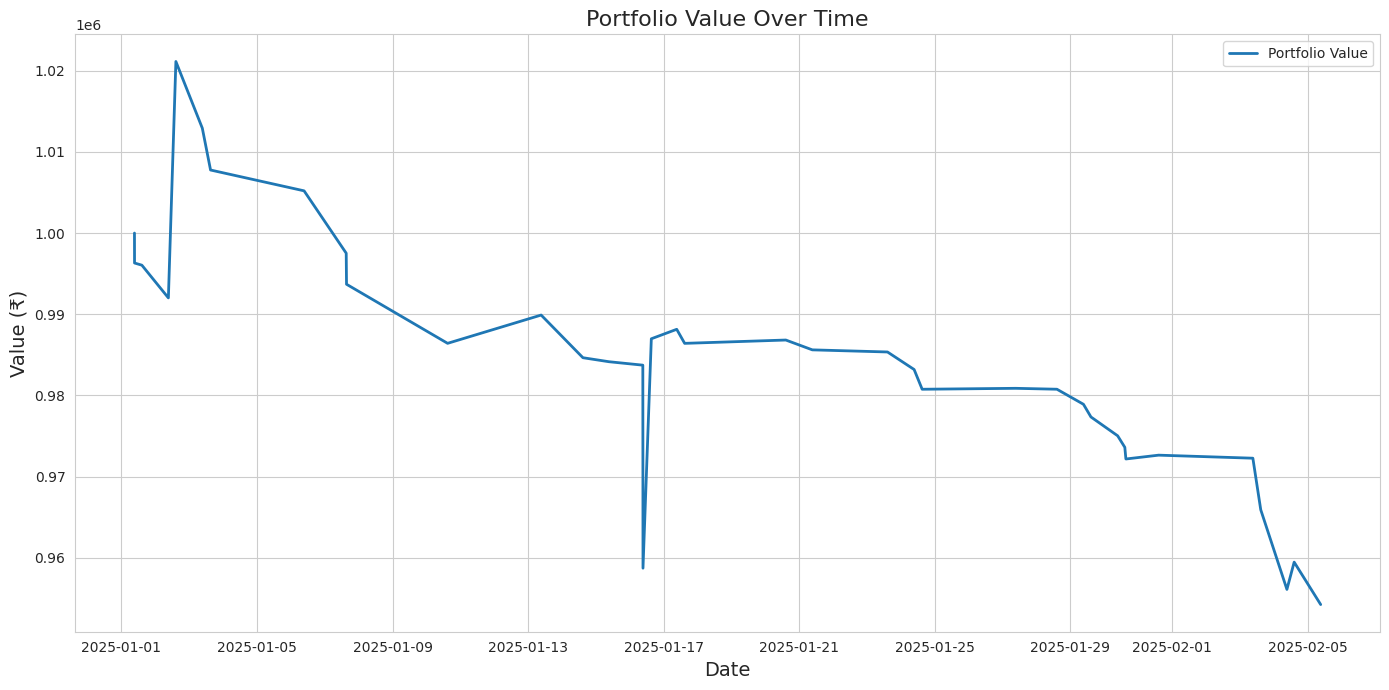

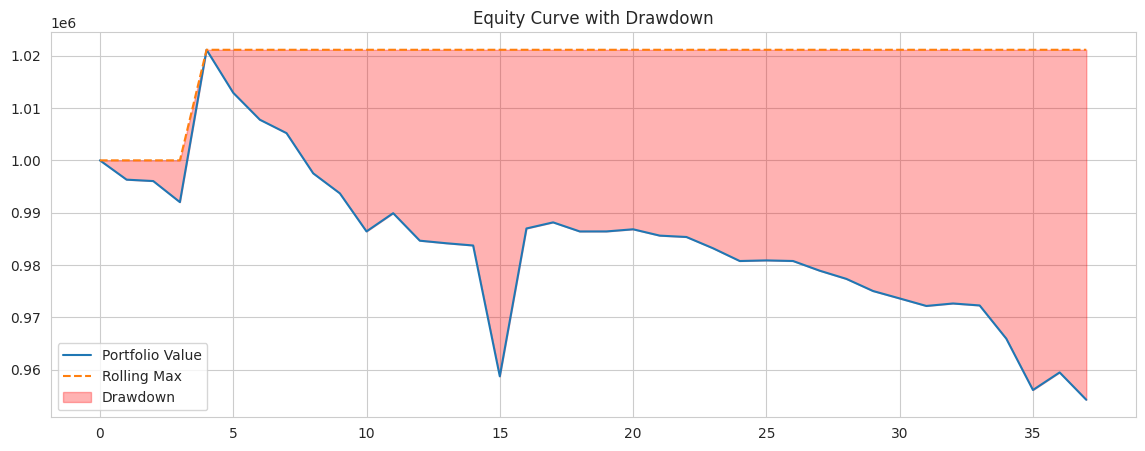

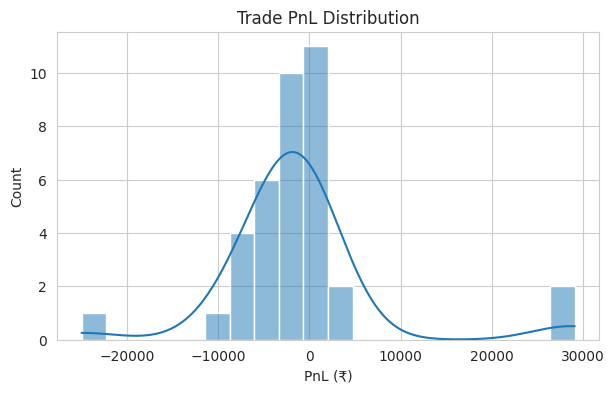

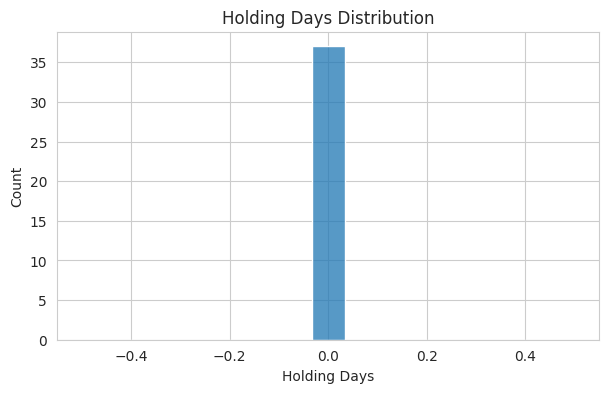

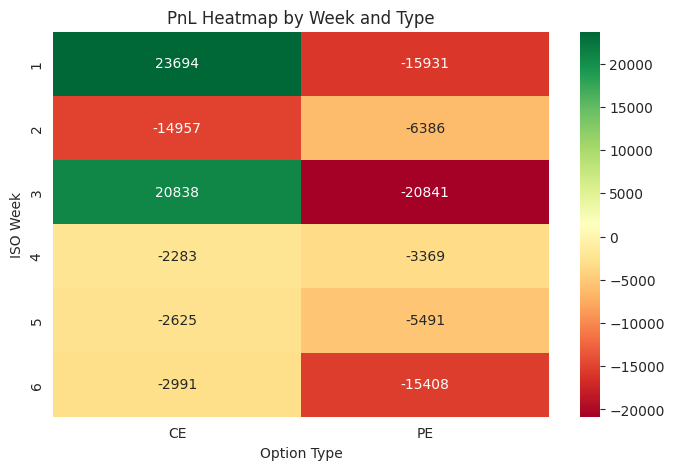

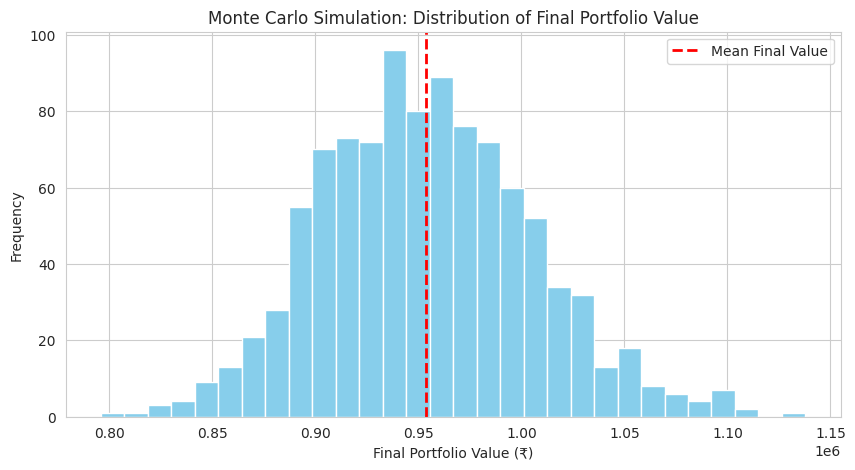

Monte Carlo: Mean Final Value = ₹953,882.81, 5th Percentile = ₹874,897.17, 95th Percentile = ₹1,040,487.38


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
TP_PCT = 0.3
ATR_PERIOD = 10
ATR_MULTIPLIER = 2.5
MAX_LOSS_BUY = 15000  # Buy-side only
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001
MARKET_CLOSE_TIME = '15:25:00'
VIX_LOW = 13
VIX_MED = 17
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05
CONFIRM_LOOKBACK = 10  # bars for price/volume confirmation

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ======================================================================
# STRATEGY HELPERS
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_MED:
        return RISK_MED
    else:
        return RISK_HIGH

def price_volume_confirmation(spot_data, ts, direction, lookback=CONFIRM_LOOKBACK):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    avg_vol = window['volume'].mean()
    last_vol = window['volume'].iloc[-1]
    if direction == 1:
        if last_close > window['high'][:-1].max() and last_vol > 1.2 * avg_vol:
            return True
    elif direction == -1:
        if last_close < window['low'][:-1].min() and last_vol > 1.2 * avg_vol:
            return True
    return False

# ======================================================================
# BUY-SIDE STRATEGY (LONG OPTIONS)
# ======================================================================
def execute_buy_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_position = None
    prev_signal = 0
    # --- FIX: Only pass relevant columns to compute_atr ---
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], ATR_PERIOD)
    )

    for ts, row in spot_data.iterrows():
        if ts.time() >= datetime.strptime(MARKET_CLOSE_TIME, '%H:%M:%S').time():
            if open_position is not None:
                exit_row = options_data[
                    (options_data['Strike'] == open_position['strike']) &
                    (options_data['Type'] == open_position['type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_row.empty:
                    exit_price = float(exit_row.iloc[0]['Close'])
                    exit_time = exit_row.iloc[0]['TimeStamp']
                    exit_slippage = exit_price * SLIPPAGE_PCT * lot_size * open_position['lots']
                    total_slippage += exit_slippage
                    total_brokerage += BROKERAGE_PER_ORDER
                    exit_price_adj = exit_price - exit_price * SLIPPAGE_PCT
                    pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                    pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * BROKERAGE_PER_ORDER)
                    if pnl < -MAX_LOSS_BUY:
                        pnl = -MAX_LOSS_BUY
                    portfolio_cash += pnl
                    trade_log.append({**open_position, 'exit_date': exit_time, 'exit_price': exit_price_adj, 'pnl': pnl, 'exit_reason': 'EOD Close'})
                    open_position = None
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)
        if open_position is None and signal != 0 and signal != prev_signal and price_volume_confirmation(spot_data, ts, signal):
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                prev_signal = signal
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                prev_signal = signal
                continue
            tp_price = entry_price * (1 + TP_PCT)
            entry_slippage = entry_price * SLIPPAGE_PCT * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += BROKERAGE_PER_ORDER
            entry_price_adj = entry_price + entry_price * SLIPPAGE_PCT
            atr = float(entry_row.iloc[0]['ATR'])
            trailing_stop = entry_price_adj - ATR_MULTIPLIER * atr
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'trailing_stop': trailing_stop,
                'max_loss_stop': entry_price_adj - (MAX_LOSS_BUY / (lot_size * lots)),
                'entry_slippage': entry_slippage,
                'highest_price': entry_price_adj,
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val
            }
            prev_signal = signal
            continue

        # EXIT: Trailing stop, TP, or max loss
        if open_position is not None:
            exit_reason = None
            exit_price = None
            exit_time = None
            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for _, opt_row in option_rows.iterrows():
                price = float(opt_row['Close'])
                atr = float(opt_row['ATR'])
                if price > open_position['highest_price']:
                    open_position['highest_price'] = price
                trailing_stop = open_position['highest_price'] - ATR_MULTIPLIER * atr
                open_position['trailing_stop'] = max(open_position['trailing_stop'], trailing_stop)
                if price >= open_position['tp_price']:
                    exit_price = open_position['tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Take Profit'
                    break
                elif price <= open_position['trailing_stop']:
                    exit_price = open_position['trailing_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Trailing Stop'
                    break
                elif price <= open_position['max_loss_stop']:
                    exit_price = open_position['max_loss_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Max Loss Stop'
                    break
            if exit_reason is not None and exit_price is not None:
                exit_slippage = exit_price * SLIPPAGE_PCT * lot_size * open_position['lots']
                total_slippage += exit_slippage
                total_brokerage += BROKERAGE_PER_ORDER
                exit_price_adj = exit_price - exit_price * SLIPPAGE_PCT
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * BROKERAGE_PER_ORDER)
                if pnl < -MAX_LOSS_BUY:
                    pnl = -MAX_LOSS_BUY
                portfolio_cash += pnl
                trade_log.append({**open_position, 'exit_date': exit_time, 'exit_price': exit_price_adj, 'pnl': pnl, 'exit_reason': exit_reason})
                open_position = None
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# SELL-SIDE STRATEGY (CREDIT SPREADS)
# ======================================================================
def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    # --- FIX: Only pass relevant columns to compute_atr ---
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], ATR_PERIOD)
    )

    for ts, row in spot_data.iterrows():
        if ts.time() >= datetime.strptime(MARKET_CLOSE_TIME, '%H:%M:%S').time():
            if open_spread is not None:
                short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
                exit_short = options_data[
                    (options_data['Strike'] == short_leg['strike']) &
                    (options_data['Type'] == short_leg['type']) &
                    (options_data['Expiry'].dt.date == short_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                exit_long = options_data[
                    (options_data['Strike'] == long_leg['strike']) &
                    (options_data['Type'] == long_leg['type']) &
                    (options_data['Expiry'].dt.date == long_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_short.empty and not exit_long.empty:
                    exit_short_price = float(exit_short.iloc[0]['Close'])
                    exit_long_price = float(exit_long.iloc[0]['Close'])
                    exit_time = exit_short.iloc[0]['TimeStamp']
                    pnl = (open_spread['credit'] - (exit_short_price - exit_long_price) * lot_size * open_spread['lots'])
                    pnl -= 2 * BROKERAGE_PER_ORDER
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'EOD Close'})
                    open_spread = None
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)
        if open_spread is None and signal != 0 and signal != prev_signal and price_volume_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            if lots < 1:
                prev_signal = signal
                continue
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val
            }
            prev_signal = signal
            continue

        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                if pnl < -abs(open_spread['credit']):
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Spread Stop'})
                    open_spread = None
                    break
                elif pnl > 0.8 * abs(open_spread['credit']):
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Spread TP'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting BUY-SIDE strategy...")
buy_log, buy_brokerage, buy_slippage = execute_buy_side(spot_data, signals, options_sample, vix_data)
buy_log_df = pd.DataFrame(buy_log)
if not buy_log_df.empty:
    buy_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_buy_side_log.csv', index=False)
    print("\nBuy-side log saved.")

print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(spot_data, signals, options_sample, vix_data)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log.csv', index=False)
    print("\nSell-side log saved.")

# (Reporting/plotting code as before)

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
TP_PCT = 0.3
ATR_PERIOD = 10
ATR_MULTIPLIER = 2.5
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001
MARKET_CLOSE_TIME = '15:25:00'
VIX_LOW = 13
VIX_MED = 17
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05
CONFIRM_LOOKBACK = 10  # bars for price/volume confirmation

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ======================================================================
# STRATEGY HELPERS
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_MED:
        return RISK_MED
    else:
        return RISK_HIGH

def price_volume_confirmation(spot_data, ts, direction, lookback=CONFIRM_LOOKBACK):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    avg_vol = window['volume'].mean()
    last_vol = window['volume'].iloc[-1]
    if direction == 1:
        if last_close > window['high'][:-1].max() and last_vol > 1.2 * avg_vol:
            return True
    elif direction == -1:
        if last_close < window['low'][:-1].min() and last_vol > 1.2 * avg_vol:
            return True
    return False

# ======================================================================
# SELL-SIDE STRATEGY (CREDIT SPREADS)
# ======================================================================
def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], ATR_PERIOD)
    )

    for ts, row in spot_data.iterrows():
        if ts.time() >= datetime.strptime(MARKET_CLOSE_TIME, '%H:%M:%S').time():
            if open_spread is not None:
                short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
                exit_short = options_data[
                    (options_data['Strike'] == short_leg['strike']) &
                    (options_data['Type'] == short_leg['type']) &
                    (options_data['Expiry'].dt.date == short_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                exit_long = options_data[
                    (options_data['Strike'] == long_leg['strike']) &
                    (options_data['Type'] == long_leg['type']) &
                    (options_data['Expiry'].dt.date == long_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_short.empty and not exit_long.empty:
                    exit_short_price = float(exit_short.iloc[0]['Close'])
                    exit_long_price = float(exit_long.iloc[0]['Close'])
                    exit_time = exit_short.iloc[0]['TimeStamp']
                    pnl = (open_spread['credit'] - (exit_short_price - exit_long_price) * lot_size * open_spread['lots'])
                    pnl -= 2 * BROKERAGE_PER_ORDER
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'EOD Close'})
                    open_spread = None
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)
        if open_spread is None and signal != 0 and signal != prev_signal and price_volume_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            if lots < 1:
                prev_signal = signal
                continue
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val
            }
            prev_signal = signal
            continue

        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                if pnl < -abs(open_spread['credit']):
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Spread Stop'})
                    open_spread = None
                    break
                elif pnl > 0.8 * abs(open_spread['credit']):
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Spread TP'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(spot_data, signals, options_sample, vix_data)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log.csv', index=False)
    print("\nSell-side log saved.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not sell_log_df.empty:
    trade_log_df = sell_log_df
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        pnl = row['exit_pnl'] if 'exit_pnl' in row else 0
        current_value += pnl
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{sell_brokerage:,.2f}
Total Slippage:     ₹{sell_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['exit_pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['exit_pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['exit_pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['exit_pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['exit_pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['exit_pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Direction ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='direction', values='exit_pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Direction")
    plt.xlabel("Spread Direction")
    plt.ylabel("ISO Week")
    plt.show()

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-6-801589110.py:128: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(


No trades to report.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-2-2038028436.py:127: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(



DEBUG: Potential entry at 2025-01-01 09:15:00+05:30: signal=-1, prev_signal=0
  spot_price=23649.55, atm_strike=23650, expiry=2025-01-02, vix_val=14.5525
  price_breakout_confirmation=False

DEBUG: Potential entry at 2025-01-01 14:30:00+05:30: signal=1, prev_signal=-1
  spot_price=23784.05, atm_strike=23800, expiry=2025-01-02, vix_val=14.4475
  price_breakout_confirmation=False

DEBUG: Potential entry at 2025-01-02 09:15:00+05:30: signal=-1, prev_signal=1
  spot_price=23787.6, atm_strike=23800, expiry=2025-01-02, vix_val=14.4475
  price_breakout_confirmation=False

DEBUG: Potential entry at 2025-01-02 14:30:00+05:30: signal=1, prev_signal=-1
  spot_price=24159.95, atm_strike=24150, expiry=2025-01-02, vix_val=13.8125
  price_breakout_confirmation=False

DEBUG: Potential entry at 2025-01-03 09:15:00+05:30: signal=-1, prev_signal=1
  spot_price=24152.65, atm_strike=24150, expiry=2025-01-09, vix_val=13.88
  price_breakout_confirmation=True
  DEBUG: margin_per_lot=2615.0000000000005, risk_

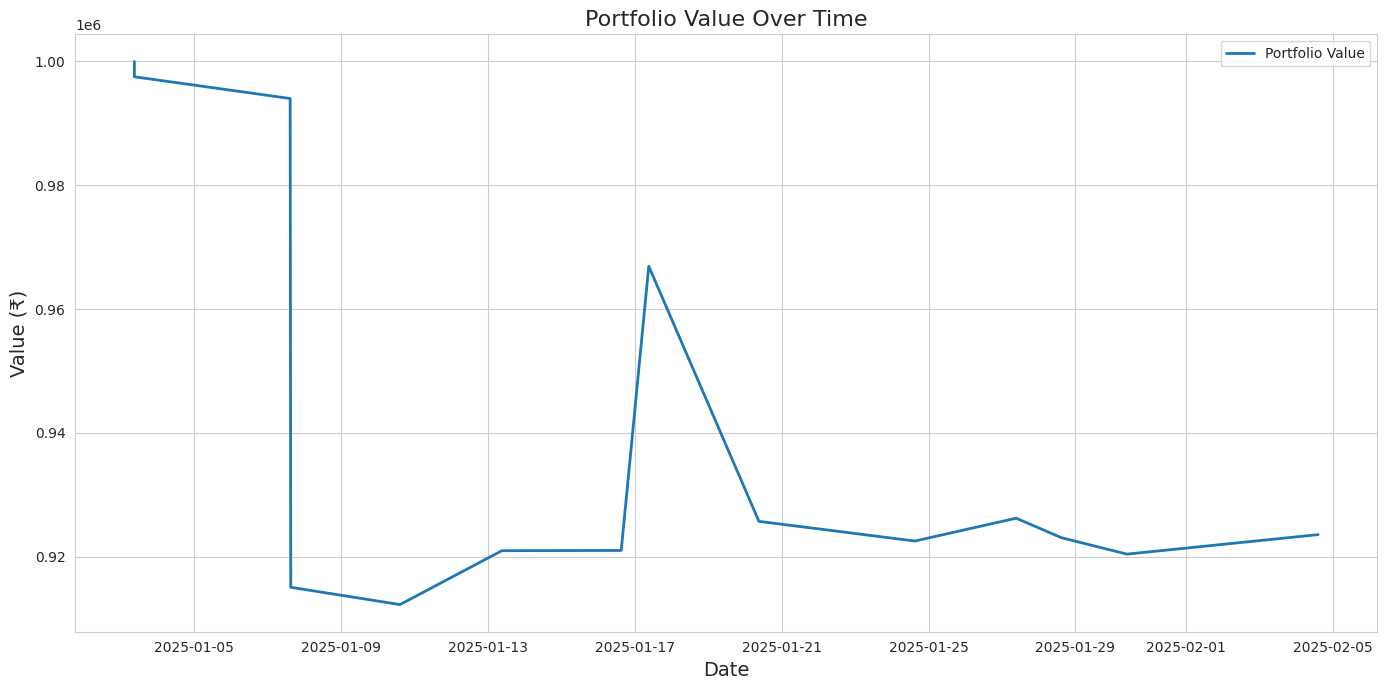

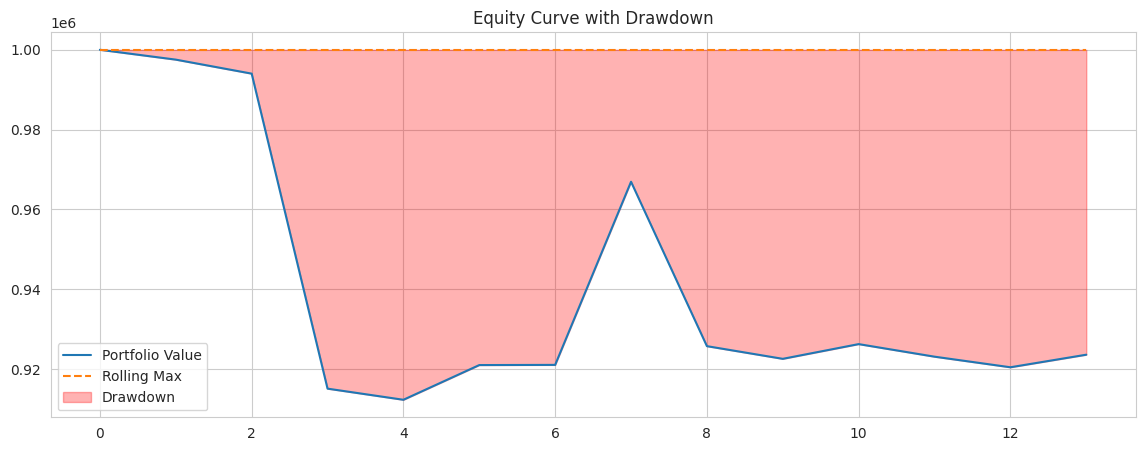

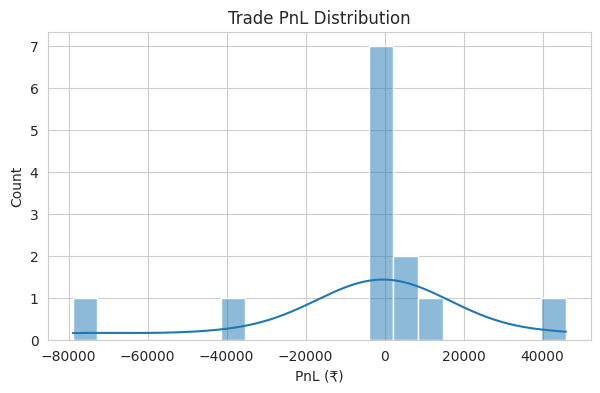

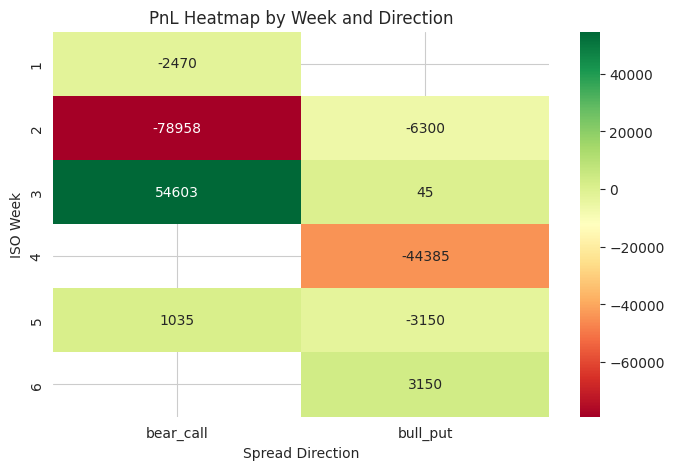

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
TP_PCT = 0.3
ATR_PERIOD = 10
ATR_MULTIPLIER = 2.5
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001
MARKET_CLOSE_TIME = '15:25:00'
VIX_LOW = 13
VIX_MED = 17
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05
CONFIRM_LOOKBACK = 10  # bars for confirmation

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ======================================================================
# STRATEGY HELPERS
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_MED:
        return RISK_MED
    else:
        return RISK_HIGH

def price_breakout_confirmation(spot_data, ts, direction, lookback=CONFIRM_LOOKBACK, sma_period=21):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    mean_high = window['high'][:-1].mean()
    mean_low = window['low'][:-1].mean()
    sma21 = window['close'].rolling(window=sma_period, min_periods=1).mean().iloc[-1]
    if direction == 1:
        return last_close > mean_high and last_close > sma21
    elif direction == -1:
        return last_close < mean_low and last_close < sma21
    return False

# ======================================================================
# SELL-SIDE STRATEGY (CREDIT SPREADS)
# ======================================================================
def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], ATR_PERIOD)
    )

    for ts, row in spot_data.iterrows():
        if ts.time() >= datetime.strptime(MARKET_CLOSE_TIME, '%H:%M:%S').time():
            if open_spread is not None:
                short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
                exit_short = options_data[
                    (options_data['Strike'] == short_leg['strike']) &
                    (options_data['Type'] == short_leg['type']) &
                    (options_data['Expiry'].dt.date == short_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                exit_long = options_data[
                    (options_data['Strike'] == long_leg['strike']) &
                    (options_data['Type'] == long_leg['type']) &
                    (options_data['Expiry'].dt.date == long_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_short.empty and not exit_long.empty:
                    exit_short_price = float(exit_short.iloc[0]['Close'])
                    exit_long_price = float(exit_long.iloc[0]['Close'])
                    exit_time = exit_short.iloc[0]['TimeStamp']
                    pnl = (open_spread['credit'] - (exit_short_price - exit_long_price) * lot_size * open_spread['lots'])
                    pnl -= 2 * BROKERAGE_PER_ORDER
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'EOD Close'})
                    open_spread = None
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)
        # DEBUG: Print entry signal and confirmation
        if signal != 0 and signal != prev_signal:
            print(f"\nDEBUG: Potential entry at {ts}: signal={signal}, prev_signal={prev_signal}")
            print(f"  spot_price={spot_price}, atm_strike={atm_strike}, expiry={expiry}, vix_val={vix_val}")
            print(f"  price_breakout_confirmation={price_breakout_confirmation(spot_data, ts, signal)}")
        if open_spread is None and signal != 0 and signal != prev_signal and price_breakout_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                print(f"  DEBUG: Missing options data for spread at {ts}: short_strike={short_strike}, long_strike={long_strike}, expiry={expiry}")
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            print(f"  DEBUG: margin_per_lot={margin_per_lot}, risk_per_trade={risk_per_trade}, lots={lots}")
            if lots < 1:
                print(f"  DEBUG: Not enough capital for at least 1 lot at {ts}")
                prev_signal = signal
                continue
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val
            }
            print(f"  DEBUG: Entered spread at {ts}: {open_spread['direction']}, lots={lots}, credit={credit}, margin={margin_per_lot}")
            prev_signal = signal
            continue

        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                if pnl < -abs(open_spread['credit']):
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Spread Stop'})
                    open_spread = None
                    break
                elif pnl > 0.8 * abs(open_spread['credit']):
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Spread TP'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(spot_data, signals, options_sample, vix_data)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log.csv', index=False)
    print("\nSell-side log saved.")
    print("\nTrade log preview:")
    print(sell_log_df.head())
else:
    print("\nNo trades to report.")

# (Performance report and visualizations as before)
# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not sell_log_df.empty:
    trade_log_df = sell_log_df
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        pnl = row['exit_pnl'] if 'exit_pnl' in row else 0
        current_value += pnl
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{sell_brokerage:,.2f}
Total Slippage:     ₹{sell_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['exit_pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['exit_pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['exit_pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['exit_pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['exit_pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['exit_pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Direction ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='direction', values='exit_pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Direction")
    plt.xlabel("Spread Direction")
    plt.ylabel("ISO Week")
    plt.show()

else:
    print("No trades to report.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
ATR_PERIOD = 10
ATR_MULTIPLIER = 2.5
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001
MARKET_CLOSE_TIME = '15:25:00'
VIX_LOW = 13
VIX_HIGH = 22
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05
CONFIRM_LOOKBACK = 10
MAX_LOSS = 18000
PARTIAL_BOOK_PCT = 0.4  # 40% position booked at first TP

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ======================================================================
# STRATEGY HELPERS
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_HIGH:
        return RISK_MED
    else:
        return RISK_HIGH

def vix_trend_filter(vix_val):
    return VIX_LOW < vix_val < VIX_HIGH

def price_breakout_confirmation(spot_data, ts, direction, lookback=CONFIRM_LOOKBACK, sma_period=21):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    mean_high = window['high'][:-1].mean()
    mean_low = window['low'][:-1].mean()
    sma21 = window['close'].rolling(window=sma_period, min_periods=1).mean().iloc[-1]
    if direction == 1:
        return last_close > mean_high and last_close > sma21
    elif direction == -1:
        return last_close < mean_low and last_close < sma21
    return False

def trend_filter(spot_data, ts, direction, sma_period=50):
    window = spot_data.loc[:ts].iloc[-sma_period:]
    if len(window) < sma_period:
        return False
    last_close = window['close'].iloc[-1]
    sma = window['close'].mean()
    if direction == 1:  # bull put
        return last_close > sma
    elif direction == -1:  # bear call
        return last_close < sma
    return False

def get_dynamic_tp(vix_val):
    # Dynamic TP: lower in low VIX, higher in high VIX
    if vix_val <= VIX_LOW + 1:
        return 0.15
    elif vix_val <= VIX_HIGH - 1:
        return 0.25
    else:
        return 0.35

# ======================================================================
# SELL-SIDE STRATEGY (CREDIT SPREADS) with partial profit booking and dynamic TP
# ======================================================================
def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], ATR_PERIOD)
    )

    for ts, row in spot_data.iterrows():
        if ts.time() >= datetime.strptime(MARKET_CLOSE_TIME, '%H:%M:%S').time():
            if open_spread is not None:
                # EOD close for any open spread
                short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
                exit_short = options_data[
                    (options_data['Strike'] == short_leg['strike']) &
                    (options_data['Type'] == short_leg['type']) &
                    (options_data['Expiry'].dt.date == short_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                exit_long = options_data[
                    (options_data['Strike'] == long_leg['strike']) &
                    (options_data['Type'] == long_leg['type']) &
                    (options_data['Expiry'].dt.date == long_leg['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_short.empty and not exit_long.empty:
                    exit_short_price = float(exit_short.iloc[0]['Close'])
                    exit_long_price = float(exit_long.iloc[0]['Close'])
                    exit_time = exit_short.iloc[0]['TimeStamp']
                    # Book remaining position
                    pnl = (open_spread['credit'] - (exit_short_price - exit_long_price) * lot_size * open_spread['lots'])
                    pnl -= 2 * BROKERAGE_PER_ORDER
                    if pnl < -MAX_LOSS:
                        pnl = -MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'EOD Close'})
                    open_spread = None
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)
        # VIX trend filter
        if not vix_trend_filter(vix_val):
            prev_signal = signal
            continue
        # Trend filter: only bear call if below SMA50, only bull put if above SMA50
        if not trend_filter(spot_data, ts, signal, sma_period=50):
            prev_signal = signal
            continue
        # Confirmation
        if signal != 0 and signal != prev_signal:
            print(f"\nDEBUG: Potential entry at {ts}: signal={signal}, prev_signal={prev_signal}")
            print(f"  spot_price={spot_price}, atm_strike={atm_strike}, expiry={expiry}, vix_val={vix_val}")
            print(f"  price_breakout_confirmation={price_breakout_confirmation(spot_data, ts, signal)}")
        if open_spread is None and signal != 0 and signal != prev_signal and price_breakout_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                print(f"  DEBUG: Missing options data for spread at {ts}: short_strike={short_strike}, long_strike={long_strike}, expiry={expiry}")
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            print(f"  DEBUG: margin_per_lot={margin_per_lot}, risk_per_trade={risk_per_trade}, lots={lots}")
            if lots < 1:
                print(f"  DEBUG: Not enough capital for at least 1 lot at {ts}")
                prev_signal = signal
                continue
            # Dynamic TP based on VIX
            tp_pct = get_dynamic_tp(vix_val)
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'tp_pct': tp_pct,
                'partial_booked': False
            }
            print(f"  DEBUG: Entered spread at {ts}: {open_spread['direction']}, lots={lots}, credit={credit}, margin={margin_per_lot}, tp_pct={tp_pct}")
            prev_signal = signal
            continue

        # Manage open spread: partial profit booking, trailing, and max loss
        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                # Partial profit booking
                tp_level = open_spread['credit'] * open_spread['tp_pct']
                if not open_spread['partial_booked'] and pnl > tp_level:
                    booked_pnl = tp_level * PARTIAL_BOOK_PCT
                    portfolio_cash += booked_pnl
                    open_spread['credit'] -= booked_pnl
                    open_spread['lots'] = int(open_spread['lots'] * (1 - PARTIAL_BOOK_PCT))
                    open_spread['partial_booked'] = True
                    trade_log.append({**open_spread, 'exit_date': spread_rows_short.iloc[i]['TimeStamp'], 'exit_pnl': booked_pnl, 'exit_reason': 'Partial TP'})
                    print(f"  DEBUG: Partial profit booked at {ts}: {booked_pnl}")
                # Full TP
                elif pnl > tp_level and open_spread['partial_booked']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Full TP'})
                    open_spread = None
                    break
                # Max loss cap
                elif pnl < -MAX_LOSS:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += -MAX_LOSS
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': -MAX_LOSS, 'exit_reason': 'Max Loss'})
                    open_spread = None
                    break
                # Trailing stop, dynamic adjustment, or hedging placeholder
                # (implement delta-hedging logic here if desired)
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(spot_data, signals, options_sample, vix_data)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log.csv', index=False)
    print("\nSell-side log saved.")
    print("\nTrade log preview:")
    print(sell_log_df.head())
else:
    print("\nNo trades to report.")
# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-4-2069302052.py:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(



DEBUG: Potential entry at 2025-01-01 14:30:00+05:30: signal=1, prev_signal=-1
  spot_price=23784.05, atm_strike=23800, expiry=2025-01-02, vix_val=14.4475
  price_breakout_confirmation=False

DEBUG: Potential entry at 2025-01-02 14:30:00+05:30: signal=1, prev_signal=-1
  spot_price=24159.95, atm_strike=24150, expiry=2025-01-02, vix_val=13.8125
  price_breakout_confirmation=False

DEBUG: Potential entry at 2025-01-03 09:15:00+05:30: signal=-1, prev_signal=1
  spot_price=24152.65, atm_strike=24150, expiry=2025-01-09, vix_val=13.88
  price_breakout_confirmation=True
  DEBUG: margin_per_lot=2615.0000000000005, risk_per_trade=0.1, lots=38
  DEBUG: Entered spread at 2025-01-03 09:15:00+05:30: bear_call, lots=38, credit=2384.9999999999995, margin=2615.0000000000005, tp_pct=0.15
  DEBUG: Partial profit booked at 2025-01-03 09:25:00+05:30: 143.1

DEBUG: Potential entry at 2025-01-07 15:00:00+05:30: signal=1, prev_signal=-1
  spot_price=23727.25, atm_strike=23750, expiry=2025-01-09, vix_val=14.6

KeyError: 'pnl'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-6-3669211390.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(



DEBUG: Potential entry at 2025-01-01 14:30:00+05:30: signal=1, prev_signal=-1
  spot_price=23784.05, atm_strike=23800, expiry=2025-01-02, vix_val=14.4475
  price_breakout_confirmation=False

DEBUG: Potential entry at 2025-01-07 15:00:00+05:30: signal=1, prev_signal=-1
  spot_price=23727.25, atm_strike=23750, expiry=2025-01-09, vix_val=14.64
  price_breakout_confirmation=True
  DEBUG: margin_per_lot=2762.5, risk_per_trade=0.1, lots=36
  DEBUG: Entered spread at 2025-01-07 15:00:00+05:30: bull_put, lots=36, credit=2237.5, margin=2762.5, tp_pct=0.15

DEBUG: Potential entry at 2025-01-07 15:15:00+05:30: signal=-1, prev_signal=1
  spot_price=23699.1, atm_strike=23700, expiry=2025-01-09, vix_val=14.69
  price_breakout_confirmation=True

DEBUG: Potential entry at 2025-01-13 09:15:00+05:30: signal=-1, prev_signal=1
  spot_price=23217.65, atm_strike=23200, expiry=2025-01-16, vix_val=15.8875
  price_breakout_confirmation=True
  DEBUG: margin_per_lot=2252.5000000000005, risk_per_trade=0.1, lots=

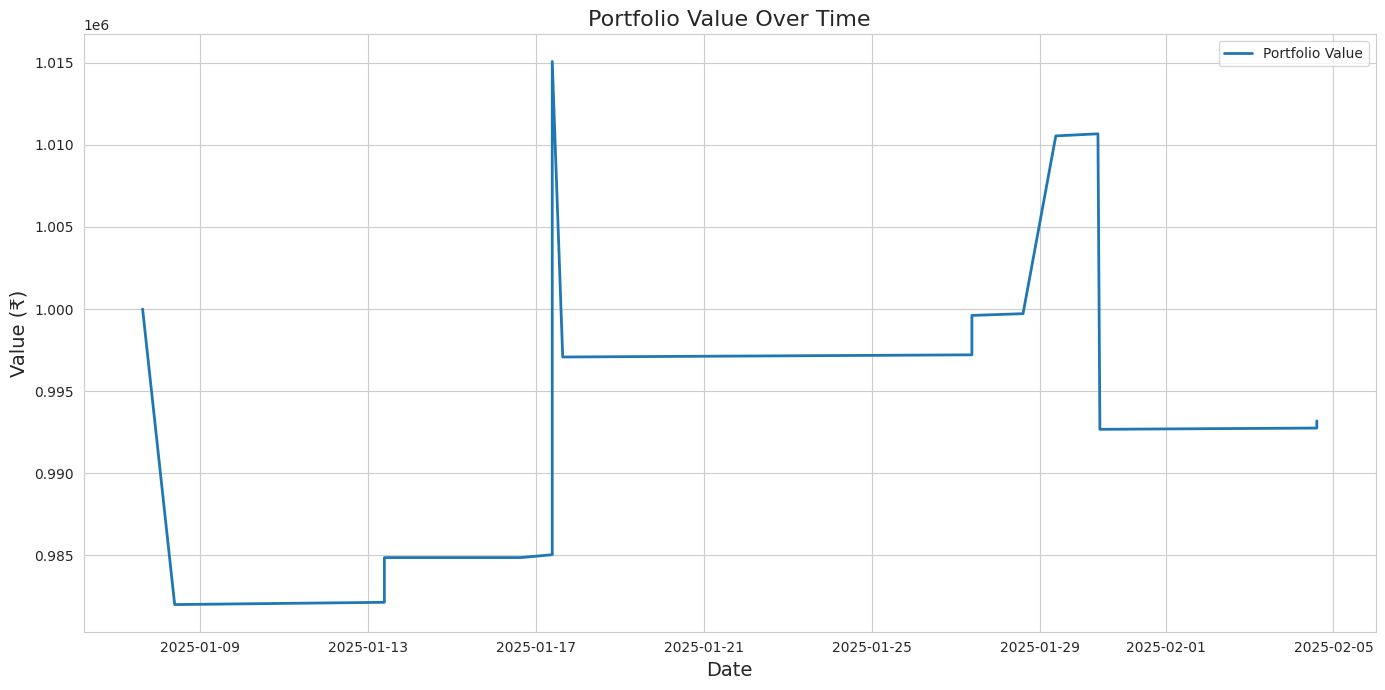

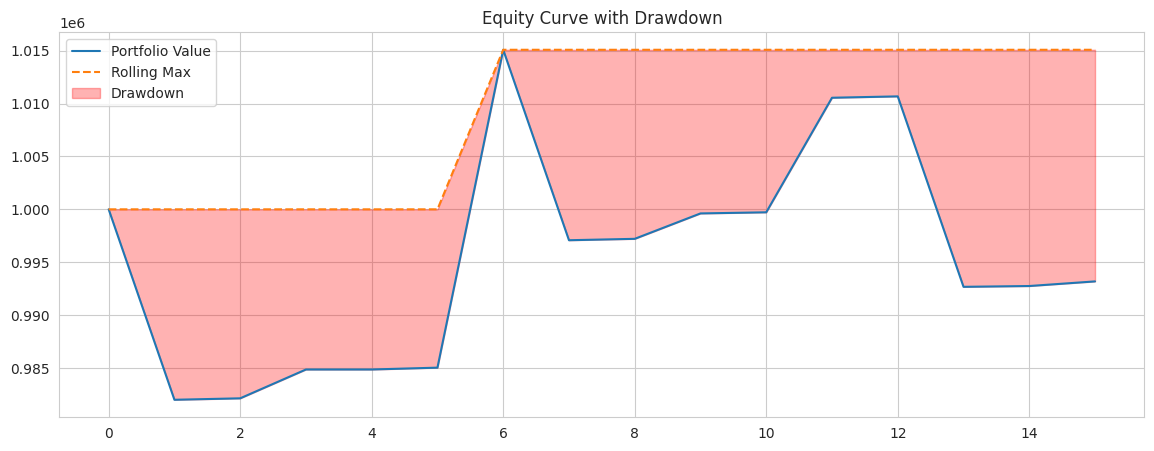

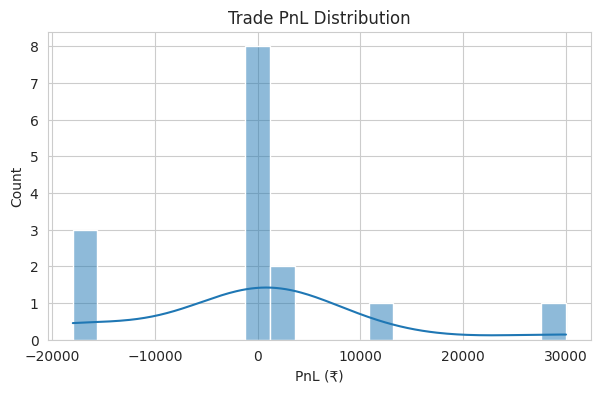

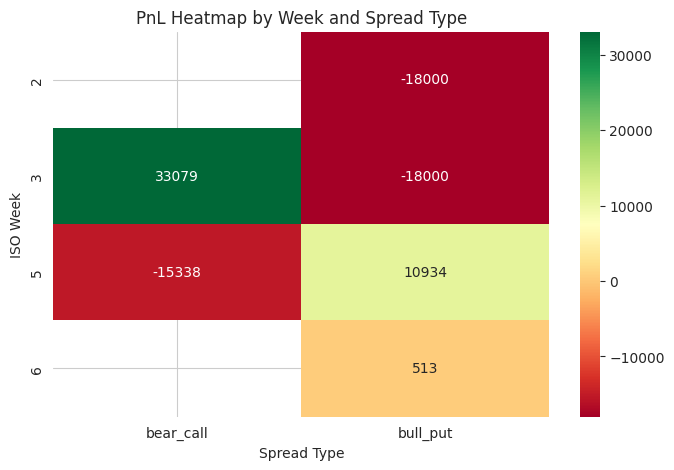

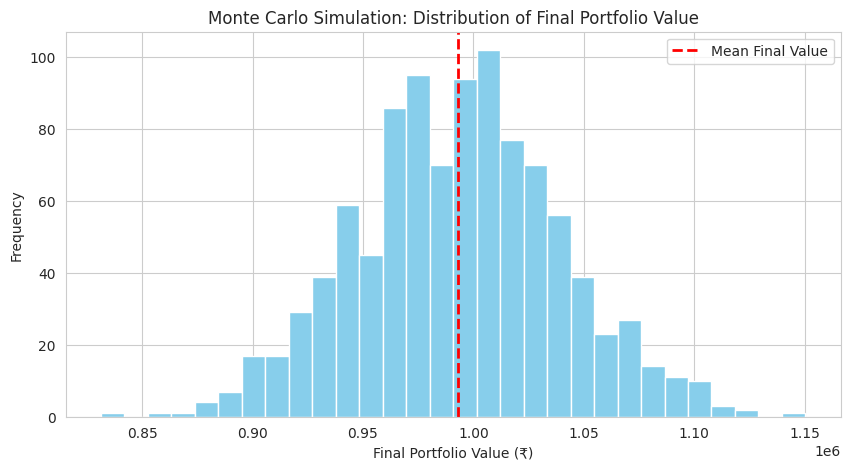

Monte Carlo: Mean Final Value = ₹993,119.74, 5th Percentile = ₹916,702.73, 95th Percentile = ₹1,071,289.89


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
ATR_PERIOD = 10
ATR_MULTIPLIER = 2.5
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001
MARKET_CLOSE_TIME = '15:25:00'
VIX_LOW = 14
VIX_HIGH = 22
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05
CONFIRM_LOOKBACK = 10
MAX_LOSS = 18000
PARTIAL_BOOK_PCT = 0.2  # 20% position booked at first TP

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ======================================================================
# STRATEGY HELPERS
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= 14:
        return 0.20  # More risk when VIX is very low
    elif vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_HIGH:
        return RISK_MED
    else:
        return RISK_HIGH

def vix_trend_filter(vix_val):
    return VIX_LOW < vix_val < VIX_HIGH

def price_breakout_confirmation(spot_data, ts, direction, lookback=CONFIRM_LOOKBACK, sma_period=21):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    mean_high = window['high'][:-1].mean()
    mean_low = window['low'][:-1].mean()
    sma21 = window['close'].rolling(window=sma_period, min_periods=1).mean().iloc[-1]
    if direction == 1:
        return last_close > mean_high and last_close > sma21
    elif direction == -1:
        return last_close < mean_low and last_close < sma21
    return False

def trend_filter(spot_data, ts, direction, sma_period=50):
    window = spot_data.loc[:ts].iloc[-sma_period:]
    if len(window) < sma_period:
        return False
    last_close = window['close'].iloc[-1]
    sma = window['close'].mean()
    if direction == 1:  # bull put
        return last_close > sma
    elif direction == -1:  # bear call
        return last_close < sma
    return False

def get_dynamic_tp(vix_val):
    # Dynamic TP: lower in low VIX, higher in high VIX
    if vix_val <= VIX_LOW + 1:
        return 0.15
    elif vix_val <= VIX_HIGH - 1:
        return 0.25
    else:
        return 0.35

# ======================================================================
# SELL-SIDE STRATEGY (CREDIT SPREADS) with partial profit booking and dynamic TP
# ======================================================================
def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], ATR_PERIOD)
    )

    for ts, row in spot_data.iterrows():
        # NO EOD CLOSE - trades only close on TP, max loss, or expiry
        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)
        # VIX trend filter (optional)
        if not vix_trend_filter(vix_val):
            prev_signal = signal
            continue
        # Trend filter: only bear call if below SMA50, only bull put if above SMA50
        if not trend_filter(spot_data, ts, signal, sma_period=50):
            prev_signal = signal
            continue
        # Confirmation
        if signal != 0 and signal != prev_signal:
            print(f"\nDEBUG: Potential entry at {ts}: signal={signal}, prev_signal={prev_signal}")
            print(f"  spot_price={spot_price}, atm_strike={atm_strike}, expiry={expiry}, vix_val={vix_val}")
            print(f"  price_breakout_confirmation={price_breakout_confirmation(spot_data, ts, signal)}")
        if open_spread is None and signal != 0 and signal != prev_signal and price_breakout_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                print(f"  DEBUG: Missing options data for spread at {ts}: short_strike={short_strike}, long_strike={long_strike}, expiry={expiry}")
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            print(f"  DEBUG: margin_per_lot={margin_per_lot}, risk_per_trade={risk_per_trade}, lots={lots}")
            if lots < 1:
                print(f"  DEBUG: Not enough capital for at least 1 lot at {ts}")
                prev_signal = signal
                continue
            # Dynamic TP based on VIX
            tp_pct = get_dynamic_tp(vix_val)
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'tp_pct': tp_pct,
                'partial_booked': False
            }
            print(f"  DEBUG: Entered spread at {ts}: {open_spread['direction']}, lots={lots}, credit={credit}, margin={margin_per_lot}, tp_pct={tp_pct}")
            prev_signal = signal
            continue

        # Manage open spread: partial profit booking, trailing, max loss, and expiry
        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                # Partial profit booking
                tp_level = open_spread['credit'] * open_spread['tp_pct']
                if not open_spread['partial_booked'] and pnl > tp_level:
                    booked_pnl = tp_level * PARTIAL_BOOK_PCT
                    portfolio_cash += booked_pnl
                    open_spread['credit'] -= booked_pnl
                    open_spread['lots'] = int(open_spread['lots'] * (1 - PARTIAL_BOOK_PCT))
                    open_spread['partial_booked'] = True
                    trade_log.append({**open_spread, 'exit_date': spread_rows_short.iloc[i]['TimeStamp'], 'exit_pnl': booked_pnl, 'exit_reason': 'Partial TP'})
                    print(f"  DEBUG: Partial profit booked at {ts}: {booked_pnl}")
                # Full TP (remaining position)
                elif pnl > tp_level and open_spread['partial_booked']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Full TP'})
                    open_spread = None
                    break
                # Max loss cap
                elif pnl < -MAX_LOSS:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += -MAX_LOSS
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': -MAX_LOSS, 'exit_reason': 'Max Loss'})
                    open_spread = None
                    break
                # Expiry close (if today is expiry and not already closed)
                elif ts.date() >= open_spread['short_leg']['expiry']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                    if pnl < -MAX_LOSS:
                        pnl = -MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Expiry'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(spot_data, signals, options_sample, vix_data)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log.csv', index=False)
    print("\nSell-side log saved.")
    print("\nTrade log preview:")
    print(sell_log_df.head())

    # Performance report and visualizations
    trade_log_df = sell_log_df
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['exit_pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{sell_brokerage:,.2f}
Total Slippage:     ₹{sell_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['exit_pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['exit_pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['exit_pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['exit_pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['exit_pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['exit_pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    trade_log_df['spread_type'] = trade_log_df['direction']
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='spread_type', values='exit_pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Spread Type")
    plt.xlabel("Spread Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['exit_pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-7-1619799301.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(



DEBUG: Potential entry at 2025-01-02 09:15:00+05:30: signal=1, prev_signal=-1
  spot_price=23787.6, atm_strike=23800, expiry=2025-01-02, vix_val=14.4475
  price_breakout_confirmation=True
  DEBUG: margin_per_lot=3025.0, risk_per_trade=0.1, lots=33
  DEBUG: Entered spread at 2025-01-02 09:15:00+05:30: bull_put, lots=33, credit=1975.0, margin=3025.0, tp_pct=0.15

DEBUG: Potential entry at 2025-01-07 09:15:00+05:30: signal=1, prev_signal=-1
  spot_price=23756.75, atm_strike=23750, expiry=2025-01-09, vix_val=15.1625
  price_breakout_confirmation=True
  DEBUG: margin_per_lot=2782.4999999999995, risk_per_trade=0.1, lots=35
  DEBUG: Entered spread at 2025-01-07 09:15:00+05:30: bull_put, lots=35, credit=2217.5000000000005, margin=2782.4999999999995, tp_pct=0.25
  DEBUG: Partial profit booked at 2025-01-07 09:16:00+05:30: 110.87500000000003

DEBUG: Potential entry at 2025-01-15 09:15:00+05:30: signal=1, prev_signal=-1
  spot_price=23240.9, atm_strike=23250, expiry=2025-01-16, vix_val=15.61
  p

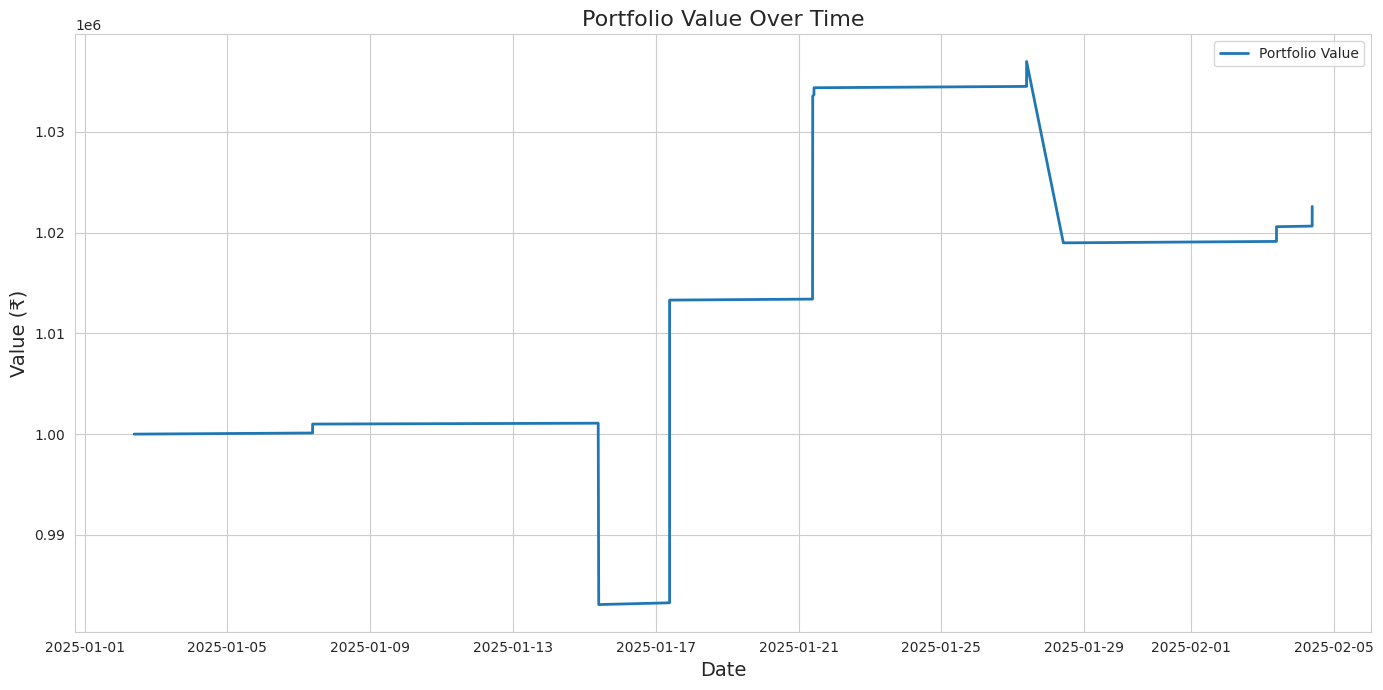

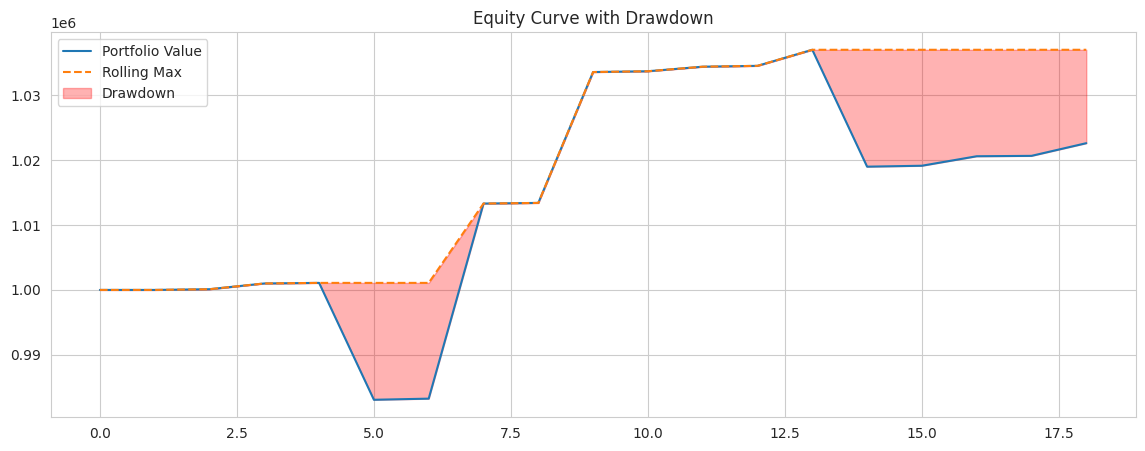

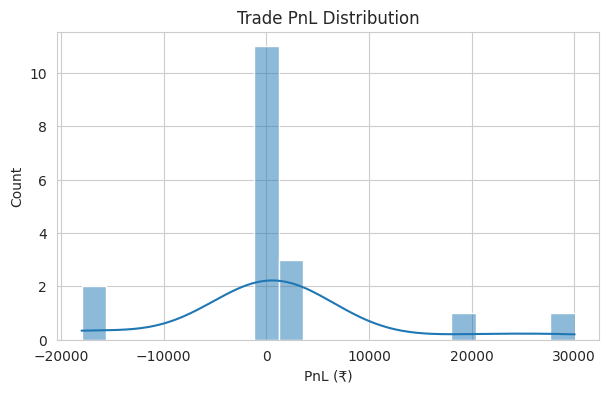

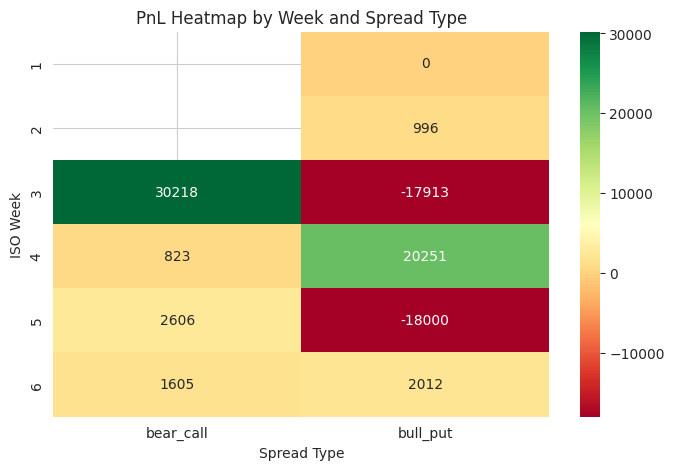

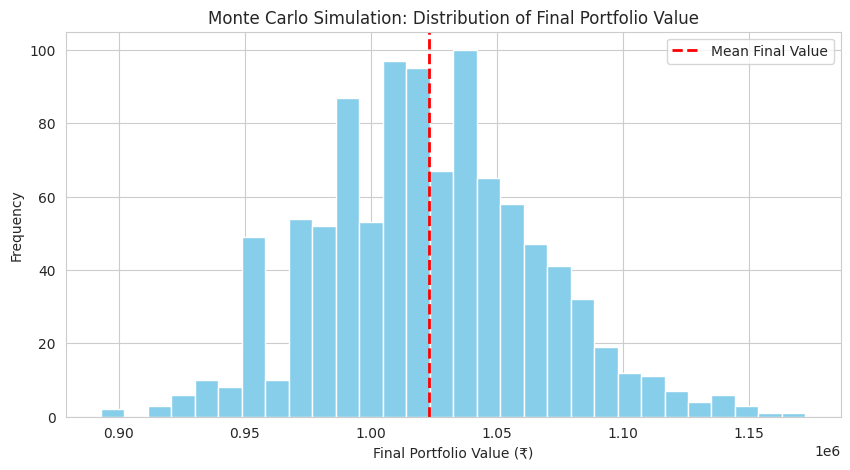

Monte Carlo: Mean Final Value = ₹1,022,886.59, 5th Percentile = ₹954,360.08, 95th Percentile = ₹1,093,895.54


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
ATR_PERIOD = 10
ATR_MULTIPLIER = 2.5
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001
MARKET_CLOSE_TIME = '15:25:00'
VIX_LOW = 14
VIX_HIGH = 22
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05
CONFIRM_LOOKBACK = 10
MAX_LOSS = 18000
PARTIAL_BOOK_PCT = 0.2  # 20% position booked at first TP

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min_50_200.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ======================================================================
# STRATEGY HELPERS
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= 14:
        return 0.20  # More risk when VIX is very low
    elif vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_HIGH:
        return RISK_MED
    else:
        return RISK_HIGH

def vix_trend_filter(vix_val):
    return VIX_LOW < vix_val < VIX_HIGH

def price_breakout_confirmation(spot_data, ts, direction, lookback=CONFIRM_LOOKBACK, sma_period=21):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    mean_high = window['high'][:-1].mean()
    mean_low = window['low'][:-1].mean()
    sma21 = window['close'].rolling(window=sma_period, min_periods=1).mean().iloc[-1]
    if direction == 1:
        return last_close > mean_high and last_close > sma21
    elif direction == -1:
        return last_close < mean_low and last_close < sma21
    return False

def trend_filter(spot_data, ts, direction, sma_period=50):
    window = spot_data.loc[:ts].iloc[-sma_period:]
    if len(window) < sma_period:
        return False
    last_close = window['close'].iloc[-1]
    sma = window['close'].mean()
    if direction == 1:  # bull put
        return last_close > sma
    elif direction == -1:  # bear call
        return last_close < sma
    return False

def get_dynamic_tp(vix_val):
    # Dynamic TP: lower in low VIX, higher in high VIX
    if vix_val <= VIX_LOW + 1:
        return 0.15
    elif vix_val <= VIX_HIGH - 1:
        return 0.25
    else:
        return 0.35

# ======================================================================
# SELL-SIDE STRATEGY (CREDIT SPREADS) with partial profit booking and dynamic TP
# ======================================================================
def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], ATR_PERIOD)
    )

    for ts, row in spot_data.iterrows():
        # NO EOD CLOSE - trades only close on TP, max loss, or expiry
        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade(vix_val)
        # VIX trend filter (optional)
        if not vix_trend_filter(vix_val):
            prev_signal = signal
            continue
        # Trend filter: only bear call if below SMA50, only bull put if above SMA50
        if not trend_filter(spot_data, ts, signal, sma_period=50):
            prev_signal = signal
            continue
        # Confirmation
        if signal != 0 and signal != prev_signal:
            print(f"\nDEBUG: Potential entry at {ts}: signal={signal}, prev_signal={prev_signal}")
            print(f"  spot_price={spot_price}, atm_strike={atm_strike}, expiry={expiry}, vix_val={vix_val}")
            print(f"  price_breakout_confirmation={price_breakout_confirmation(spot_data, ts, signal)}")
        if open_spread is None and signal != 0 and signal != prev_signal and price_breakout_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                print(f"  DEBUG: Missing options data for spread at {ts}: short_strike={short_strike}, long_strike={long_strike}, expiry={expiry}")
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            print(f"  DEBUG: margin_per_lot={margin_per_lot}, risk_per_trade={risk_per_trade}, lots={lots}")
            if lots < 1:
                print(f"  DEBUG: Not enough capital for at least 1 lot at {ts}")
                prev_signal = signal
                continue
            # Dynamic TP based on VIX
            tp_pct = get_dynamic_tp(vix_val)
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'tp_pct': tp_pct,
                'partial_booked': False
            }
            print(f"  DEBUG: Entered spread at {ts}: {open_spread['direction']}, lots={lots}, credit={credit}, margin={margin_per_lot}, tp_pct={tp_pct}")
            prev_signal = signal
            continue

        # Manage open spread: partial profit booking, trailing, max loss, and expiry
        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                # Partial profit booking
                tp_level = open_spread['credit'] * open_spread['tp_pct']
                if not open_spread['partial_booked'] and pnl > tp_level:
                    booked_pnl = tp_level * PARTIAL_BOOK_PCT
                    portfolio_cash += booked_pnl
                    open_spread['credit'] -= booked_pnl
                    open_spread['lots'] = int(open_spread['lots'] * (1 - PARTIAL_BOOK_PCT))
                    open_spread['partial_booked'] = True
                    trade_log.append({**open_spread, 'exit_date': spread_rows_short.iloc[i]['TimeStamp'], 'exit_pnl': booked_pnl, 'exit_reason': 'Partial TP'})
                    print(f"  DEBUG: Partial profit booked at {ts}: {booked_pnl}")
                # Full TP (remaining position)
                elif pnl > tp_level and open_spread['partial_booked']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Full TP'})
                    open_spread = None
                    break
                # Max loss cap
                elif pnl < -MAX_LOSS:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += -MAX_LOSS
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': -MAX_LOSS, 'exit_reason': 'Max Loss'})
                    open_spread = None
                    break
                # Expiry close (if today is expiry and not already closed)
                elif ts.date() >= open_spread['short_leg']['expiry']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                    if pnl < -MAX_LOSS:
                        pnl = -MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Expiry'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(spot_data, signals, options_sample, vix_data)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log_50_200.csv', index=False)
    print("\nSell-side log saved.")
    print("\nTrade log preview:")
    print(sell_log_df.head())

    # Performance report and visualizations
    trade_log_df = sell_log_df
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['exit_pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{sell_brokerage:,.2f}
Total Slippage:     ₹{sell_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['exit_pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['exit_pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['exit_pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['exit_pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['exit_pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['exit_pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    trade_log_df['spread_type'] = trade_log_df['direction']
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='spread_type', values='exit_pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Spread Type")
    plt.xlabel("Spread Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['exit_pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...
Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-4-2210840016.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(


Sell-side trade log saved.

Executing BUY-SIDE (OPTION BUYING) strategy...


/tmp/ipython-input-4-2210840016.py:337: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_atr(x, BUY_ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)


Buy-side trade log saved.

COMBINED STRATEGY PERFORMANCE REPORT
-------------------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹1,243,895.48
Total Return:       24.39%
Max Drawdown:       ₹15,164.09
Sharpe Ratio:       4.15
Sortino Ratio:      15.96
Calmar Ratio:       404.21
Total Brokerage:    ₹280.00
Total Slippage:     ₹1,324.14

Trade Statistics:
-----------------
Total Trades:       27
Buy Trades:         9
Sell Trades:        18
Winning Trades:     23
Losing Trades:      4
Avg PnL:            ₹9,033.17
Best Trade:         ₹169,951.46
Worst Trade:        ₹-18,000.00
Trade Period:       2025-01-02 to 2025-02-06



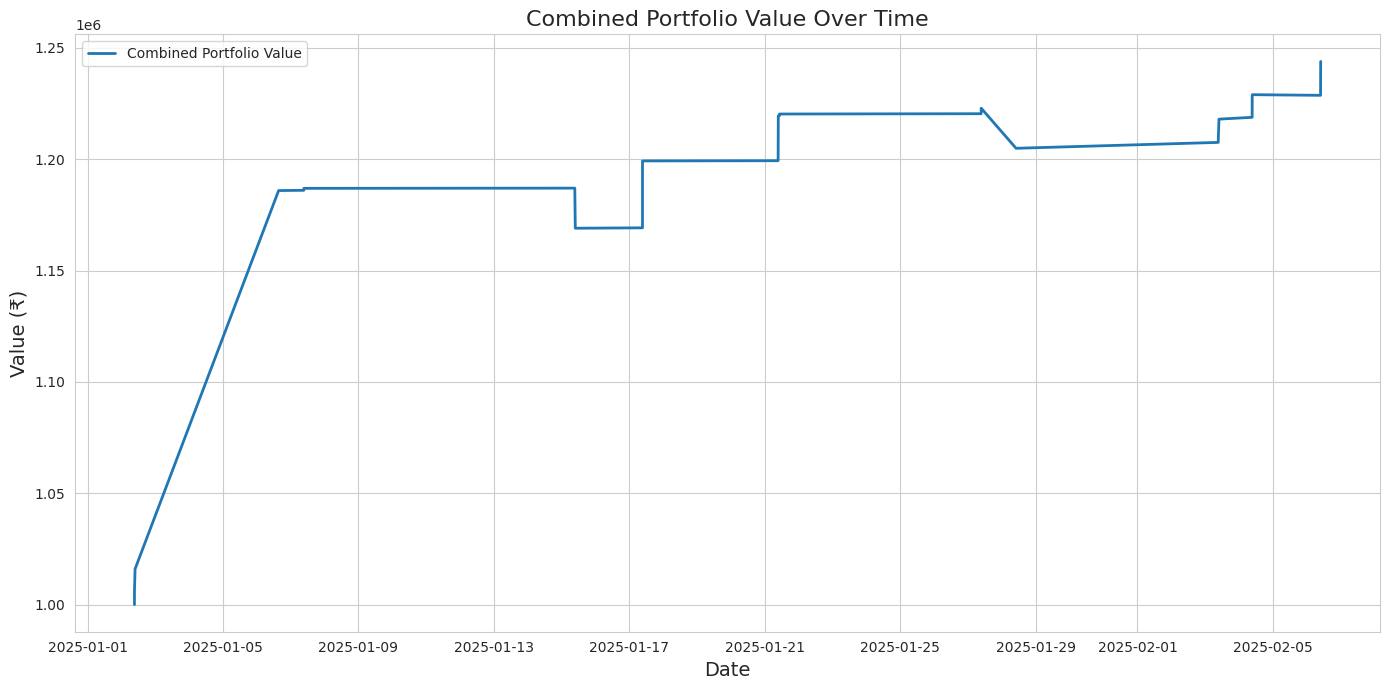

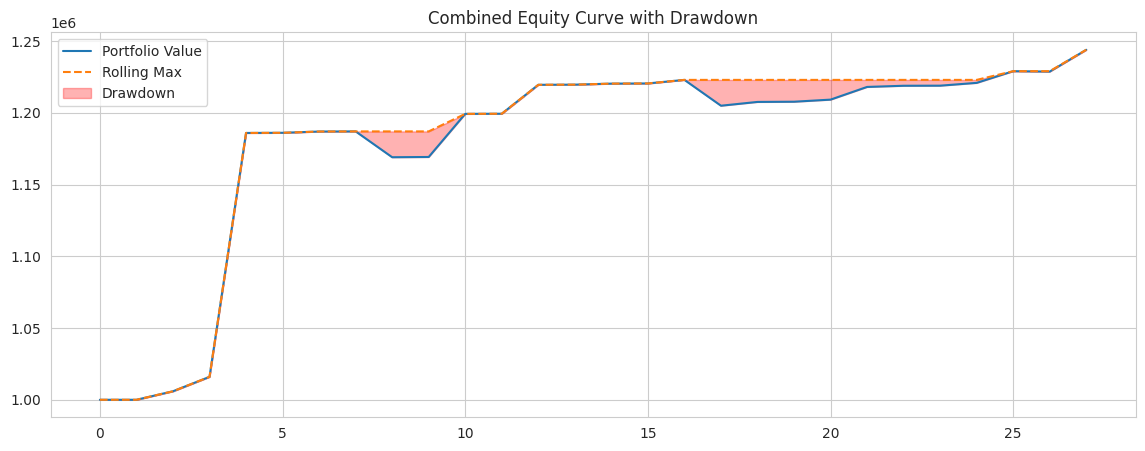

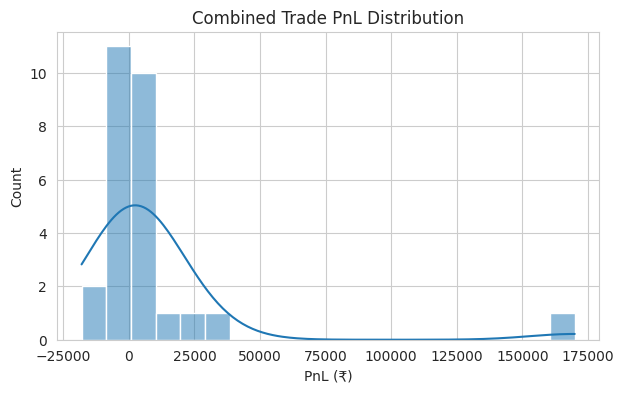

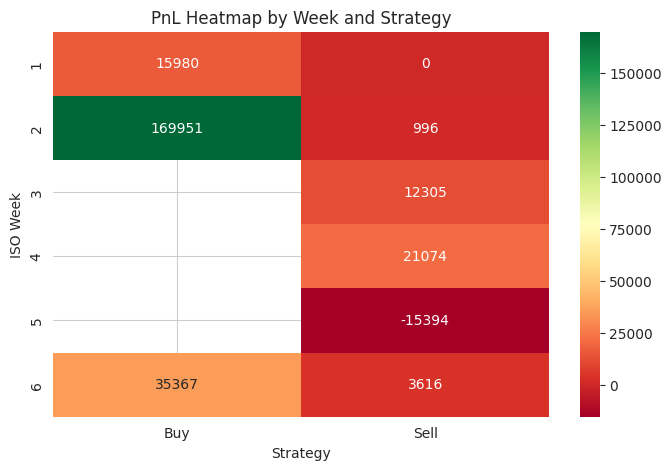

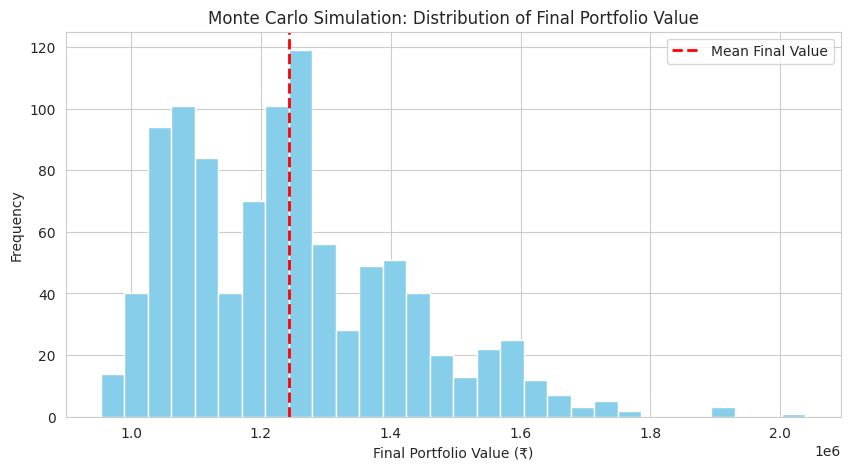

Monte Carlo: Mean Final Value = ₹1,243,977.15, 5th Percentile = ₹1,024,807.35, 95th Percentile = ₹1,580,535.45


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# CONFIGURATION
# ==============================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50

# --- SELL-SIDE config ---
SELL_ATR_PERIOD = 10
SELL_ATR_MULTIPLIER = 2.5
SELL_BROKERAGE_PER_ORDER = 20
SELL_SLIPPAGE_PCT = 0.001
SELL_MARKET_CLOSE_TIME = '15:25:00'
SELL_VIX_LOW = 14
SELL_VIX_HIGH = 22
SELL_RISK_LOW = 0.15
SELL_RISK_MED = 0.10
SELL_RISK_HIGH = 0.05
SELL_CONFIRM_LOOKBACK = 10
SELL_MAX_LOSS = 18000
SELL_PARTIAL_BOOK_PCT = 0.2

# --- BUY-SIDE config ---
BUY_PARTIAL_TP_PCT = 0.15
BUY_FINAL_TP_PCT_LOW = 0.20
BUY_FINAL_TP_PCT_HIGH = 0.40
BUY_ATR_PERIOD = 10
BUY_ATR_MULTIPLIER = 2.5
BUY_MAX_LOSS = 25000
BUY_BROKERAGE_PER_ORDER = 20
BUY_SLIPPAGE_PCT = 0.001
BUY_MARKET_CLOSE_TIME = '15:25:00'
BUY_VIX_LOW = 13
BUY_VIX_MED = 17
BUY_RISK_LOW = 0.15
BUY_RISK_MED = 0.10
BUY_RISK_HIGH = 0.05
BUY_IVR_THRESHOLD = 40

# ==============================
# DATA LOADING (shared)
# ==============================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min_50_200.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ==============================
# SELL-SIDE STRATEGY HELPERS & LOGIC
# (from paste.txt)
# ==============================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=SELL_ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade_sell(vix_value):
    if vix_value <= 14:
        return 0.20
    elif vix_value <= SELL_VIX_LOW:
        return SELL_RISK_LOW
    elif vix_value <= SELL_VIX_HIGH:
        return SELL_RISK_MED
    else:
        return SELL_RISK_HIGH

def vix_trend_filter(vix_val):
    return SELL_VIX_LOW < vix_val < SELL_VIX_HIGH

def price_breakout_confirmation(spot_data, ts, direction, lookback=SELL_CONFIRM_LOOKBACK, sma_period=21):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    mean_high = window['high'][:-1].mean()
    mean_low = window['low'][:-1].mean()
    sma21 = window['close'].rolling(window=sma_period, min_periods=1).mean().iloc[-1]
    if direction == 1:
        return last_close > mean_high and last_close > sma21
    elif direction == -1:
        return last_close < mean_low and last_close < sma21
    return False

def trend_filter(spot_data, ts, direction, sma_period=50):
    window = spot_data.loc[:ts].iloc[-sma_period:]
    if len(window) < sma_period:
        return False
    last_close = window['close'].iloc[-1]
    sma = window['close'].mean()
    if direction == 1:
        return last_close > sma
    elif direction == -1:
        return last_close < sma
    return False

def get_dynamic_tp(vix_val):
    if vix_val <= SELL_VIX_LOW + 1:
        return 0.15
    elif vix_val <= SELL_VIX_HIGH - 1:
        return 0.25
    else:
        return 0.35

def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], SELL_ATR_PERIOD)
    )
    for ts, row in spot_data.iterrows():
        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade_sell(vix_val)
        if not vix_trend_filter(vix_val):
            prev_signal = signal
            continue
        if not trend_filter(spot_data, ts, signal, sma_period=50):
            prev_signal = signal
            continue
        if open_spread is None and signal != 0 and signal != prev_signal and price_breakout_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            if lots < 1:
                prev_signal = signal
                continue
            tp_pct = get_dynamic_tp(vix_val)
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'tp_pct': tp_pct,
                'partial_booked': False
            }
            prev_signal = signal
            continue
        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                tp_level = open_spread['credit'] * open_spread['tp_pct']
                if not open_spread['partial_booked'] and pnl > tp_level:
                    booked_pnl = tp_level * SELL_PARTIAL_BOOK_PCT
                    portfolio_cash += booked_pnl
                    open_spread['credit'] -= booked_pnl
                    open_spread['lots'] = int(open_spread['lots'] * (1 - SELL_PARTIAL_BOOK_PCT))
                    open_spread['partial_booked'] = True
                    trade_log.append({**open_spread, 'exit_date': spread_rows_short.iloc[i]['TimeStamp'], 'exit_pnl': booked_pnl, 'exit_reason': 'Partial TP'})
                elif pnl > tp_level and open_spread['partial_booked']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Full TP'})
                    open_spread = None
                    break
                elif pnl < -SELL_MAX_LOSS:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += -SELL_MAX_LOSS
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': -SELL_MAX_LOSS, 'exit_reason': 'Max Loss'})
                    open_spread = None
                    break
                elif ts.date() >= open_spread['short_leg']['expiry']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                    if pnl < -SELL_MAX_LOSS:
                        pnl = -SELL_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Expiry'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ==============================
# BUY-SIDE STRATEGY HELPERS & LOGIC
# (from paste-2.txt)
# ==============================
def compute_iv_rank(option_df, window=252):
    option_df = option_df.copy()
    option_df['IVR'] = option_df['IV'].rolling(window).apply(
        lambda x: 100 * (x[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0,
        raw=True
    )
    return option_df

def get_risk_per_trade_buy(vix_value):
    if vix_value <= BUY_VIX_LOW:
        return BUY_RISK_LOW
    elif vix_value <= BUY_VIX_MED:
        return BUY_RISK_MED
    else:
        return BUY_RISK_HIGH

def execute_trades_15min_atr_trailing_vix(
    spot_data, signals, options_data, vix_data,
    partial_tp_pct=BUY_PARTIAL_TP_PCT, tp_pct_low=BUY_FINAL_TP_PCT_LOW, tp_pct_high=BUY_FINAL_TP_PCT_HIGH,
    brokerage_per_order=BUY_BROKERAGE_PER_ORDER, slippage_pct=BUY_SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_position = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'])\
        .apply(lambda x: compute_atr(x, BUY_ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)
    if 'IV' in options_data.columns:
        options_data = options_data.groupby(['Strike', 'Type', 'Expiry']).apply(compute_iv_rank).reset_index(drop=True)
    else:
        options_data['IVR'] = 0
    for ts, row in spot_data.iterrows():
        if ts.time() >= datetime.strptime(BUY_MARKET_CLOSE_TIME, '%H:%M:%S').time():
            if open_position is not None:
                exit_row = options_data[
                    (options_data['Strike'] == open_position['strike']) &
                    (options_data['Type'] == open_position['type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_row.empty:
                    exit_price = float(exit_row.iloc[0]['Close'])
                    exit_time = exit_row.iloc[0]['TimeStamp']
                    exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                    total_slippage += exit_slippage
                    total_brokerage += brokerage_per_order
                    exit_price_adj = exit_price - exit_price * slippage_pct
                    pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                    pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                    if pnl < -BUY_MAX_LOSS:
                        pnl = -BUY_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': open_position['entry_date'],
                        'entry_time': open_position['entry_time'],
                        'exit_date': exit_time,
                        'action': open_position['action'],
                        'type': open_position['type'],
                        'strike': open_position['strike'],
                        'entry_price': open_position['entry_price'],
                        'exit_price': exit_price_adj,
                        'lots': open_position['lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': open_position['spot'],
                        'expiry': open_position['expiry'],
                        'exit_reason': 'EOD Close'
                    })
                    open_position = None
            continue
        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            prev_signal = signal
            continue
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        vix_ma20 = vix_data['Close'].rolling(20*24*4, min_periods=1).mean().loc[ts]
        ivr = 0
        option_rows = options_data[
            (options_data['Strike'] == strike) &
            (options_data['Type'] == option_type) &
            (options_data['Expiry'].dt.date == expiry) &
            (options_data['TimeStamp'] <= ts)
        ].sort_values('TimeStamp')
        if not option_rows.empty and 'IVR' in option_rows.columns:
            ivr = float(option_rows.iloc[-1]['IVR'])
        if vix_val >= vix_ma20 or ivr >= BUY_IVR_THRESHOLD:
            prev_signal = signal
            continue
        if vix_val <= BUY_VIX_LOW:
            final_tp_pct = tp_pct_low
        elif vix_val > BUY_VIX_MED:
            final_tp_pct = tp_pct_high
        else:
            final_tp_pct = tp_pct_low + (tp_pct_high - tp_pct_low) * ((vix_val - BUY_VIX_LOW)/(BUY_VIX_MED - BUY_VIX_LOW))
        risk_per_trade = get_risk_per_trade_buy(vix_val)
        if open_position is None and signal != 0 and signal != prev_signal:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                prev_signal = signal
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                prev_signal = signal
                continue
            partial_tp_price = entry_price * (1 + partial_tp_pct)
            final_tp_price = entry_price * (1 + final_tp_pct)
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct
            atr = float(entry_row.iloc[0]['ATR'])
            trailing_stop = entry_price_adj - BUY_ATR_MULTIPLIER * atr
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'partial_tp_price': partial_tp_price,
                'final_tp_price': final_tp_price,
                'trailing_stop': trailing_stop,
                'max_loss_stop': entry_price_adj - (BUY_MAX_LOSS / (lot_size * lots)),
                'entry_slippage': entry_slippage,
                'highest_price': entry_price_adj,
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'ivr_at_entry': ivr,
                'partial_booked': False,
                'partial_lots': lots // 2,
                'final_lots': lots - (lots // 2)
            }
            prev_signal = signal
            continue
        if open_position is not None:
            exit_reason = None
            exit_price = None
            exit_time = None
            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for _, opt_row in option_rows.iterrows():
                price = float(opt_row['Close'])
                atr = float(opt_row['ATR'])
                if price > open_position['highest_price']:
                    open_position['highest_price'] = price
                trailing_stop = open_position['highest_price'] - BUY_ATR_MULTIPLIER * atr
                open_position['trailing_stop'] = max(open_position['trailing_stop'], trailing_stop)
                if not open_position['partial_booked'] and price >= open_position['partial_tp_price']:
                    exit_slippage = price * slippage_pct * lot_size * open_position['partial_lots']
                    total_slippage += exit_slippage
                    total_brokerage += brokerage_per_order
                    exit_price_adj = price - price * slippage_pct
                    pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['partial_lots']
                    pnl -= (open_position['entry_slippage'] * (open_position['partial_lots']/open_position['lots']) + exit_slippage + 2 * brokerage_per_order)
                    if pnl < -BUY_MAX_LOSS:
                        pnl = -BUY_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': open_position['entry_date'],
                        'entry_time': open_position['entry_time'],
                        'exit_date': opt_row['TimeStamp'],
                        'action': open_position['action'],
                        'type': open_position['type'],
                        'strike': open_position['strike'],
                        'entry_price': open_position['entry_price'],
                        'exit_price': exit_price_adj,
                        'lots': open_position['partial_lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': open_position['spot'],
                        'expiry': open_position['expiry'],
                        'exit_reason': 'Partial TP',
                        'risk_per_trade': open_position['risk_per_trade'],
                        'vix_at_entry': open_position['vix_at_entry'],
                        'ivr_at_entry': open_position['ivr_at_entry']
                    })
                    open_position['partial_booked'] = True
                    open_position['final_lots'] = open_position['final_lots']
                    continue
                if open_position['partial_booked'] and price >= open_position['final_tp_price']:
                    exit_price = open_position['final_tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Final TP'
                    break
                elif open_position['partial_booked'] and price <= open_position['trailing_stop']:
                    exit_price = open_position['trailing_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Trailing Stop'
                    break
                elif open_position['partial_booked'] and price <= open_position['max_loss_stop']:
                    exit_price = open_position['max_loss_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Max Loss Stop'
                    break
            if exit_reason is None and open_position['partial_booked'] and ts.time() >= datetime.strptime(BUY_MARKET_CLOSE_TIME, '%H:%M:%S').time():
                last_row = option_rows.iloc[-1] if not option_rows.empty else None
                if last_row is not None:
                    exit_price = float(last_row['Close'])
                    exit_time = last_row['TimeStamp']
                    exit_reason = 'EOD Close'
            if open_position['partial_booked'] and exit_reason is not None and exit_price is not None:
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['final_lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['final_lots']
                pnl -= (open_position['entry_slippage'] * (open_position['final_lots']/open_position['lots']) + exit_slippage + 2 * brokerage_per_order)
                if pnl < -BUY_MAX_LOSS:
                    pnl = -BUY_MAX_LOSS
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['final_lots'],
                    'pnl': pnl,
                    'holding_days': 0,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason,
                    'risk_per_trade': open_position['risk_per_trade'],
                    'vix_at_entry': open_position['vix_at_entry'],
                    'ivr_at_entry': open_position['ivr_at_entry']
                })
                open_position = None
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage

# ==============================
# MAIN EXECUTION FLOW
# ==============================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("Options sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

# --- Run SELL-SIDE ---
print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(
    spot_data, signals, options_sample, vix_data
)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log_50_200.csv', index=False)
    print("Sell-side trade log saved.")

# --- Run BUY-SIDE ---
print("\nExecuting BUY-SIDE (OPTION BUYING) strategy...")
buy_log, buy_brokerage, buy_slippage = execute_trades_15min_atr_trailing_vix(
    spot_data, signals, options_sample, vix_data
)
buy_log_df = pd.DataFrame(buy_log)
if not buy_log_df.empty:
    buy_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_buy_side_log_50_200.csv', index=False)
    print("Buy-side trade log saved.")

# ==============================
# COMBINED PORTFOLIO REPORT
# ==============================
if not sell_log_df.empty:
    sell_log_df['exit_pnl'] = sell_log_df['exit_pnl'].astype(float)
    sell_log_df['exit_date'] = pd.to_datetime(sell_log_df['exit_date'])
    sell_log_df['strategy'] = 'Sell'
    sell_log_df['pnl'] = sell_log_df['exit_pnl']
    sell_log_df['exit_time'] = sell_log_df['exit_date']
if not buy_log_df.empty:
    buy_log_df['pnl'] = buy_log_df['pnl'].astype(float)
    buy_log_df['exit_date'] = pd.to_datetime(buy_log_df['exit_date'])
    buy_log_df['strategy'] = 'Buy'
    buy_log_df['exit_time'] = buy_log_df['exit_date']

combined_log = pd.concat([
    sell_log_df[['exit_time', 'pnl', 'strategy']] if not sell_log_df.empty else pd.DataFrame(),
    buy_log_df[['exit_time', 'pnl', 'strategy']] if not buy_log_df.empty else pd.DataFrame(),
])
combined_log = combined_log.sort_values('exit_time').reset_index(drop=True)

portfolio_values = [initial_capital]
portfolio_dates = [combined_log['exit_time'].iloc[0] if not combined_log.empty else pd.Timestamp(start_date)]
current_value = initial_capital
for i, row in combined_log.iterrows():
    current_value += row['pnl']
    portfolio_values.append(current_value)
    portfolio_dates.append(row['exit_time'])

returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = abs(drawdown.min()) * initial_capital
years = len(portfolio_values) / 252
cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

print(f"""
COMBINED STRATEGY PERFORMANCE REPORT
-------------------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{(sell_brokerage + buy_brokerage):,.2f}
Total Slippage:     ₹{(sell_slippage + buy_slippage):,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(combined_log)}
Buy Trades:         {len(buy_log_df) if not buy_log_df.empty else 0}
Sell Trades:        {len(sell_log_df) if not sell_log_df.empty else 0}
Winning Trades:     {(combined_log['pnl'] > 0).sum()}
Losing Trades:      {(combined_log['pnl'] <= 0).sum()}
Avg PnL:            ₹{combined_log['pnl'].mean():,.2f}
Best Trade:         ₹{combined_log['pnl'].max():,.2f}
Worst Trade:        ₹{combined_log['pnl'].min():,.2f}
Trade Period:       {combined_log['exit_time'].min().date()} to {combined_log['exit_time'].max().date()}
""")

# ==============================
# VISUALIZATIONS (COMBINED)
# ==============================
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(portfolio_dates, portfolio_values, label='Combined Portfolio Value', linewidth=2)
plt.title('Combined Portfolio Value Over Time', fontsize=16)
plt.ylabel('Value (₹)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(cumulative, label='Portfolio Value')
plt.plot(rolling_max, '--', label='Rolling Max')
plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Combined Equity Curve with Drawdown")
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(combined_log['pnl'], bins=20, kde=True)
plt.title("Combined Trade PnL Distribution")
plt.xlabel("PnL (₹)")
plt.ylabel("Count")
plt.show()

combined_log['exit_week'] = pd.to_datetime(combined_log['exit_time']).dt.isocalendar().week
heatmap_data = combined_log.pivot_table(index='exit_week', columns='strategy', values='pnl', aggfunc='sum')
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
plt.title("PnL Heatmap by Week and Strategy")
plt.xlabel("Strategy")
plt.ylabel("ISO Week")
plt.show()

n_sim = 1000
sim_length = len(combined_log)
sim_results = []
for _ in range(n_sim):
    sim_pnls = np.random.choice(combined_log['pnl'], size=sim_length, replace=True)
    sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
    sim_results.append(sim_curve[-1])
plt.figure(figsize=(10, 5))
plt.hist(sim_results, bins=30, color='skyblue')
plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
plt.xlabel("Final Portfolio Value (₹)")
plt.ylabel("Frequency")
plt.legend()
plt.show()
print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

# ==============================
# OUTPUT: CSVs
# ==============================
# Both logs are already saved as CSVs in their original format.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 1-min signals...
Signals shape: (53655, 1)

Loading options sample...

Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing trades 1-min with ATR trailing stop, partial/final TP, max loss cap, VIX/IVR-based risk management, and dynamic lot limiting...


/tmp/ipython-input-5-24012328.py:148: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_atr(x, ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)



Detailed trade log saved to Jan_Feb_detailed_trade_log_1min_atr_trailing_tp_partial_final_maxloss_vix_ivr_lots.csv
                 entry_date                entry_time  \
0 2025-01-01 10:42:00+05:30 2025-01-01 10:42:00+05:30   
1 2025-01-01 10:42:00+05:30 2025-01-01 10:42:00+05:30   

                  exit_date action type  strike  entry_price  exit_price  \
0 2025-01-01 10:48:00+05:30    Buy   CE   23650     151.7516  178.771050   
1 2025-01-01 10:49:00+05:30    Buy   CE   23650     151.7516  193.475331   

   lots         pnl  holding_days     spot      expiry exit_reason  \
0     6   7966.6700             0  23655.6  2025-01-02  Partial TP   
1     7  14442.4617             0  23655.6  2025-01-02    Final TP   

   risk_per_trade  vix_at_entry  ivr_at_entry  
0             0.1         14.55           0.0  
1             0.1         14.55           0.0  

Strategy Performance Report:
-----------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹1,022,409.13


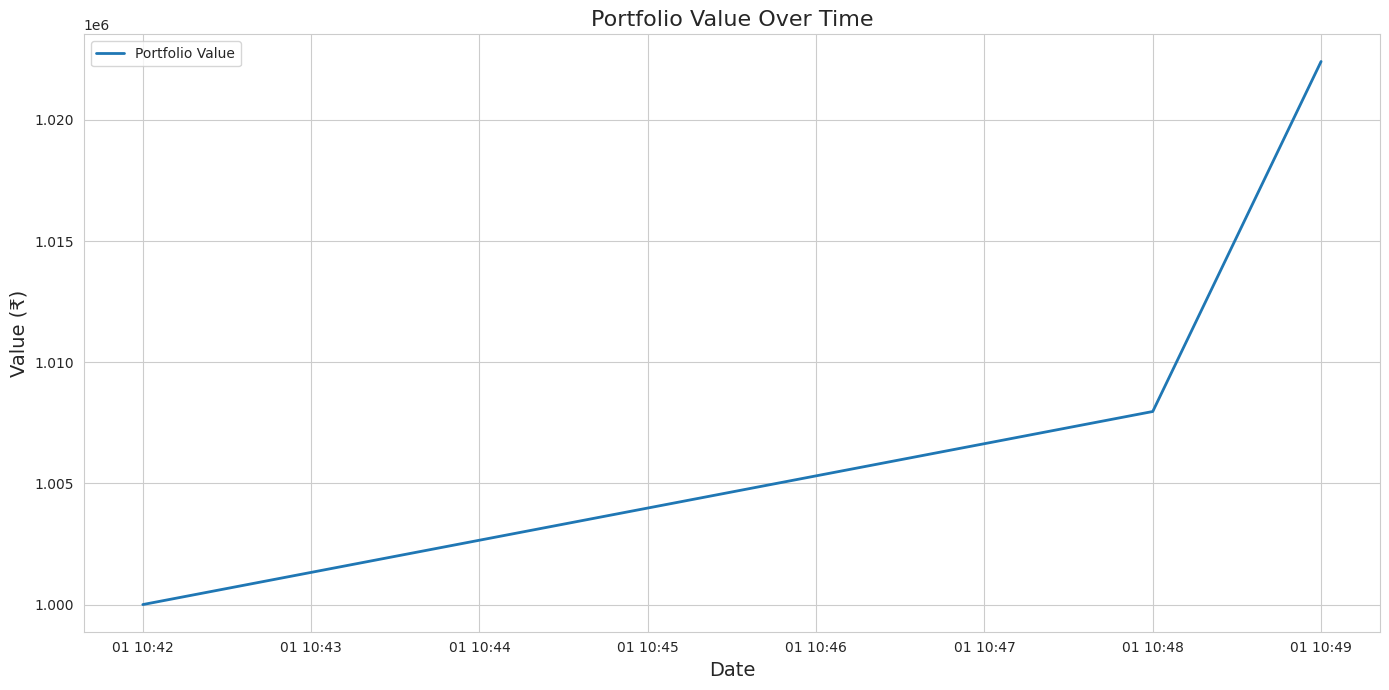

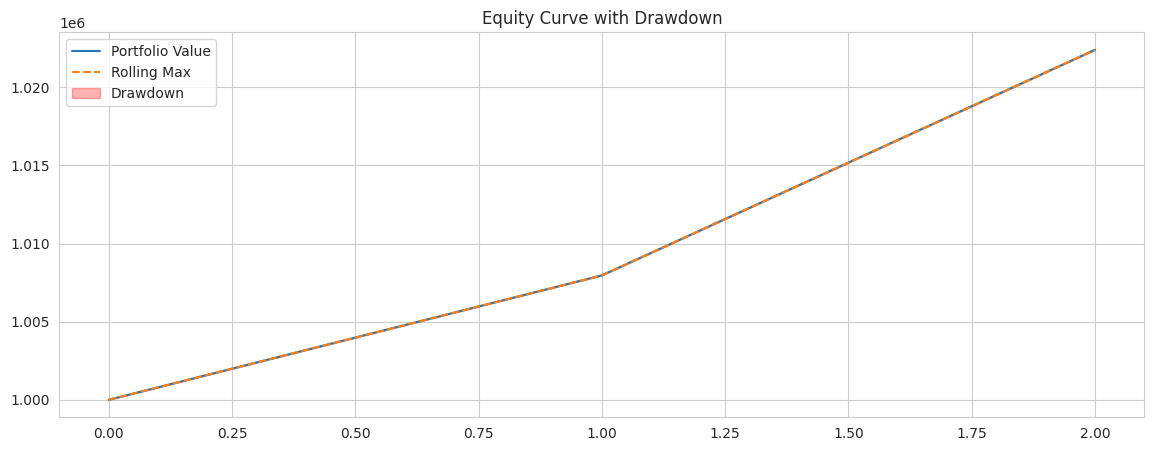

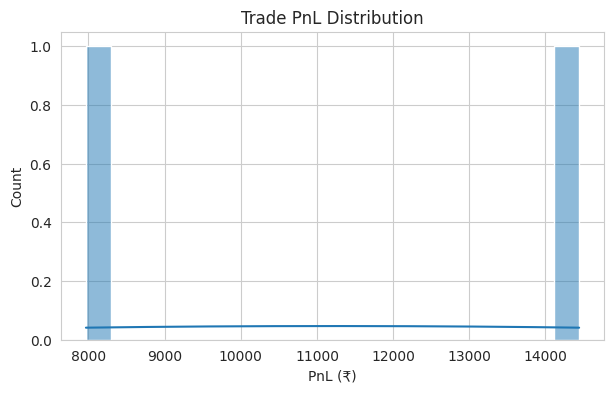

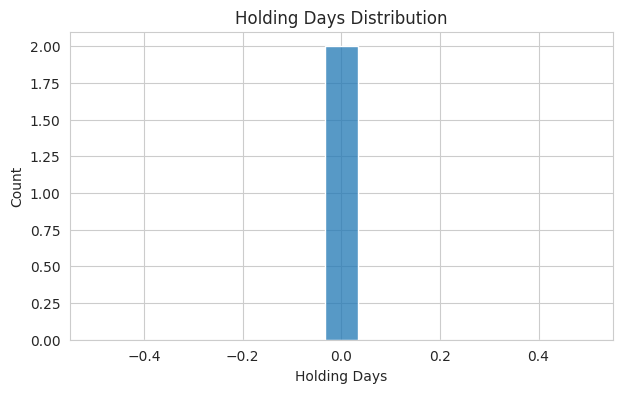

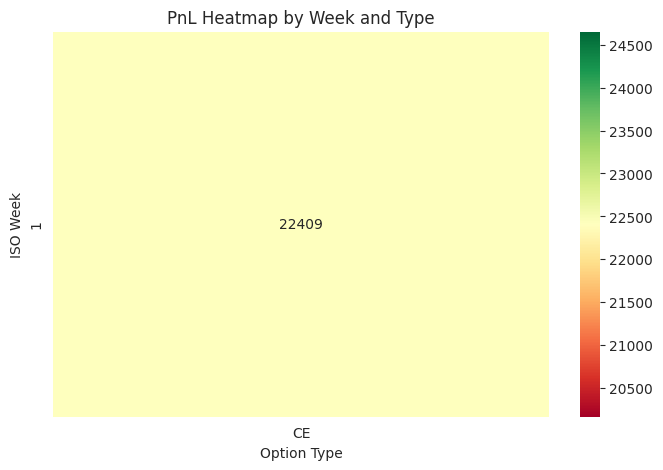

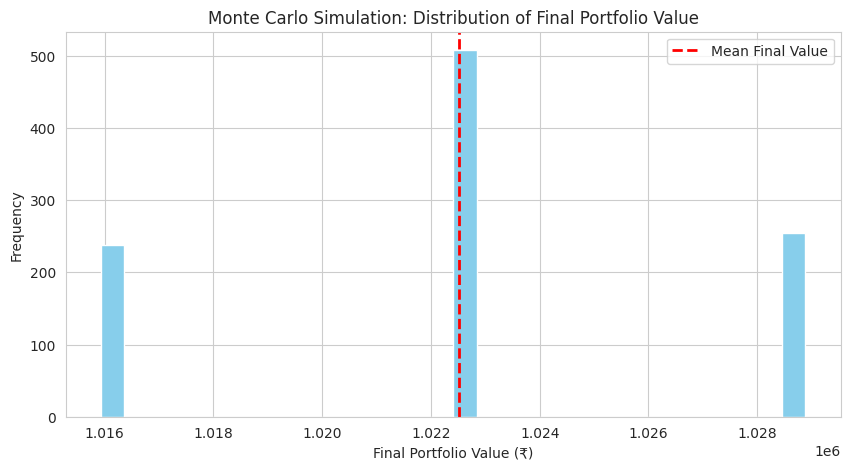

Monte Carlo: Mean Final Value = ₹1,022,512.74, 5th Percentile = ₹1,015,933.34, 95th Percentile = ₹1,028,884.92


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50

PARTIAL_TP_PCT = 0.15
FINAL_TP_PCT_LOW = 0.20
FINAL_TP_PCT_HIGH = 0.40

ATR_PERIOD = 10        # 10 minutes for 1-min bars
ATR_MULTIPLIER = 2.5
MAX_LOSS = 18000       # <-- updated as requested
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001

VIX_LOW = 13
VIX_MED = 17
RISK_LOW = 0.15
RISK_MED = 0.10
RISK_HIGH = 0.05

IVR_THRESHOLD = 40

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_1min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_1min_50_200.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/AlgoBulls_Data/Common_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

def compute_iv_rank(option_df, window=252):
    option_df = option_df.copy()
    option_df['IVR'] = option_df['IV'].rolling(window).apply(
        lambda x: 100 * (x[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0,
        raw=True
    )
    return option_df

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade(vix_value):
    if vix_value <= VIX_LOW:
        return RISK_LOW
    elif vix_value <= VIX_MED:
        return RISK_MED
    else:
        return RISK_HIGH

# --- Lot limiting logic ---
def limit_lots_based_on_history(entry_price, current_lots, trade_history):
    # Only consider trades with pnl > 0
    profitable_trades = [trade for trade in trade_history if trade['pnl'] > 0]
    if not profitable_trades:
        return current_lots  # no history, no limit
    max_lots_profitable = max(trade['lots'] for trade in profitable_trades)
    max_entry_price = max(trade['entry_price'] for trade in profitable_trades)
    if entry_price < 0.2 * max_entry_price:
        return min(current_lots, max_lots_profitable)
    else:
        return current_lots

def execute_trades_1min_atr_trailing_vix(
    spot_data, signals, options_data, vix_data,
    partial_tp_pct=PARTIAL_TP_PCT, tp_pct_low=FINAL_TP_PCT_LOW, tp_pct_high=FINAL_TP_PCT_HIGH,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_1min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_position = None
    prev_signal = 0

    # Pre-compute ATR for each option contract for trailing stop
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'])\
        .apply(lambda x: compute_atr(x, ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)

    # Pre-compute IV Rank for each option contract if IV available
    if 'IV' in options_data.columns:
        options_data = options_data.groupby(['Strike', 'Type', 'Expiry']).apply(compute_iv_rank).reset_index(drop=True)
    else:
        options_data['IVR'] = 0

    # --- Track trade history for lot limiting ---
    trade_history = []

    for ts, row in spot_data.iterrows():
        if ts not in signals_1min.index or pd.isna(row['close']):
            continue
        signal = signals_1min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            prev_signal = signal
            continue
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue

        vix_ma20 = vix_data['Close'].rolling(20*390, min_periods=1).mean().loc[ts]
        ivr = 0
        option_rows = options_data[
            (options_data['Strike'] == strike) &
            (options_data['Type'] == option_type) &
            (options_data['Expiry'].dt.date == expiry) &
            (options_data['TimeStamp'] <= ts)
        ].sort_values('TimeStamp')
        if not option_rows.empty and 'IVR' in option_rows.columns:
            ivr = float(option_rows.iloc[-1]['IVR'])
        if vix_val >= vix_ma20 or ivr >= IVR_THRESHOLD:
            prev_signal = signal
            continue

        if vix_val <= VIX_LOW:
            final_tp_pct = tp_pct_low
        elif vix_val > VIX_MED:
            final_tp_pct = tp_pct_high
        else:
            final_tp_pct = tp_pct_low + (tp_pct_high - tp_pct_low) * ((vix_val - VIX_LOW)/(VIX_MED - VIX_LOW))

        risk_per_trade = get_risk_per_trade(vix_val)

        if open_position is None and signal != 0 and signal != prev_signal:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                prev_signal = signal
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            # --- Lot limiting logic ---
            lots = limit_lots_based_on_history(entry_price, lots, trade_history)
            if lots < 1:
                prev_signal = signal
                continue
            partial_tp_price = entry_price * (1 + partial_tp_pct)
            final_tp_price = entry_price * (1 + final_tp_pct)
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct
            atr = float(entry_row.iloc[0]['ATR'])
            trailing_stop = entry_price_adj - ATR_MULTIPLIER * atr
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'partial_tp_price': partial_tp_price,
                'final_tp_price': final_tp_price,
                'trailing_stop': trailing_stop,
                'max_loss_stop': entry_price_adj - (MAX_LOSS / (lot_size * lots)),
                'entry_slippage': entry_slippage,
                'highest_price': entry_price_adj,
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'ivr_at_entry': ivr,
                'partial_booked': False,
                'partial_lots': lots // 2,
                'final_lots': lots - (lots // 2)
            }
            prev_signal = signal
            continue

        if open_position is not None:
            exit_reason = None
            exit_price = None
            exit_time = None

            option_rows = options_data[
                (options_data['Strike'] == open_position['strike']) &
                (options_data['Type'] == open_position['type']) &
                (options_data['Expiry'].dt.date == open_position['expiry']) &
                (options_data['TimeStamp'] >= open_position['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for _, opt_row in option_rows.iterrows():
                price = float(opt_row['Close'])
                atr = float(opt_row['ATR'])
                if price > open_position['highest_price']:
                    open_position['highest_price'] = price
                trailing_stop = open_position['highest_price'] - ATR_MULTIPLIER * atr
                open_position['trailing_stop'] = max(open_position['trailing_stop'], trailing_stop)
                if not open_position['partial_booked'] and price >= open_position['partial_tp_price']:
                    exit_slippage = price * slippage_pct * lot_size * open_position['partial_lots']
                    total_slippage += exit_slippage
                    total_brokerage += brokerage_per_order
                    exit_price_adj = price - price * slippage_pct
                    pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['partial_lots']
                    pnl -= (open_position['entry_slippage'] * (open_position['partial_lots']/open_position['lots']) + exit_slippage + 2 * brokerage_per_order)
                    if pnl < -MAX_LOSS:
                        pnl = -MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': open_position['entry_date'],
                        'entry_time': open_position['entry_time'],
                        'exit_date': opt_row['TimeStamp'],
                        'action': open_position['action'],
                        'type': open_position['type'],
                        'strike': open_position['strike'],
                        'entry_price': open_position['entry_price'],
                        'exit_price': exit_price_adj,
                        'lots': open_position['partial_lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': open_position['spot'],
                        'expiry': open_position['expiry'],
                        'exit_reason': 'Partial TP',
                        'risk_per_trade': open_position['risk_per_trade'],
                        'vix_at_entry': open_position['vix_at_entry'],
                        'ivr_at_entry': open_position['ivr_at_entry']
                    })
                    open_position['partial_booked'] = True
                    open_position['final_lots'] = open_position['final_lots']
                    continue

                if open_position['partial_booked'] and price >= open_position['final_tp_price']:
                    exit_price = open_position['final_tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Final TP'
                    break
                elif open_position['partial_booked'] and price <= open_position['trailing_stop']:
                    exit_price = open_position['trailing_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Trailing Stop'
                    break
                elif open_position['partial_booked'] and price <= open_position['max_loss_stop']:
                    exit_price = open_position['max_loss_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Max Loss Stop'
                    break
                elif ts.date() >= open_position['expiry']:
                    exit_price = price
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Expiry'
                    break

            if open_position['partial_booked'] and exit_reason is not None and exit_price is not None:
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['final_lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['final_lots']
                pnl -= (open_position['entry_slippage'] * (open_position['final_lots']/open_position['lots']) + exit_slippage + 2 * brokerage_per_order)
                if pnl < -MAX_LOSS:
                    pnl = -MAX_LOSS
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['final_lots'],
                    'pnl': pnl,
                    'holding_days': 0,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason,
                    'risk_per_trade': open_position['risk_per_trade'],
                    'vix_at_entry': open_position['vix_at_entry'],
                    'ivr_at_entry': open_position['ivr_at_entry']
                })
                # --- Update trade history for next entry ---
                trade_history.append({
                    'entry_price': open_position['entry_price'],
                    'pnl': pnl,
                    'lots': open_position['lots']
                })
                open_position = None

        prev_signal = signal

    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 1-min signals...")
signals = load_signals_1min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

print("\nExecuting trades 1-min with ATR trailing stop, partial/final TP, max loss cap, VIX/IVR-based risk management, and dynamic lot limiting...")
trade_log, total_brokerage, total_slippage = execute_trades_1min_atr_trailing_vix(
    spot_data, signals, options_sample, vix_data
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_1min_atr_trailing_tp_partial_final_maxloss_vix_ivr_lots.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_1min_atr_trailing_tp_partial_final_maxloss_vix_ivr_lots.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# --- (Performance reporting and visualizations as before) ---
# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    # --- Visualizations ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    # --- Trade PnL Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    # --- Holding Days Distribution ---
    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    # --- PnL Heatmap by Week and Type ---
    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    # --- Monte Carlo Simulation ---
    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")
